# Team Based Model

## Imports

In [92]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from tqdm import tqdm
from nba_api.stats.static import players, teams

import sys

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from src.data.make_team_dataset import load_team_data


from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, ElasticNetCV, LassoCV, RidgeCV, LogisticRegression, ElasticNet
from sklearn.linear_model import Ridge, Lasso, SGDRegressor
from sklearn.pipeline import make_pipeline

import lightgbm as lgb

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import LinearSVR, SVC
import xgboost as xgb
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import confusion_matrix
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
pd.options.display.max_columns=230
pd.options.display.max_rows=100

## Gather Team Level Basic, Advanced, and Scoring Data

In [94]:
team_data = load_team_data()

In [95]:
from src.data.make_team_dataset import clean_team_data

clean_team_df = clean_team_data(team_data)



In [96]:
from src.data.make_team_dataset import prep_for_aggregation
ready_for_agg_df = prep_for_aggregation(clean_team_df)
ready_for_agg_df

SEASON_YEAR  SEASON_ID     TEAM_ID TEAM_ABBREVIATION  \
0         2000-01      22000  1610612745               HOU   
1         2000-01      22000  1610612750               MIN   
2         2000-01      22000  1610612751               BKN   
3         2000-01      22000  1610612739               CLE   
4         2000-01      22000  1610612754               IND   
...           ...        ...         ...               ...   
51343     2019-20      42019  1610612747               LAL   
51344     2019-20      42019  1610612748               MIA   
51345     2019-20      42019  1610612747               LAL   
51346     2019-20      42019  1610612748               MIA   
51347     2019-20      42019  1610612747               LAL   

                    TEAM_NAME   GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  \
0             Houston Rockets  20000008 2000-10-31  HOU vs. MIN          1   
1      Minnesota Timberwolves  20000008 2000-10-31    MIN @ HOU          0   
2             New Jersey Nets  20000002 2000-10-31  BKN vs. CLE          1   
3         Cleveland Cavaliers  20000002 2000-10-31    CLE @ BKN          0   
4              Indiana Pacers  20000009 2000-10-31    IND @ SAS          0   
...                       ...       ...        ...          ...        ...   
51343      Los Angeles Lakers  41900404 2020-10-06    LAL @ MIA          0   
51344              Miami Heat  41900405 2020-10-09    MIA @ LAL          0   
51345      Los Angeles Lakers  41900405 2020-10-09  LAL vs. MIA          1   
51346              Miami Heat  41900406 2020-10-11  MIA vs. LAL          1   
51347      Los Angeles Lakers  41900406 2020-10-11    LAL @ MIA          0   

       TEAM_SCORE  point_diff  WL  MIN  RECORD  FG2M  FG2A  FG3M  FG3A  FTM  \
0              98          -8   0  240       0    32    65     2     9   28   
1             106           8   1  240       1    37    77     6    11   14   
2              82          -4   0  240       0    28    75     3    10   17   
3              86           4   1  240       1    30    71     2     7   20   
4              85         -13   0  240       0    32    63     4    17    9   
...           ...         ...  ..  ...     ...   ...   ...   ...   ...  ...   
51343         102           6   1  240       1    21    40    14    39   18   
51344         111           3   1  240       1    24    50    14    33   21   
51345         108          -3   0  240       0    24    44    14    38   18   
51346          93         -13   0  240       0    25    51    10    28   13   
51347         106          13   1  240       1    32    54    11    35    9   

       FTA  OREB  DREB  REB  AST  STL  BLK  TOV  PF  PTS  PLUS_MINUS  \
0       40    11    27   38   18    9    7   18  17   98          -8   
1       16    13    31   44   29    7    1   16  25  106           8   
2       26    12    35   47   24    9    8   15  31   82          -4   
3       32    11    41   52   16    5    8   19  27   86           4   
4       13     9    26   35   19    5    4   17  32   85         -13   
...    ...   ...   ...  ...  ...  ...  ...  ...  ..  ...         ...   
51343   21    10    32   42   25    5    4   15  14  102           6   
51344   22     9    26   35   26    7    3   13  19  111           3   
51345   21    12    29   41   21   10    5   15  21  108          -3   
51346   22     9    32   41   25    4    4   15  18   93         -13   
51347   14    12    34   46   23    5    4   14  22  106          13   

       E_OFF_RATING  OFF_RATING  E_DEF_RATING  DEF_RATING  E_NET_RATING  \
0              99.4       103.2         108.1       110.4          -8.7   
1             108.1       110.4          99.4       103.2           8.7   
2              82.5        83.7          85.9        87.8          -3.5   
3              85.9        87.8          82.5        83.7           3.5   
4              90.7        90.4         106.1       104.3         -15.4   
...             ...         ...           ...         ...   

## Add Betting Data 

In [97]:
from src.data.make_betting_dataset import clean_spread_data

spread_df = pd.read_csv('../data/all_spreads_sbr.csv', parse_dates=['game_date'])
clean_spread = clean_spread_data(spread_df)
clean_spread
clean_spread[['away_team', 'home_team', 'game_date', 'home_spread_mode', 'away_spread_mode']]

away_team home_team  game_date  home_spread_mode  away_spread_mode
0           CHI       MIA 2006-10-31              -4.5               4.5
1           PHX       LAL 2006-10-31               8.0              -8.5
2           TOR       BKN 2006-11-01              -7.5               7.0
3           NYK       MEM 2006-11-01              -5.0               5.0
4           ATL       PHI 2006-11-01              -6.0               5.5
...         ...       ...        ...               ...               ...
18423       MIN       MEM 2021-04-02              -7.0               7.0
18424       ATL       NOP 2021-04-02               1.5              -1.5
18425       CHI       UTA 2021-04-02             -11.0              11.0
18426       OKC       PHX 2021-04-02             -14.0              14.0
18427       LAL       SAC 2021-04-02              -5.0               5.0

[18428 rows x 5 columns]

In [98]:
from src.data.make_betting_dataset import clean_moneyline_data

ml_df = pd.read_csv('../data/all_moneylines_sbr.csv', parse_dates=['game_date'])
clean_moneylines = clean_moneyline_data(ml_df)



In [99]:
clean_moneylines

away_team home_team  game_date away_ml1 away_ml2 away_ml3 away_ml4  \
0           CHI       MIA 2006-10-31     +180      NaN     +180      NaN   
1           PHX       LAL 2006-10-31     -380      NaN     -350      NaN   
2           LAC       PHX 2006-11-01     +165      NaN     +155      NaN   
3           LAL       GSW 2006-11-01     +245      NaN     +250      NaN   
4           NYK       MEM 2006-11-01      NaN      NaN     +185      NaN   
...         ...       ...        ...      ...      ...      ...      ...   
18437       MIN       MEM 2021-04-02     +230     +205     +234     +215   
18438       ATL       NOP 2021-04-02     -125     -102     -117     -115   
18439       CHI       UTA 2021-04-02     +475     +660     +506     +505   
18440       OKC       PHX 2021-04-02     +725     +700     +797     +780   
18441       LAL       SAC 2021-04-02     +170     +162     +156     +165   

      home_ml1 home_ml2 home_ml3 home_ml4  
0         -220      NaN     -210      NaN  
1         +290      NaN     +290      NaN  
2         -190      NaN     -175      NaN  
3         -290      NaN     -300      NaN  
4          NaN      NaN     -215      NaN  
...        ...      ...      ...      ...  
18437     -280     -245     -285     -265  
18438     +105     -118     -102     -105  
18439     -750    -1000     -700     -655  
18440    -1300    -1100    -1300    -1080  
18441     -200     -182     -181     -190  

[18442 rows x 11 columns]

In [100]:
def convert_to_float(x):
    if x[0] == '+':
        return x[1:]
    elif x[0] == '-':
        return int(x)
    else:
        return np.nan

In [101]:
for col in clean_moneylines.columns[3:11]:
    clean_moneylines[col] = clean_moneylines[col].astype(str).apply(convert_to_float)
    clean_moneylines[col] = clean_moneylines[col].astype(float)
    
clean_moneylines['away_ml_mode'] = clean_moneylines.iloc[:, 3:7].mode(axis=1)[0]
clean_moneylines['home_ml_mode'] = clean_moneylines.iloc[:, 7:11].mode(axis=1)[0]

clean_moneylines

away_team home_team  game_date  away_ml1  away_ml2  away_ml3  away_ml4  \
0           CHI       MIA 2006-10-31     180.0       NaN     180.0       NaN   
1           PHX       LAL 2006-10-31    -380.0       NaN    -350.0       NaN   
2           LAC       PHX 2006-11-01     165.0       NaN     155.0       NaN   
3           LAL       GSW 2006-11-01     245.0       NaN     250.0       NaN   
4           NYK       MEM 2006-11-01       NaN       NaN     185.0       NaN   
...         ...       ...        ...       ...       ...       ...       ...   
18437       MIN       MEM 2021-04-02     230.0     205.0     234.0     215.0   
18438       ATL       NOP 2021-04-02    -125.0    -102.0    -117.0    -115.0   
18439       CHI       UTA 2021-04-02     475.0     660.0     506.0     505.0   
18440       OKC       PHX 2021-04-02     725.0     700.0     797.0     780.0   
18441       LAL       SAC 2021-04-02     170.0     162.0     156.0     165.0   

       home_ml1  home_ml2  home_ml3  home_ml4  away_ml_mode  home_ml_mode  
0        -220.0       NaN    -210.0       NaN         180.0        -220.0  
1         290.0       NaN     290.0       NaN        -380.0         290.0  
2        -190.0       NaN    -175.0       NaN         155.0        -190.0  
3        -290.0       NaN    -300.0       NaN         245.0        -300.0  
4           NaN       NaN    -215.0       NaN         185.0        -215.0  
...         ...       ...       ...       ...           ...           ...  
18437    -280.0    -245.0    -285.0    -265.0         205.0        -285.0  
18438     105.0    -118.0    -102.0    -105.0        -125.0        -118.0  
18439    -750.0   -1000.0    -700.0    -655.0         475.0       -1000.0  
18440   -1300.0   -1100.0   -1300.0   -1080.0         700.0       -1300.0  
18441    -200.0    -182.0    -181.0    -190.0         156.0        -200.0  

[18442 rows x 13 columns]

In [102]:
def add_moneyline_data(df):
    df = df.copy()
    df['home_team'] = df['MATCHUP'].apply(lambda x: x[:3] if 'vs' in x else x[-3:])
    df['away_team'] = df['MATCHUP'].apply(lambda x: x[:3] if '@' in x else x[-3:])
    df[['home_team', 'away_team', 'MATCHUP']]
    
    df = pd.merge(df, clean_moneylines[['away_team', 'home_team', 'game_date', 'away_ml_mode', 'home_ml_mode']], how='left', 
         left_on=['home_team', 'away_team', 'GAME_DATE'], right_on=['home_team', 'away_team', 'game_date'])    

    
    return df


ready_for_agg_df = add_moneyline_data(ready_for_agg_df)


In [103]:
def convert_american_to_decimal(x):
    if x > 0:
        return 1 + x/100
    if x < 0:
        return 1 - (100/x)
    
convert_american_to_decimal(200)


3.0

In [104]:
ready_for_agg_df['away_ml_mode'] = ready_for_agg_df['away_ml_mode'].apply(convert_american_to_decimal)
ready_for_agg_df['home_ml_mode'] = ready_for_agg_df['home_ml_mode'].apply(convert_american_to_decimal)


In [105]:
def add_spread_data(df):
    df = df.copy()
    df['home_team'] = df['MATCHUP'].apply(lambda x: x[:3] if 'vs' in x else x[-3:])
    df['away_team'] = df['MATCHUP'].apply(lambda x: x[:3] if '@' in x else x[-3:])
    df[['home_team', 'away_team', 'MATCHUP']]
    
    df = pd.merge(df, clean_spread[['away_team', 'home_team', 'game_date', 'away_spread_mode', 'home_spread_mode']], how='left', 
         left_on=['home_team', 'away_team', 'GAME_DATE'], right_on=['home_team', 'away_team', 'game_date'])    
    
    df['team_covered'] = df.apply(lambda row: int(row['point_diff'] + row['home_spread_mode'] > 0) 
                                          if row['HOME_GAME'] == 1 else int(row['point_diff'] + row['away_spread_mode'] > 0), axis=1)

    return df


ready_for_agg_df = add_spread_data(ready_for_agg_df)


In [106]:
ready_for_agg_df['ml'] = ready_for_agg_df.apply(lambda row: row['home_ml_mode'] if row['HOME_GAME'] == 1 else row['away_ml_mode'], axis=1)

ready_for_agg_df['spread'] = ready_for_agg_df.apply(lambda row: row['home_spread_mode'] if row['HOME_GAME'] == 1 else -row['home_spread_mode'], axis=1)


ready_for_agg_df.iloc[:, 10:]

point_diff  WL  MIN  RECORD  FG2M  FG2A  FG3M  FG3A  FTM  FTA  OREB  \
0              -8   0  240       0    32    65     2     9   28   40    11   
1               8   1  240       1    37    77     6    11   14   16    13   
2              -4   0  240       0    28    75     3    10   17   26    12   
3               4   1  240       1    30    71     2     7   20   32    11   
4             -13   0  240       0    32    63     4    17    9   13     9   
...           ...  ..  ...     ...   ...   ...   ...   ...  ...  ...   ...   
51339           6   1  240       1    21    40    14    39   18   21    10   
51340           3   1  240       1    24    50    14    33   21   22     9   
51341          -3   0  240       0    24    44    14    38   18   21    12   
51342         -13   0  240       0    25    51    10    28   13   22     9   
51343          13   1  240       1    32    54    11    35    9   14    12   

       DREB  REB  AST  STL  BLK  TOV  PF  PTS  PLUS_MINUS  E_OFF_RATING  \
0        27   38   18    9    7   18  17   98          -8          99.4   
1        31   44   29    7    1   16  25  106           8         108.1   
2        35   47   24    9    8   15  31   82          -4          82.5   
3        41   52   16    5    8   19  27   86           4          85.9   
4        26   35   19    5    4   17  32   85         -13          90.7   
...     ...  ...  ...  ...  ...  ...  ..  ...         ...           ...   
51339    32   42   25    5    4   15  14  102           6         109.4   
51340    26   35   26    7    3   13  19  111           3         114.8   
51341    29   41   21   10    5   15  21  108          -3         114.6   
51342    32   41   25    4    4   15  18   93         -13          98.2   
51343    34   46   23    5    4   14  22  106          13         109.1   

       OFF_RATING  E_DEF_RATING  DEF_RATING  E_NET_RATING  NET_RATING  POSS  \
0           103.2         108.1       110.4          -8.7        -7.3  95.0   
1           110.4          99.4       103.2           8.7         7.3  96.0   
2            83.7          85.9        87.8          -3.5        -4.1  98.0   
3            87.8          82.5        83.7           3.5         4.1  98.0   
4            90.4         106.1       104.3         -15.4       -13.8  94.0   
...           ...           ...         ...           ...         ...   ...   
51339       110.9         101.7       104.3           7.7         6.5  92.0   
51340       119.4         114.6       114.9           0.2         4.5  93.0   
51341       114.9         114.8       119.4          -0.2        -4.5  94.0   
51342       100.0         109.1       112.8         -10.9       -12.8  93.0   
51343       112.8          98.2       100.0          10.9        12.8  94.0   

         PIE  PTS_2PT_MR  PTS_FB  PTS_OFF_TOV  PTS_PAINT  AST_2PM  UAST_2PM  \
0      0.446          15       9           19         48       18        14   
1      0.554          41       9           22         32       23        13   
2      0.488          14       9           20         41       21         7   
3      0.512          23      14           12         36       14        15   
4      0.359          37       9           22         26       15        16   
...      ...         ...     ...          ...        ...      ...       ...   
51339  0.559           7       7           18         33       12         8   
51340  0.512          15       3           19         31       13        10   
51341  0.488           6      24           14         42       10        13   
51342  0.456           6       7           14         43       18         7   
51343  0.544          11      16           20         52       12        19   

       AST_3PM  UAST_3PM home_team away_team game_date_x  away_ml_mode  \
0            0         2       HOU       MIN         NaT           NaN   
1            6         0       HOU       MIN         NaT           NaN   
2            3         0       BKN       CLE     

In [107]:
ready_for_agg_df.loc[ready_for_agg_df['SEASON_YEAR']=='2006-07'].to_csv("merged_data_full.csv", index=False)

In [108]:
from src.data.make_team_dataset import create_matchups

matchups = create_matchups(ready_for_agg_df)
matchups

SEASON_YEAR_team  SEASON_ID_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
1               2000-01           22000    1610612745                    HOU   
2               2000-01           22000    1610612750                    MIN   
5               2000-01           22000    1610612751                    BKN   
6               2000-01           22000    1610612739                    CLE   
9               2000-01           22000    1610612754                    IND   
...                 ...             ...           ...                    ...   
102678          2019-20           42019    1610612747                    LAL   
102681          2019-20           42019    1610612748                    MIA   
102682          2019-20           42019    1610612747                    LAL   
102685          2019-20           42019    1610612748                    MIA   
102686          2019-20           42019    1610612747                    LAL   

                TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
1              Houston Rockets  20000008     2000-10-31  HOU vs. MIN   
2       Minnesota Timberwolves  20000008     2000-10-31    MIN @ HOU   
5              New Jersey Nets  20000002     2000-10-31  BKN vs. CLE   
6          Cleveland Cavaliers  20000002     2000-10-31    CLE @ BKN   
9               Indiana Pacers  20000009     2000-10-31    IND @ SAS   
...                        ...       ...            ...          ...   
102678      Los Angeles Lakers  41900404     2020-10-06    LAL @ MIA   
102681              Miami Heat  41900405     2020-10-09    MIA @ LAL   
102682      Los Angeles Lakers  41900405     2020-10-09  LAL vs. MIA   
102685              Miami Heat  41900406     2020-10-11  MIA vs. LAL   
102686      Los Angeles Lakers  41900406     2020-10-11    LAL @ MIA   

        HOME_GAME_team  TEAM_SCORE_team  point_diff_team  WL_team  \
1                    1               98               -8        0   
2                    0              106                8        1   
5                    1               82               -4        0   
6                    0               86                4        1   
9                    0               85              -13        0   
...                ...              ...              ...      ...   
102678               0              102                6        1   
102681               0              111                3        1   
102682               1              108               -3        0   
102685               1               93              -13        0   
102686               0              106               13        1   

        RECORD_team  FG2M_team  FG2A_team  FG3M_team  FG3A_team  FTM_team  \
1                 0         32         65          2          9        28   
2                 1         37         77          6         11        14   
5                 0         28         75          3         10        17   
6                 1         30         71          2          7        20   
9                 0         32         63          4         17         9   
...             ...        ...        ...        ...        ...       ...   
102678            1         21         40         14         39        18   
102681            1         24         50         14         33        21   
102682            0         24         44         14         38        18   
102685            0         25         51         10         28        13   
102686            1         32         54         11         35         9   

        FTA_team  OREB_team  DREB_team  REB_team  AST_team  STL_team  \
1             40         11         27        38        18         9   
2             16         13         31        44        29         7   
5             26         12         35        47        24         9   
6             32         11         41        52        16         5   
9             13          9         26        35        19         

In [109]:
matchups.columns

Index(['SEASON_YEAR_team', 'SEASON_ID_team', 'TEAM_ID_team',
       'TEAM_ABBREVIATION_team', 'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team',
       'MATCHUP_team', 'HOME_GAME_team', 'TEAM_SCORE_team', 'point_diff_team',
       'WL_team', 'RECORD_team', 'FG2M_team', 'FG2A_team', 'FG3M_team',
       'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team', 'DREB_team',
       'REB_team', 'AST_team', 'STL_team', 'BLK_team', 'TOV_team', 'PF_team',
       'PTS_team', 'PLUS_MINUS_team', 'E_OFF_RATING_team', 'E_DEF_RATING_team',
       'E_NET_RATING_team', 'POSS_team', 'PIE_team', 'PTS_2PT_MR_team',
       'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team', 'AST_2PM_team',
       'UAST_2PM_team', 'AST_3PM_team', 'UAST_3PM_team', 'team_covered_team',
       'ml_team', 'spread_team', 'RECORD_opp', 'FG2M_opp', 'FG2A_opp',
       'FG3M_opp', 'FG3A_opp', 'FTM_opp', 'FTA_opp', 'OREB_opp', 'DREB_opp',
       'REB_opp', 'AST_opp', 'STL_opp', 'BLK_opp', 'TOV_opp', 'PF_opp',
       'PTS_opp', 'PLUS_MINUS_opp'

In [110]:
def get_team_and_opp_ewm(df, min_periods=5, span=19, adjust=True):
    df = df.copy()
        
    df = df[['SEASON_YEAR_team', 'SEASON_ID_team', 'TEAM_ID_team',
       'TEAM_ABBREVIATION_team', 'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team',
       'MATCHUP_team', 'HOME_GAME_team', 'TEAM_SCORE_team', 'point_diff_team',
       'WL_team', 'ml_team', 'spread_team', 'team_covered_team',
        'RECORD_team', 'FG2M_team', 'FG2A_team', 'FG3M_team',
       'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team', 'DREB_team',
       'REB_team', 'AST_team', 'STL_team', 'BLK_team', 'TOV_team', 'PF_team',
       'PTS_team', 'PLUS_MINUS_team', 'E_OFF_RATING_team', 'E_DEF_RATING_team',
       'E_NET_RATING_team', 'POSS_team', 'PIE_team', 'PTS_2PT_MR_team',
       'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team', 'AST_2PM_team',
       'UAST_2PM_team', 'AST_3PM_team', 'UAST_3PM_team', 'team_covered_opp', 
       'RECORD_opp', 'FG2M_opp', 'FG2A_opp', 'FG3M_opp', 'FG3A_opp', 'FTM_opp',
       'FTA_opp', 'OREB_opp', 'DREB_opp', 'REB_opp', 'AST_opp', 'STL_opp', 
       'BLK_opp', 'TOV_opp', 'PF_opp', 'PTS_opp', 'PLUS_MINUS_opp',
       'E_OFF_RATING_opp', 'E_DEF_RATING_opp', 'E_NET_RATING_opp', 'POSS_opp',
       'PIE_opp', 'PTS_2PT_MR_opp', 'PTS_FB_opp', 'PTS_OFF_TOV_opp',
       'PTS_PAINT_opp', 'AST_2PM_opp', 'UAST_2PM_opp', 'AST_3PM_opp', 
        'UAST_3PM_opp']]



    team_dfs = []
    for season in tqdm(df['SEASON_YEAR_team'].unique(), desc='Progress'):
        season_df = df.loc[df['SEASON_YEAR_team'] == season]
        for team in df['TEAM_ABBREVIATION_team'].unique():
            team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
            record_team = team_df['RECORD_team'].shift(1).expanding().mean()

            ATS_rec_team = team_df['team_covered_team'].shift(1).expanding().mean()
            
            records = pd.DataFrame({'WL_record':record_team,
                                   'ATS_record':ATS_rec_team})
            
            team_df.iloc[:, 14:] = team_df.iloc[:, 14:].shift(1).ewm(span = span, min_periods=min_periods).mean()

            team_df = pd.concat([team_df, records], axis=1)
            
            team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)
        
    return new_df

avg_data_ewm_19 = get_team_and_opp_ewm(matchups, min_periods=5, span=19)

Progress: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.30it/s]


In [111]:
avg_data_ewm_19

SEASON_YEAR_team  SEASON_ID_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
0              2000-01           22000    1610612745                    HOU   
1              2000-01           22000    1610612745                    HOU   
2              2000-01           22000    1610612745                    HOU   
3              2000-01           22000    1610612745                    HOU   
4              2000-01           22000    1610612745                    HOU   
...                ...             ...           ...                    ...   
51339          2019-20           22019    1610612740                    NOP   
51340          2019-20           22019    1610612740                    NOP   
51341          2019-20           22019    1610612740                    NOP   
51342          2019-20           22019    1610612740                    NOP   
51343          2019-20           22019    1610612740                    NOP   

             TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
0           Houston Rockets  20000008     2000-10-31  HOU vs. MIN   
1           Houston Rockets  20000023     2000-11-02  HOU vs. MIL   
2           Houston Rockets  20000044     2000-11-04    HOU @ LAC   
3           Houston Rockets  20000048     2000-11-05    HOU @ PHX   
4           Houston Rockets  20000058     2000-11-07  HOU vs. LAL   
...                     ...       ...            ...          ...   
51339  New Orleans Pelicans  21901268     2020-08-06    NOP @ SAC   
51340  New Orleans Pelicans  21901278     2020-08-07  NOP vs. WAS   
51341  New Orleans Pelicans  21901287     2020-08-09  NOP vs. SAS   
51342  New Orleans Pelicans  21901302     2020-08-11    NOP @ SAC   
51343  New Orleans Pelicans  21901312     2020-08-13    NOP @ ORL   

       HOME_GAME_team  TEAM_SCORE_team  point_diff_team  WL_team   ml_team  \
0                   1               98               -8        0       NaN   
1                   1              115               22        1       NaN   
2                   0               74               -3        0       NaN   
3                   0               99               -5        0       NaN   
4                   1               84               10        1       NaN   
...               ...              ...              ...      ...       ...   
51339               0              125              -15        0  1.526316   
51340               1              118               11        1  1.273973   
51341               1              113               -9        0  1.606061   
51342               0              106               -6        0  2.230000   
51343               0              127               -6        0  2.450000   

       spread_team  team_covered_team  RECORD_team  FG2M_team  FG2A_team  \
0              NaN                NaN          NaN        NaN        NaN   
1              NaN                NaN          NaN        NaN        NaN   
2              NaN                NaN          NaN        NaN        NaN   
3              NaN                NaN          NaN        NaN        NaN   
4              NaN                NaN          NaN        NaN        NaN   
...            ...                ...          ...        ...        ...   
51339         -4.0           0.513506     0.508290  30.244968  57.069727   
51340         -8.0           0.462116     0.457421  30.520684  56.162052   
51341         -3.5           0.515942     0.511717  30.468580  55.845626   
51342          3.0           0.464315     0.460513  30.421692  56.861700   
51343          4.0           0.417857     0.414436  30.879781  56.975595   

       FG3M_team  FG3A_team   FTM_team   FTA_team  OREB_team  DREB_team  \
0            NaN        NaN        NaN        NaN        NaN        NaN   
1            NaN        NaN        NaN        NaN        NaN        NaN   
2            NaN        NaN        NaN        NaN        NaN        NaN   
3            NaN        NaN        NaN        NaN        NaN        NaN   
4  

In [112]:
avg_data_ewm_19.loc[(avg_data_ewm_19['TEAM_ABBREVIATION_team'] == 'HOU') 
                   & (avg_data_ewm_19['SEASON_YEAR_team'] == '2016-17'), ['MATCHUP_team', 'point_diff_team', 'RECORD_team',
                                                                          'team_covered_team', 'spread_team', 'WL_record', 
                                                                          'ATS_record']].head(20)

# avg_data_ewm_19.iloc[:, 11:]

MATCHUP_team  point_diff_team  RECORD_team  team_covered_team  \
41194    HOU @ LAL               -6          NaN                NaN   
41195    HOU @ DAL                8          NaN                NaN   
41196  HOU vs. DAL                1          NaN                NaN   
41197    HOU @ CLE               -8          NaN                NaN   
41198    HOU @ NYK               19          NaN                NaN   
41199    HOU @ ATL              -15     0.620009           0.641987   
41200    HOU @ WAS                8     0.487687           0.504974   
41201    HOU @ SAS                2     0.585887           0.408180   
41202  HOU vs. SAS               -6     0.658598           0.512094   
41203  HOU vs. PHI               27     0.551086           0.428497   
41204    HOU @ OKC               -2     0.620009           0.516242   
41205  HOU vs. POR               17     0.529654           0.586742   
41206  HOU vs. UTA                9     0.595201           0.644333   
41207    HOU @ DET                3     0.649477           0.692021   
41208  HOU vs. TOR              -13     0.694927           0.731955   
41209    HOU @ SAC               13     0.607417           0.639782   
41210    HOU @ POR               16     0.655604           0.683997   
41211    HOU @ UTA              -19     0.696937           0.721922   
41212    HOU @ GSW                5     0.614935           0.636980   
41213    HOU @ DEN               18     0.659456           0.678952   

       spread_team  WL_record  ATS_record  
41194         -6.0        NaN         NaN  
41195         -2.0   0.000000    0.000000  
41196         -6.0   0.500000    0.500000  
41197          9.5   0.666667    0.333333  
41198          1.0   0.500000    0.500000  
41199          3.0   0.600000    0.600000  
41200          NaN   0.500000    0.500000  
41201          9.0   0.571429    0.428571  
41202          1.5   0.625000    0.500000  
41203        -11.5   0.555556    0.444444  
41204          2.5   0.600000    0.500000  
41205         -5.5   0.545455    0.545455  
41206         -6.5   0.583333    0.583333  
41207         -2.5   0.615385    0.615385  
41208         -4.0   0.642857    0.642857  
41209         -3.5   0.600000    0.600000  
41210         -1.5   0.625000    0.625000  
41211         -1.5   0.647059    0.647059  
41212         11.5   0.611111    0.611111  
41213          3.5   0.631579    0.631579

## Feature Engineering

We will calculate OREB_PCT, DREB_PCT, TS_PCT,
<br>EFG_PCT, AST_RATIO, TOV_PCT for both team and opp
<br>which we removed earlier, from the averaged raw numbers.


In [113]:
from src.features.build_team_features import add_rest_days
from src.features.build_team_features import add_percentage_features


In [114]:
avg_data_ewm_19

SEASON_YEAR_team  SEASON_ID_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
0              2000-01           22000    1610612745                    HOU   
1              2000-01           22000    1610612745                    HOU   
2              2000-01           22000    1610612745                    HOU   
3              2000-01           22000    1610612745                    HOU   
4              2000-01           22000    1610612745                    HOU   
...                ...             ...           ...                    ...   
51339          2019-20           22019    1610612740                    NOP   
51340          2019-20           22019    1610612740                    NOP   
51341          2019-20           22019    1610612740                    NOP   
51342          2019-20           22019    1610612740                    NOP   
51343          2019-20           22019    1610612740                    NOP   

             TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
0           Houston Rockets  20000008     2000-10-31  HOU vs. MIN   
1           Houston Rockets  20000023     2000-11-02  HOU vs. MIL   
2           Houston Rockets  20000044     2000-11-04    HOU @ LAC   
3           Houston Rockets  20000048     2000-11-05    HOU @ PHX   
4           Houston Rockets  20000058     2000-11-07  HOU vs. LAL   
...                     ...       ...            ...          ...   
51339  New Orleans Pelicans  21901268     2020-08-06    NOP @ SAC   
51340  New Orleans Pelicans  21901278     2020-08-07  NOP vs. WAS   
51341  New Orleans Pelicans  21901287     2020-08-09  NOP vs. SAS   
51342  New Orleans Pelicans  21901302     2020-08-11    NOP @ SAC   
51343  New Orleans Pelicans  21901312     2020-08-13    NOP @ ORL   

       HOME_GAME_team  TEAM_SCORE_team  point_diff_team  WL_team   ml_team  \
0                   1               98               -8        0       NaN   
1                   1              115               22        1       NaN   
2                   0               74               -3        0       NaN   
3                   0               99               -5        0       NaN   
4                   1               84               10        1       NaN   
...               ...              ...              ...      ...       ...   
51339               0              125              -15        0  1.526316   
51340               1              118               11        1  1.273973   
51341               1              113               -9        0  1.606061   
51342               0              106               -6        0  2.230000   
51343               0              127               -6        0  2.450000   

       spread_team  team_covered_team  RECORD_team  FG2M_team  FG2A_team  \
0              NaN                NaN          NaN        NaN        NaN   
1              NaN                NaN          NaN        NaN        NaN   
2              NaN                NaN          NaN        NaN        NaN   
3              NaN                NaN          NaN        NaN        NaN   
4              NaN                NaN          NaN        NaN        NaN   
...            ...                ...          ...        ...        ...   
51339         -4.0           0.513506     0.508290  30.244968  57.069727   
51340         -8.0           0.462116     0.457421  30.520684  56.162052   
51341         -3.5           0.515942     0.511717  30.468580  55.845626   
51342          3.0           0.464315     0.460513  30.421692  56.861700   
51343          4.0           0.417857     0.414436  30.879781  56.975595   

       FG3M_team  FG3A_team   FTM_team   FTA_team  OREB_team  DREB_team  \
0            NaN        NaN        NaN        NaN        NaN        NaN   
1            NaN        NaN        NaN        NaN        NaN        NaN   
2            NaN        NaN        NaN        NaN        NaN        NaN   
3            NaN        NaN        NaN        NaN        NaN        NaN   
4  

In [115]:
avg_data_2_ewm_19 = add_rest_days(avg_data_ewm_19)
full_df_ewm_19 = add_percentage_features(avg_data_2_ewm_19)

In [116]:
full_df_ewm_19.loc[full_df_ewm_19['rest'] > 11, 'rest'] = 11
full_df_ewm_19['rest'].value_counts()

2.0     28445
1.0     11038
3.0      8051
4.0      2075
5.0       398
6.0       351
7.0       139
8.0       106
9.0       102
11.0       27
10.0       16
Name: rest, dtype: int64

In [117]:
test = full_df_ewm_19[(full_df_ewm_19['TEAM_ABBREVIATION_team'] == 'SAS') & (full_df_ewm_19['SEASON_YEAR_team'] == '2006-07')]
test

SEASON_YEAR_team  SEASON_ID_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
15849          2006-07           22006    1610612759                    SAS   
15850          2006-07           22006    1610612759                    SAS   
15851          2006-07           22006    1610612759                    SAS   
15852          2006-07           22006    1610612759                    SAS   
15853          2006-07           22006    1610612759                    SAS   
...                ...             ...           ...                    ...   
15946          2006-07           42006    1610612759                    SAS   
15947          2006-07           42006    1610612759                    SAS   
15948          2006-07           42006    1610612759                    SAS   
15949          2006-07           42006    1610612759                    SAS   
15950          2006-07           42006    1610612759                    SAS   

          TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
15849  San Antonio Spurs  20600016     2006-11-02    SAS @ DAL   
15850  San Antonio Spurs  20600025     2006-11-03  SAS vs. CLE   
15851  San Antonio Spurs  20600040     2006-11-05    SAS @ TOR   
15852  San Antonio Spurs  20600046     2006-11-06    SAS @ NYK   
15853  San Antonio Spurs  20600064     2006-11-08  SAS vs. PHX   
...                  ...       ...            ...          ...   
15946  San Antonio Spurs  40600315     2007-05-30  SAS vs. UTA   
15947  San Antonio Spurs  40600401     2007-06-07  SAS vs. CLE   
15948  San Antonio Spurs  40600402     2007-06-10  SAS vs. CLE   
15949  San Antonio Spurs  40600403     2007-06-12    SAS @ CLE   
15950  San Antonio Spurs  40600404     2007-06-14    SAS @ CLE   

       HOME_GAME_team  TEAM_SCORE_team  point_diff_team  WL_team   ml_team  \
15849               0               97                6        1  2.250000   
15850               1               81               -7        0  1.416667   
15851               0              103                9        1  1.377358   
15852               0              105               12        1  1.333333   
15853               1              111                5        1  1.434783   
...               ...              ...              ...      ...       ...   
15946               1              109               25        1  1.200000   
15947               1               85                9        1  1.181818   
15948               1              103               11        1  1.219780   
15949               0               75                3        1  1.909091   
15950               0               83                1        1  1.714286   

       spread_team  team_covered_team  RECORD_team  FG2M_team  FG2A_team  \
15849          3.0                NaN          NaN        NaN        NaN   
15850         -5.5                NaN          NaN        NaN        NaN   
15851         -6.5                NaN          NaN        NaN        NaN   
15852         -6.5                NaN          NaN        NaN        NaN   
15853         -5.5                NaN          NaN        NaN        NaN   
...            ...                ...          ...        ...        ...   
15946         -8.5           0.604958     0.715882  27.870459  56.344376   
15947         -7.5           0.644464     0.744295  28.283427  56.809954   
15948         -7.0           0.680018     0.769866  28.255083  57.028965   
15949         -0.0           0.712017     0.792880  28.329577  56.626058   
15950         -2.0           0.740816     0.813593  27.296595  55.863434   

       FG3M_team  FG3A_team   FTM_team   FTA_team  OREB_team  DREB_team  \
15849        NaN        NaN        NaN        NaN        NaN        NaN   
15850        NaN        NaN        NaN        NaN        NaN        NaN   
15851        NaN        NaN        NaN        NaN        NaN        NaN   
15852        NaN        NaN        NaN        NaN        NaN        NaN   
15853        NaN        NaN        NaN 

In [118]:
def compute_matchup_diffs(avg_data):
    avg_data = avg_data.copy()
    avg_data.drop(columns=['MIN_opp'], inplace=True)
        
    home_teams = avg_data.loc[avg_data['HOME_GAME_team'] == 1].sort_values('GAME_ID').reset_index(drop=True)
    away_teams = avg_data.loc[avg_data['HOME_GAME_team'] == 0].sort_values('GAME_ID').reset_index(drop=True)


    stat_diffs = home_teams.iloc[:, 14:] - away_teams.iloc[:, 14:]
    new_cols = [col+"_diff" for col in stat_diffs.columns]
    stat_diffs.columns = new_cols


    full_df = pd.concat([home_teams.iloc[:, :14], stat_diffs], axis=1)

    full_df = full_df.dropna()
    full_df = full_df.sort_values('GAME_DATE_team')

    full_df.rename(columns={'SEASON_YEAR_team':'SEASON_YEAR',
                            'SEASON_ID_team':'SEASON_ID',
                            'TEAM_ID_team': 'TEAM_ID',
                            'TEAM_ABBREVIATION_team': 'TEAM_ABBREVIATION',
                            'TEAM_NAME_team': 'TEAM_NAME',
                            'GAME_DATE_team': 'GAME_DATE',
                            'MATCHUP_team': 'MATCHUP',
                            'HOME_GAME_team': 'HOME_GAME',
                            'TEAM_SCORE_team': 'SCORE_team'}, inplace=True)

    full_df = full_df.reset_index(drop=True)
    
    return full_df

# full_df_ewm_19 = compute_matchup_diffs(avg_data_3_ewm_19)

In [119]:
full_df_ewm_19.loc[full_df_ewm_19['GAME_ID'] == 20000008]

SEASON_YEAR_team  SEASON_ID_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
0           2000-01           22000    1610612745                    HOU   
82          2000-01           22000    1610612750                    MIN   

            TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
0          Houston Rockets  20000008     2000-10-31  HOU vs. MIN   
82  Minnesota Timberwolves  20000008     2000-10-31    MIN @ HOU   

    HOME_GAME_team  TEAM_SCORE_team  point_diff_team  WL_team  ml_team  \
0                1               98               -8        0      NaN   
82               0              106                8        1      NaN   

    spread_team  team_covered_team  RECORD_team  FG2M_team  FG2A_team  \
0           NaN                NaN          NaN        NaN        NaN   
82          NaN                NaN          NaN        NaN        NaN   

    FG3M_team  FG3A_team  FTM_team  FTA_team  OREB_team  DREB_team  REB_team  \
0         NaN        NaN       NaN       NaN        NaN        NaN       NaN   
82        NaN        NaN       NaN       NaN        NaN        NaN       NaN   

    AST_team  STL_team  BLK_team  TOV_team  PF_team  PTS_team  \
0        NaN       NaN       NaN       NaN      NaN       NaN   
82       NaN       NaN       NaN       NaN      NaN       NaN   

    PLUS_MINUS_team  E_OFF_RATING_team  E_DEF_RATING_team  E_NET_RATING_team  \
0               NaN                NaN                NaN                NaN   
82              NaN                NaN                NaN                NaN   

    POSS_team  PIE_team  PTS_2PT_MR_team  PTS_FB_team  PTS_OFF_TOV_team  \
0         NaN       NaN              NaN          NaN               NaN   
82        NaN       NaN              NaN          NaN               NaN   

    PTS_PAINT_team  AST_2PM_team  UAST_2PM_team  AST_3PM_team  UAST_3PM_team  \
0              NaN           NaN            NaN           NaN            NaN   
82             NaN           NaN            NaN           NaN            NaN   

    team_covered_opp  RECORD_opp  FG2M_opp  FG2A_opp  FG3M_opp  FG3A_opp  \
0                NaN         NaN       NaN       NaN       NaN       NaN   
82               NaN         NaN       NaN       NaN       NaN       NaN   

    FTM_opp  FTA_opp  OREB_opp  DREB_opp  REB_opp  AST_opp  STL_opp  BLK_opp  \
0       NaN      NaN       NaN       NaN      NaN      NaN      NaN      NaN   
82      NaN      NaN       NaN       NaN      NaN      NaN      NaN      NaN   

    TOV_opp  PF_opp  PTS_opp  PLUS_MINUS_opp  E_OFF_RATING_opp  \
0       NaN     NaN      NaN             NaN               NaN   
82      NaN     NaN      NaN             NaN               NaN   

    E_DEF_RATING_opp  E_NET_RATING_opp  POSS_opp  PIE_opp  PTS_2PT_MR_opp  \
0                NaN               NaN       NaN      NaN             NaN   
82               NaN               NaN       NaN      NaN             NaN   

    PTS_FB_opp  PTS_OFF_TOV_opp  PTS_PAINT_opp  AST_2PM_opp  UAST_2PM_opp  \
0          NaN              NaN            NaN          NaN           NaN   
82         NaN              NaN            NaN          NaN           NaN   

    AST_3PM_opp  UAST_3PM_opp  WL_record  ATS_record  rest  OREB_PCT_team  \
0           NaN           NaN        NaN         NaN   NaN            NaN   
82          NaN           NaN        NaN         NaN   NaN            NaN   

    OREB_PCT_opp  DREB_PCT_team  DREB_PCT_opp  REB_PCT_team  REB_PCT_opp  \
0            NaN            NaN           NaN           NaN          NaN   
82           NaN            NaN           NaN           NaN          NaN   

    TS_PCT_team  TS_PCT_opp  EFG_PCT_team  EFG_PCT_opp  AST_RATIO_team  \
0           NaN         NaN           NaN          NaN             NaN   
82          NaN         NaN           NaN          NaN             NaN   

    AST_RATIO_opp  TOV_PCT_team  TOV_PCT_opp  
0             NaN           NaN          NaN  
82            NaN           NaN          NaN

## Add ELO Rating

In [120]:
# Helper functions go generate ELO rating

def get_K(MOV, elo_diff):
    """This K multiplier """
    K_0 = 20    

    if MOV > 0:
        multiplier = (MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier = (-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
        
    return K_0*multiplier, K_0*multiplier

def get_S(team_score, opp_score):
    """S is the 1 if the team wins, and 0 if the team loses"""
    S_team, S_opp = 0, 0
    if team_score > opp_score:
        S_team = 1
    else:
        S_opp = 1
    return S_team, S_opp


def elo_prediction(team_rating, opp_rating):
    """Generate the probability of a home victory based on the teams' elo ratings"""
    E_team = 1.0/(1 + 10 ** ((opp_rating - team_rating) / (400.0)))
    return E_team


def elo_update(team_score, opp_score, team_rating, opp_rating):
    # Add 100 to the home_rating for home court advantage   
    
    E_team = elo_prediction(team_rating, opp_rating)
    E_opp = 1.0 - E_team
    
    
    MOV = team_score - opp_score
    if MOV > 0:
        elo_diff = team_rating - opp_rating
    else:
        elo_diff = opp_rating - team_rating
    
#     print(MOV)
        
    S_team, S_opp = get_S(team_score, opp_score)
    
    K_team, K_opp = get_K(MOV, elo_diff)
        
#     print("expected_win_prob: ", E_team, E_opp)
#     print("elo_diff:", elo_diff)
#     print("S_team:", S_team, "S_opp:", S_opp)
#     print("K_team:", K_team, "K_opp:", K_opp)
#     print(K_team*(S_team-E_team), K_opp*(S_opp-E_opp))
#     print(elo_diff, K_team*(S_team-E_team), K_opp*(S_opp-E_opp))
    return K_team*(S_team-E_team), K_opp*(S_opp-E_opp)
    



def season_reset(rating):
    new_rating = 0.75*rating + 0.25*1505
    return new_rating
    

In [121]:
elo_update(100, 110, 1500, 1700)
get_K(10, 100)

(19.21762252355425, 19.21762252355425)

In [122]:
full_df_ewm_19.rename(columns={'SEASON_YEAR_team':'SEASON_YEAR',
                            'SEASON_ID_team':'SEASON_ID',
                            'TEAM_ID_team': 'TEAM_ID',
                            'TEAM_ABBREVIATION_team': 'TEAM_ABBREVIATION',
                            'TEAM_NAME_team': 'TEAM_NAME',
                            'GAME_DATE_team': 'GAME_DATE',
                            'MATCHUP_team': 'MATCHUP',
                            'HOME_GAME_team': 'HOME_GAME',
                            'TEAM_SCORE_team': 'SCORE_team'}, inplace=True)



In [123]:

def add_elo_ratings(df):
    """This function will generate elo_ratings in the elo_df
    """
    
    # Initialize the following columns
    df.sort_values(['GAME_DATE', 'GAME_ID'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['team_elo_pred'] = np.nan

    df['team_rating_i'] = np.nan
    df['team_rating_n'] = np.nan

    df['opp_rating_i'] = np.nan
    df['opp_rating_n'] = np.nan

    elo_dic = {}
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        if (idx > 2) and (row['SEASON_YEAR'] != df.loc[idx-1, 'SEASON_YEAR']):
            for team in elo_dic:
                elo_dic[team] = season_reset(elo_dic[team])

                
        if (idx >= 1) and (row['GAME_ID'] == df.loc[idx-1, 'GAME_ID']):
            df.loc[idx, 'team_rating_i'] = df.loc[idx-1, 'opp_rating_i']
            df.loc[idx, 'team_rating_n'] = df.loc[idx-1, 'opp_rating_n']
            df.loc[idx, 'opp_rating_i'] = df.loc[idx-1, 'team_rating_i']
            df.loc[idx, 'opp_rating_n'] = df.loc[idx-1, 'team_rating_n']
            df.loc[idx, 'team_elo_pred'] = 1 - df.loc[idx-1, 'team_elo_pred']            
            continue
            
        team_abbr = row['MATCHUP'][:3]
        opp_abbr = row['MATCHUP'][-3:]
            
        if team_abbr not in elo_dic:
            elo_dic[team_abbr] = 1300
            df.loc[idx, 'team_rating_i'] = 1300
        else:
            df.loc[idx, 'team_rating_i'] = elo_dic[team_abbr]            

        if opp_abbr not in elo_dic:
            elo_dic[opp_abbr] = 1300
            df.loc[idx, 'opp_rating_i'] = 1300
        else:
            df.loc[idx, 'opp_rating_i'] = elo_dic[opp_abbr]

        team_score = row['SCORE_team']
        opp_score = row['SCORE_team'] - row['point_diff_team']
            
        team_rating = elo_dic[team_abbr]
        opp_rating = elo_dic[opp_abbr]

        if row['HOME_GAME'] == 1:
            team_rating_temp = team_rating + 69
            opp_rating_temp = opp_rating
        else:
            opp_rating_temp = opp_rating + 69
            team_rating_temp = team_rating
            
        team_update, opp_update = elo_update(team_score, opp_score, team_rating_temp, opp_rating_temp)

        df.loc[idx, 'team_rating_n'] = team_rating + team_update
        df.loc[idx, 'opp_rating_n'] = opp_rating + opp_update
        

        df.loc[idx, 'team_elo_pred'] = elo_prediction(team_rating_temp, opp_rating_temp)

        elo_dic[team_abbr] = df.loc[idx, 'team_rating_n']
        elo_dic[opp_abbr] = df.loc[idx, 'opp_rating_n']

    df['elo_MOV_pred'] = round((df['team_rating_i'] - df['opp_rating_i'])/28, 2)

    return df


In [124]:
full_df_ewm_19 = add_elo_ratings(full_df_ewm_19)

progress:: 51344it [01:37, 527.25it/s]


In [125]:
full_df_ewm_19

SEASON_YEAR  SEASON_ID     TEAM_ID TEAM_ABBREVIATION  \
0         2000-01      22000  1610612755               PHI   
1         2000-01      22000  1610612752               NYK   
2         2000-01      22000  1610612751               BKN   
3         2000-01      22000  1610612739               CLE   
4         2000-01      22000  1610612764               WAS   
...           ...        ...         ...               ...   
51339     2019-20      42019  1610612748               MIA   
51340     2019-20      42019  1610612747               LAL   
51341     2019-20      42019  1610612748               MIA   
51342     2019-20      42019  1610612747               LAL   
51343     2019-20      42019  1610612748               MIA   

                 TEAM_NAME   GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  \
0       Philadelphia 76ers  20000001 2000-10-31    PHI @ NYK          0   
1          New York Knicks  20000001 2000-10-31  NYK vs. PHI          1   
2          New Jersey Nets  20000002 2000-10-31  BKN vs. CLE          1   
3      Cleveland Cavaliers  20000002 2000-10-31    CLE @ BKN          0   
4       Washington Wizards  20000003 2000-10-31    WAS @ ORL          0   
...                    ...       ...        ...          ...        ...   
51339           Miami Heat  41900404 2020-10-06  MIA vs. LAL          1   
51340   Los Angeles Lakers  41900405 2020-10-09  LAL vs. MIA          1   
51341           Miami Heat  41900405 2020-10-09    MIA @ LAL          0   
51342   Los Angeles Lakers  41900406 2020-10-11    LAL @ MIA          0   
51343           Miami Heat  41900406 2020-10-11  MIA vs. LAL          1   

       SCORE_team  point_diff_team  WL_team   ml_team  spread_team  \
0             101               29        1       NaN          NaN   
1              72              -29        0       NaN          NaN   
2              82               -4        0       NaN          NaN   
3              86                4        1       NaN          NaN   
4              86              -11        0       NaN          NaN   
...           ...              ...      ...       ...          ...   
51339          96               -6        0  3.520000          7.5   
51340         108               -3        0  1.289855         -7.5   
51341         111                3        1  3.070000          7.5   
51342         106               13        1  1.400000         -5.5   
51343          93              -13        0  3.100000          5.5   

       team_covered_team  RECORD_team  FG2M_team  FG2A_team  FG3M_team  \
0                    NaN          NaN        NaN        NaN        NaN   
1                    NaN          NaN        NaN        NaN        NaN   
2                    NaN          NaN        NaN        NaN        NaN   
3                    NaN          NaN        NaN        NaN        NaN   
4                    NaN          NaN        NaN        NaN        NaN   
...                  ...          ...        ...        ...        ...   
51339           0.667870     0.587760  26.009318  46.942907  12.550399   
51340           0.411075     0.751238  28.137884  48.969500  12.241791   
51341           0.701085     0.528980  25.508355  46.548592  12.395350   
51342           0.369965     0.676109  27.724067  48.472516  12.417624   
51343           0.730978     0.576085  25.357512  46.893752  12.555824   

       FG3A_team   FTM_team   FTA_team  OREB_team  DREB_team   REB_team  \
0            NaN        NaN        NaN        NaN        NaN        NaN   
1            NaN        NaN        NaN        NaN        NaN        NaN   
2            NaN        NaN        NaN        NaN        NaN        NaN   
3            NaN        NaN        NaN        NaN        NaN        NaN   
4            NaN        NaN        NaN        NaN        NaN        NaN   
...          ...        ...        ...        ...        ...        ...   
51339  35.898172  21.691795  25.843895   7.054391  33.702197  40.756588   
51340  34.725289  19.410983  2

In [126]:
# full_df_ewm_19.sort_values(['GAME_DATE', 'GAME_ID'], inplace=True)

full_df_ewm_19.loc[full_df_ewm_19['TEAM_ABBREVIATION'] == 'PHI', ['TEAM_ABBREVIATION', 'MATCHUP', 'team_rating_i', 'team_rating_n', 'opp_rating_i', 'opp_rating_n']]

TEAM_ABBREVIATION      MATCHUP  team_rating_i  team_rating_n  \
0                   PHI    PHI @ NYK    1300.000000    1327.005984   
28                  PHI  PHI vs. TOR    1327.005984    1332.001259   
58                  PHI    PHI @ ORL    1332.001259    1341.336939   
68                  PHI    PHI @ MIA    1341.336939    1346.895490   
122                 PHI  PHI vs. DET    1346.895490    1352.381087   
...                 ...          ...            ...            ...   
51171               PHI    PHI @ HOU    1547.600332    1579.652016   
51180               PHI    PHI @ BOS    1579.652016    1573.741608   
51196               PHI    PHI @ BOS    1573.741608    1561.048563   
51212               PHI  PHI vs. BOS    1561.048563    1553.146680   
51228               PHI  PHI vs. BOS    1553.146680    1547.863155   

       opp_rating_i  opp_rating_n  
0       1300.000000   1272.994016  
28      1288.967089   1283.971814  
58      1292.183757   1282.848077  
68      1312.060126   1306.501574  
122     1279.033165   1273.547569  
...             ...           ...  
51171   1610.394746   1578.343063  
51180   1671.664599   1677.575006  
51196   1677.575006   1690.268051  
51212   1690.268051   1698.169935  
51228   1698.169935   1703.453459  

[1716 rows x 6 columns]

In [127]:
final_df_ewm_19 = pd.merge(full_df_ewm_19, full_df_ewm_19, on=['GAME_ID'])

final_df_ewm_19 = final_df_ewm_19.loc[final_df_ewm_19['TEAM_ABBREVIATION_x'] != final_df_ewm_19['TEAM_ABBREVIATION_y']]

final_df_ewm_19 = final_df_ewm_19.drop(columns=['SEASON_YEAR_y','SEASON_ID_y','TEAM_ID_y','TEAM_ABBREVIATION_y',
                              'TEAM_NAME_y','GAME_DATE_y','MATCHUP_y','HOME_GAME_y', 
                             'team_elo_pred_y', 'team_rating_i_y', 'team_rating_n_y',
                             'opp_rating_i_y', 'opp_rating_n_y', 'elo_MOV_pred_y', 'SCORE_team_y',
                            'ml_team_y', 'spread_team_y', 'point_diff_team_y'])

final_df_ewm_19

SEASON_YEAR_x  SEASON_ID_x   TEAM_ID_x TEAM_ABBREVIATION_x  \
1            2000-01        22000  1610612755                 PHI   
2            2000-01        22000  1610612752                 NYK   
5            2000-01        22000  1610612751                 BKN   
6            2000-01        22000  1610612739                 CLE   
9            2000-01        22000  1610612764                 WAS   
...              ...          ...         ...                 ...   
102678       2019-20        42019  1610612748                 MIA   
102681       2019-20        42019  1610612747                 LAL   
102682       2019-20        42019  1610612748                 MIA   
102685       2019-20        42019  1610612747                 LAL   
102686       2019-20        42019  1610612748                 MIA   

                TEAM_NAME_x   GAME_ID GAME_DATE_x    MATCHUP_x  HOME_GAME_x  \
1        Philadelphia 76ers  20000001  2000-10-31    PHI @ NYK            0   
2           New York Knicks  20000001  2000-10-31  NYK vs. PHI            1   
5           New Jersey Nets  20000002  2000-10-31  BKN vs. CLE            1   
6       Cleveland Cavaliers  20000002  2000-10-31    CLE @ BKN            0   
9        Washington Wizards  20000003  2000-10-31    WAS @ ORL            0   
...                     ...       ...         ...          ...          ...   
102678           Miami Heat  41900404  2020-10-06  MIA vs. LAL            1   
102681   Los Angeles Lakers  41900405  2020-10-09  LAL vs. MIA            1   
102682           Miami Heat  41900405  2020-10-09    MIA @ LAL            0   
102685   Los Angeles Lakers  41900406  2020-10-11    LAL @ MIA            0   
102686           Miami Heat  41900406  2020-10-11  MIA vs. LAL            1   

        SCORE_team_x  point_diff_team_x  WL_team_x  ml_team_x  spread_team_x  \
1                101                 29          1        NaN            NaN   
2                 72                -29          0        NaN            NaN   
5                 82                 -4          0        NaN            NaN   
6                 86                  4          1        NaN            NaN   
9                 86                -11          0        NaN            NaN   
...              ...                ...        ...        ...            ...   
102678            96                 -6          0   3.520000            7.5   
102681           108                 -3          0   1.289855           -7.5   
102682           111                  3          1   3.070000            7.5   
102685           106                 13          1   1.400000           -5.5   
102686            93                -13          0   3.100000            5.5   

        team_covered_team_x  RECORD_team_x  FG2M_team_x  FG2A_team_x  \
1                       NaN            NaN          NaN          NaN   
2                       NaN            NaN          NaN          NaN   
5                       NaN            NaN          NaN          NaN   
6                       NaN            NaN          NaN          NaN   
9                       NaN            NaN          NaN          NaN   
...                     ...            ...          ...          ...   
102678             0.667870       0.587760    26.009318    46.942907   
102681             0.411075       0.751238    28.137884    48.969500   
102682             0.701085       0.528980    25.508355    46.548592   
102685             0.369965       0.676109    27.724067    48.472516   
102686             0.730978       0.576085    25.357512    46.893752   

        FG3M_team_x  FG3A_team_x  FTM_team_x  FTA_team_x  OREB_team_x  \
1               NaN          NaN         NaN         NaN          NaN   
2               NaN          NaN         NaN         NaN          NaN   
5               NaN          NaN         NaN         NaN          NaN   
6               NaN          NaN         NaN         NaN          NaN   
9               NaN          NaN      

## Helper Functions for Bet Simulations

In [128]:
def simulate_bets(selected_bets, unit_size=0.03):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 10000
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100)
    return selected_bets

In [129]:
def simulate_weighted_bets(selected_bets, unit_size=0.01):
    """This function simulates betting 1% of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 10000
    
    
    std = abs(selected_bets['model_probability']-0.5).std()
    min_threshold = abs(selected_bets['model_probability'] - 0.5).min()
    print(std)
    
    cond_list = [abs(selected_bets['model_probability']-0.5).between(min_threshold, min_threshold+0.5*std),
                abs(selected_bets['model_probability']-0.5).between(min_threshold+0.5*std, min_threshold+1*std),
                abs(selected_bets['model_probability']-0.5).between(min_threshold+1*std, min_threshold+1.5*std),
                abs(selected_bets['model_probability']-0.5) > min_threshold+1.5*std]
    
    choice_list = [1, 2, 3, 4]
    
    selected_bets['weight'] = np.select(cond_list, choice_list)
    for idx in selected_bets.index:
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        weight = selected_bets.loc[idx, 'weight']
        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_size * weight
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100)
    return selected_bets

In [130]:
# Find ranges of model probability where the win percentage is higher than 52.8
def find_optimal_threshold(df, test_probs, test_indices):
    """
    INPUTS:
    test_preds: array of class predictions
    test_indices: indices of full df for the test set 
    OUTPUTS:
    select_bets: df of bets at the optimal thresholds
    best_thresholds: tuple of lower and upper thresholds
    
    """
    df = df.copy()
    betting_df = df.loc[test_indices, ['GAME_DATE', 'home_spread_mode', 'point_diff_team']]
    betting_df.rename(columns={'home_spread_mode':'spread'}, inplace=True)
    betting_df['prob'] = test_probs[:, 1]
    betting_df['home_cover'] = (betting_df['point_diff_team'] + betting_df['spread'] > 0).astype(int)
    betting_df['bet_home'] = (betting_df['prob']>0.5).astype(int)

    betting_df = betting_df.loc[betting_df['spread'] + betting_df['point_diff_team'] != 0]
    betting_df['bet_won'] = (betting_df['bet_home'] == betting_df['home_cover']).astype(int)

    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df['bankroll_i'].iloc[0] = 10000
    betting_df['bet_size'] = np.nan

    confidence_range = []
    win_percentages = []
    num_games_bet = []
    expected_profits = []
    for i in range(1, 500):
        select_bets = betting_df.loc[~betting_df['prob'].between(0.5-i/1000, 0.5+i/1000)]
        win_pct = select_bets['bet_won'].mean()
        num_games = select_bets.shape[0]
        confidence_range.append((0.5+i/100))
        win_percentages.append(win_pct)
        num_games_bet.append(num_games)
        bets_won = select_bets['bet_won'].sum()
        bets_lost = num_games - bets_won
        expected_profit = (bets_won*100 + bets_lost*-108)
        expected_profits.append(expected_profit)

    confidence_thresholds = pd.DataFrame({'confidence_range':confidence_range, 
                                       'num_games_bet':num_games_bet, 
                                       'win_percentage':win_percentages,
                                         'expected_profit':expected_profits})
    
    confidence_thresholds = confidence_thresholds.loc[confidence_thresholds['win_percentage'] > 0.53]
    confidence_thresholds.sort_values('expected_profit', ascending=False, inplace=True)
    confidence_thresholds = confidence_thresholds.reset_index(drop=False) 
    try:
        best_thresholds = confidence_thresholds.loc[0, 'confidence_thresholds']
        print("best thresholds:", best_thresholds)
        select_bets =  betting_df.loc[abs(betting_df['confidence_preds']) > best_thresholds]
        print("num_games_bet:", select_bets.shape[0])
        print("win percetange at threshold:", select_bets['bet_won'].mean())
        print("The try block executed")
    except:
        print("no best threshold")
        select_bets = betting_df
        print("The except block executed")
    
    return select_bets, confidence_thresholds
    



In [131]:
final_df_ewm_19

SEASON_YEAR_x  SEASON_ID_x   TEAM_ID_x TEAM_ABBREVIATION_x  \
1            2000-01        22000  1610612755                 PHI   
2            2000-01        22000  1610612752                 NYK   
5            2000-01        22000  1610612751                 BKN   
6            2000-01        22000  1610612739                 CLE   
9            2000-01        22000  1610612764                 WAS   
...              ...          ...         ...                 ...   
102678       2019-20        42019  1610612748                 MIA   
102681       2019-20        42019  1610612747                 LAL   
102682       2019-20        42019  1610612748                 MIA   
102685       2019-20        42019  1610612747                 LAL   
102686       2019-20        42019  1610612748                 MIA   

                TEAM_NAME_x   GAME_ID GAME_DATE_x    MATCHUP_x  HOME_GAME_x  \
1        Philadelphia 76ers  20000001  2000-10-31    PHI @ NYK            0   
2           New York Knicks  20000001  2000-10-31  NYK vs. PHI            1   
5           New Jersey Nets  20000002  2000-10-31  BKN vs. CLE            1   
6       Cleveland Cavaliers  20000002  2000-10-31    CLE @ BKN            0   
9        Washington Wizards  20000003  2000-10-31    WAS @ ORL            0   
...                     ...       ...         ...          ...          ...   
102678           Miami Heat  41900404  2020-10-06  MIA vs. LAL            1   
102681   Los Angeles Lakers  41900405  2020-10-09  LAL vs. MIA            1   
102682           Miami Heat  41900405  2020-10-09    MIA @ LAL            0   
102685   Los Angeles Lakers  41900406  2020-10-11    LAL @ MIA            0   
102686           Miami Heat  41900406  2020-10-11  MIA vs. LAL            1   

        SCORE_team_x  point_diff_team_x  WL_team_x  ml_team_x  spread_team_x  \
1                101                 29          1        NaN            NaN   
2                 72                -29          0        NaN            NaN   
5                 82                 -4          0        NaN            NaN   
6                 86                  4          1        NaN            NaN   
9                 86                -11          0        NaN            NaN   
...              ...                ...        ...        ...            ...   
102678            96                 -6          0   3.520000            7.5   
102681           108                 -3          0   1.289855           -7.5   
102682           111                  3          1   3.070000            7.5   
102685           106                 13          1   1.400000           -5.5   
102686            93                -13          0   3.100000            5.5   

        team_covered_team_x  RECORD_team_x  FG2M_team_x  FG2A_team_x  \
1                       NaN            NaN          NaN          NaN   
2                       NaN            NaN          NaN          NaN   
5                       NaN            NaN          NaN          NaN   
6                       NaN            NaN          NaN          NaN   
9                       NaN            NaN          NaN          NaN   
...                     ...            ...          ...          ...   
102678             0.667870       0.587760    26.009318    46.942907   
102681             0.411075       0.751238    28.137884    48.969500   
102682             0.701085       0.528980    25.508355    46.548592   
102685             0.369965       0.676109    27.724067    48.472516   
102686             0.730978       0.576085    25.357512    46.893752   

        FG3M_team_x  FG3A_team_x  FTM_team_x  FTA_team_x  OREB_team_x  \
1               NaN          NaN         NaN         NaN          NaN   
2               NaN          NaN         NaN         NaN          NaN   
5               NaN          NaN         NaN         NaN          NaN   
6               NaN          NaN         NaN         NaN          NaN   
9               NaN          NaN      

In [132]:
# Find ranges of model probability where the win percentage is higher than 52.8
def find_optimal_confidence_thresholds(df, diff_preds, test_indices):
    """
    INPUTS:
    test_preds: array of class predictions
    test_indices: indices of full df for the test set 
    OUTPUTS:
    select_bets: df of bets at the optimal thresholds
    best_thresholds: tuple of lower and upper thresholds
    
    """
    betting_df = df.loc[test_indices, ['GAME_ID', 'HOME_GAME_x', 'MATCHUP_x', 
                                                 'spread_team_x', 'ml_team_x', 'SCORE_team_x', 
                                                 'point_diff_team_x']]
    betting_df.rename(columns={'MATCHUP_x':'MATCHUP',
                               'HOME_GAME_x':'HOME_GAME',
                               'spread_team_x':'spread', 
                              'ml_team_x':'ml', 
                              'SCORE_team_x':'team_score', 
                              'point_diff_team_x':'point_diff'}, inplace=True)


    betting_df['cover'] = (betting_df['spread'] + betting_df['point_diff'] > 0).astype(int)

    betting_df['diff_preds'] = diff_preds

    home_df = betting_df.loc[betting_df['HOME_GAME']==1]
    away_df = betting_df.loc[betting_df['HOME_GAME']==0]

    betting_df = pd.merge(home_df, away_df, on=['GAME_ID'], suffixes=['_home', '_away'])

    betting_df = betting_df[['GAME_ID', 'MATCHUP_home', 'spread_home', 
                                 'ml_home', 'ml_away', 'point_diff_home', 
                                 'cover_home', 'diff_preds_home', 
                             'diff_preds_away']]

    betting_df['point_diff_avg'] = (betting_df['diff_preds_home'] - betting_df['diff_preds_away'])/2

    betting_df['bet_home1'] = ((betting_df['diff_preds_home'] + betting_df['spread_home']) >0).astype(int)
    betting_df['bet_home2'] = ((-1*betting_df['diff_preds_away'] + betting_df['spread_home']) >0).astype(int)
    betting_df['bet_home3'] = ((betting_df['point_diff_avg'] + betting_df['spread_home']) >0).astype(int)

    betting_df = betting_df.loc[betting_df['spread_home'] + betting_df['point_diff_home']!=0]

    betting_df['confidence_pred1'] = betting_df['diff_preds_home'] + betting_df['spread_home']
    betting_df['confidence_pred2'] = -betting_df['diff_preds_away'] + betting_df['spread_home']
    betting_df['confidence_pred3'] = betting_df['point_diff_avg'] + betting_df['spread_home']


    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df['bankroll_i'].iloc[0] = 10000
    betting_df['bet_size'] = np.nan
        
    prediction_num = []
    confidence_threshold = []
    win_percentages = []
    num_games_bet = []
    expected_profits = []
    
    for num in range(1, 4):
        betting_df['bet_won'] = (betting_df['bet_home{}'.format(num)] == betting_df['cover_home']).astype(int)

        for i in range(1, 1001):
            select_bets = betting_df.loc[abs(betting_df['confidence_pred{}'.format(num)]) > i/100]
            win_pct = select_bets['bet_won'].mean()
            num_games = select_bets.shape[0]
            confidence_threshold.append(i/100)
            win_percentages.append(win_pct)
            num_games_bet.append(num_games)
            bets_won = select_bets['bet_won'].sum()
            bets_lost = num_games - bets_won
            expected_profit = (bets_won*100 + bets_lost*-108)
            expected_profits.append(expected_profit)
            prediction_num.append(num)
        

    confidence_thresholds = pd.DataFrame({'prediction_num':prediction_num,
                                        'confidence_thresholds':confidence_threshold, 
                                       'num_games_bet':num_games_bet, 
                                       'win_percentage':win_percentages,
                                         'expected_profits':expected_profits})
    
    confidence_thresholds = confidence_thresholds.loc[confidence_thresholds['win_percentage'] > 0.53]
    confidence_thresholds.sort_values(['expected_profits', 'confidence_thresholds'], 
                                      ascending=[False, True], inplace=True)
    confidence_thresholds = confidence_thresholds.reset_index(drop=False) 
    print('DONE')

    try:
        best_threshold = confidence_thresholds.loc[0, 'confidence_thresholds']
        print("best threshold:", best_threshold)
        best_num = confidence_thresholds.loc[0, 'prediction_num']
        print("best prediction strat:", best_num)
        betting_df['bet_won'] = (betting_df['bet_home{}'.format(best_num)] == betting_df['cover_home']).astype(int)
        select_bets = betting_df.loc[abs(betting_df['confidence_pred{}'.format(best_num)]) > best_threshold]
        print("num_games_bet:", select_bets.shape[0])
        print("win percetange at threshold:", select_bets['bet_won'].mean())
    except:
        print("no best threshold")
        select_bets = betting_df
   
    
    return select_bets, confidence_thresholds
    

In [133]:
# Find ranges of model probability where the win percentage is higher than 52.8

def find_optimal_spreads(test_preds, test_indices):
    betting_df = final_df[['GAME_DATE', 'home_spread_mode', 'point_diff_team']].iloc[cutoff_15:]
    betting_df.rename(columns={'home_spread_mode':'spread'}, inplace=True)
    betting_df['preds'] = test_preds
    betting_df['home_cover'] = (betting_df['point_diff_team'] + betting_df['spread'] > 0).astype(int)
    betting_df['bet_home'] = (betting_df['preds'] + betting_df['spread'] > 0).astype(int)

    betting_df.loc[betting_df['spread'] + betting_df['point_diff_team'] == 0, 'home_cover'] = 0.5
    betting_df = betting_df.loc[betting_df['home_cover'] != 0.5]
    betting_df['bet_won'] = (betting_df['bet_home'] == betting_df['home_cover']).astype(int)

    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df['bankroll_i'].iloc[0] = 10000
    betting_df['bet_size'] = np.nan

    betting_df['model_spread_diff'] = betting_df['preds'] + betting_df['spread']
    
    spread_threshold = []
    win_percentage = []
    number_bets = []
    estimated_profit = []
    for i in range(0, 20):
        select_bets = betting_df.loc[abs(betting_df['spread']) < i]
        win_pct = select_bets['bet_won'].mean()
        n_bets_won = select_bets.loc[select_bets['bet_won'] == 1].shape[0]
        n_bets_lost = select_bets.loc[select_bets['bet_won'] == 0].shape[0]
        estimated_prof = 100 * n_bets_won - 108 * n_bets_lost
        num_bets = select_bets.shape[0]
        
        spread_threshold.append(i)
        win_percentage.append(win_pct)
        number_bets.append(num_bets)
        estimated_profit.append(estimated_prof)
        
    spread_thresholds_df = pd.DataFrame({'spread_threshold':spread_threshold,
                                        'win_percentage':win_percentage,
                                        'number_bets':number_bets,
                                        'estimated_profit':estimated_profit})
    return spread_thresholds_df



#### Test Model Per Season

In [134]:
def test_model_per_season(df, model, feature_names, test_seasons_idxs, threshold):
    df = df.copy(deep=True)
    
    X = df[feature_names]
    y = df['point_diff_team'] + df['home_spread_mode']
    
    result_dfs = []
    for i in range(len(test_seasons_idxs)):
        X_train = X.loc[:test_seasons_idxs[i][0], :]
        X_test = X.loc[test_seasons_idxs[i][0]:test_seasons_idxs[i][-1], :]
        y_train = y.loc[:test_seasons_idxs[i][0]]
        y_test = y.loc[test_seasons_idxs[i][0]:test_seasons_idxs[i][-1]]

        model.fit(X_train, y_train)
        
        preds = model.predict(X_test)

        betting_results = df.loc[X_test.index, ['GAME_DATE', 'MATCHUP', 'point_diff_team', 'home_spread_mode']]
        betting_results.rename(columns={'point_diff_team':'point_diff',
                                       'home_spread_mode':'spread'}, inplace=True)

        betting_results['model_preds'] = preds
        betting_results['bet_home'] = (betting_results['model_preds'] > 0).astype(int)
        betting_results['home_cover'] = ((betting_results['point_diff'] + betting_results['spread']) > 0).astype(int)
        betting_results['bet_won'] = (betting_results['bet_home'] == betting_results['home_cover']).astype(int)
        betting_results.loc[betting_results['point_diff'] + betting_results['spread'] != 0]

        betting_results['bankroll_i'] = np.nan
        betting_results['bankroll_n'] = np.nan
        betting_results['bet_size'] = np.nan

        select_bets = betting_results.loc[abs(betting_results['model_preds']) > threshold]

        results = simulate_bets(select_bets)
        result_dfs.append(results)
    return result_dfs

In [209]:
def create_betting_df(df, diff_preds, test_indices, strat_num):
    df = df.copy()
    betting_df = df.loc[test_indices, ['GAME_ID', 'HOME_GAME_x', 'MATCHUP_x', 
                                                 'spread_team_x', 'ml_team_x', 'SCORE_team_x', 
                                                 'point_diff_team_x']]
    betting_df.rename(columns={'MATCHUP_x':'MATCHUP',
                               'HOME_GAME_x':'HOME_GAME',
                               'spread_team_x':'spread', 
                              'ml_team_x':'ml', 
                              'SCORE_team_x':'team_score', 
                              'point_diff_team_x':'point_diff'}, inplace=True)


    betting_df['cover'] = (betting_df['spread'] + betting_df['point_diff'] >0).astype(int)

    betting_df['diff_preds'] = diff_preds

    home_df = betting_df.loc[betting_df['HOME_GAME']==1]
    away_df = betting_df.loc[betting_df['HOME_GAME']==0]

    betting_df = pd.merge(home_df, away_df, on=['GAME_ID'], suffixes=['_home', '_away'])

    betting_df = betting_df[['GAME_ID', 'MATCHUP_home', 'spread_home', 
                                 'ml_home', 'ml_away', 'team_score_home', 
                                 'team_score_away', 'point_diff_home', 
                                 'cover_home', 'diff_preds_home', 
                             'diff_preds_away']]

    betting_df['point_diff_avg'] = (betting_df['diff_preds_home'] - betting_df['diff_preds_away'])/2

    betting_df['bet_home1'] = ((betting_df['diff_preds_home'] + betting_df['spread_home']) > 0).astype(int)
    betting_df['bet_home2'] = ((-1*betting_df['diff_preds_away'] + betting_df['spread_home']) > 0).astype(int)
    betting_df['bet_home3'] = ((betting_df['point_diff_avg'] + betting_df['spread_home']) > 0).astype(int)

    betting_df = betting_df.loc[betting_df['spread_home'] + betting_df['point_diff_home']!=0]

    betting_df['confidence_pred1'] = betting_df['diff_preds_home'] + betting_df['spread_home']
    betting_df['confidence_pred2'] = -betting_df['diff_preds_away'] + betting_df['spread_home']
    betting_df['confidence_pred3'] = betting_df['point_diff_avg'] + betting_df['spread_home']


    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df.loc[0, 'bankroll_i'] = 10000
    betting_df['bet_size'] = np.nan
    
    betting_df['bet_won'] = (betting_df['bet_home{}'.format(strat_num)] == betting_df['cover_home']).astype(int)

    return betting_df


## Create Features Sets

### Features EWM

In [136]:
final_df_ewm_19.iloc[:, 12:]

ml_team_x  spread_team_x  team_covered_team_x  RECORD_team_x  \
1             NaN            NaN                  NaN            NaN   
2             NaN            NaN                  NaN            NaN   
5             NaN            NaN                  NaN            NaN   
6             NaN            NaN                  NaN            NaN   
9             NaN            NaN                  NaN            NaN   
...           ...            ...                  ...            ...   
102678   3.520000            7.5             0.667870       0.587760   
102681   1.289855           -7.5             0.411075       0.751238   
102682   3.070000            7.5             0.701085       0.528980   
102685   1.400000           -5.5             0.369965       0.676109   
102686   3.100000            5.5             0.730978       0.576085   

        FG2M_team_x  FG2A_team_x  FG3M_team_x  FG3A_team_x  FTM_team_x  \
1               NaN          NaN          NaN          NaN         NaN   
2               NaN          NaN          NaN          NaN         NaN   
5               NaN          NaN          NaN          NaN         NaN   
6               NaN          NaN          NaN          NaN         NaN   
9               NaN          NaN          NaN          NaN         NaN   
...             ...          ...          ...          ...         ...   
102678    26.009318    46.942907    12.550399    35.898172   21.691795   
102681    28.137884    48.969500    12.241791    34.725289   19.410983   
102682    25.508355    46.548592    12.395350    35.508331   21.622611   
102685    27.724067    48.472516    12.417624    35.052782   19.269875   
102686    25.357512    46.893752    12.555824    35.257484   21.560346   

        FTA_team_x  OREB_team_x  DREB_team_x  REB_team_x  AST_team_x  \
1              NaN          NaN          NaN         NaN         NaN   
2              NaN          NaN          NaN         NaN         NaN   
5              NaN          NaN          NaN         NaN         NaN   
6              NaN          NaN          NaN         NaN         NaN   
9              NaN          NaN          NaN         NaN         NaN   
...            ...          ...          ...         ...         ...   
102678   25.843895     7.054391    33.702197   40.756588   25.655200   
102681   25.250722    10.308192    33.130183   43.438374   25.669530   
102682   25.859506     7.048952    33.531967   40.580918   24.889633   
102685   24.825621    10.477384    32.717136   43.194520   25.202545   
102686   25.473534     7.244067    32.778728   40.022795   25.000676   

        STL_team_x  BLK_team_x  TOV_team_x  PF_team_x  PTS_team_x  \
1              NaN         NaN         NaN        NaN         NaN   
2              NaN         NaN         NaN        NaN         NaN   
5              NaN         NaN         NaN        NaN         NaN   
6              NaN         NaN         NaN        NaN         NaN   
9              NaN         NaN         NaN        NaN         NaN   
...            ...         ...         ...        ...         ...   
102678    6.575313    3.941199   12.637253  20.541357  111.361629   
102681    7.807835    5.025118   15.261675  22.383960  112.412124   
102682    6.717791    3.847074   12.873542  20.587224  109.825372   
102685    8.027067    5.022606   15.235506  22.245555  111.970881   
102686    6.746013    3.762361   12.886188  20.428493  109.942841   

        PLUS_MINUS_team_x  E_OFF_RATING_team_x  E_DEF_RATING_team_x  \
1                     NaN                  NaN                  NaN   
2                     NaN                  NaN                  NaN   
5                     NaN                  NaN                  NaN   
6                     NaN                  NaN                  NaN   
9                     NaN                  NaN                  NaN   
...                   ...                  ...                  ...   
102678           0.664233           111.778901           110.26

In [137]:
# final_df_ewm_19.to_csv("../data/clean_data/clean_ewm_19.csv", index=False)

In [138]:
df_19 = final_df_ewm_19.sort_values(['GAME_DATE_x', 'GAME_ID']).reset_index(drop=True)
df_19 = df_19.dropna()
df_19.reset_index(drop=True, inplace=True)

cutoff_14 = df_19.loc[df_19['SEASON_YEAR_x'] == '2013-14'].index[-1]
cutoff_17 = df_19.loc[df_19['SEASON_YEAR_x'] == '2016-17'].index[-1]


features = df_19.iloc[:, 12:]
features = features.drop(columns=['team_rating_n_x', 'opp_rating_n_x', 'WL_team_y'])

point_diff = df_19['point_diff_team_x']

X_train1 = features.loc[:cutoff_14]
X_test1 = features.loc[cutoff_14:cutoff_17]

point_diff_train1 = point_diff.loc[:cutoff_14]
point_diff_test1 = point_diff.loc[cutoff_14:cutoff_17]

X_train2 = features.loc[:cutoff_17]
X_test2 = features.loc[cutoff_17+1:]

point_diff_train2 = point_diff.loc[:cutoff_17]
point_diff_test2 = point_diff.loc[cutoff_17+1:]

last_train_date = pd.to_datetime(df_19.loc[28084, 'GAME_DATE_x'])         
time_elapsed = (last_train_date - df_19.loc[:28084, 'GAME_DATE_x']) / np.timedelta64(1, 'D')

sample_weights = np.exp(-time_elapsed/1000)
sample_weights1 = sample_weights[:len(X_train1)]
sample_weights2 = sample_weights[:len(X_train2)]

train_idx2 = X_train2.index
test_idx1 = X_test1.index
test_idx2 = X_test2.index

print("cutoff_14:", cutoff_14, "cutoff_17:", cutoff_17)

print(X_train1.shape, X_test1.shape, point_diff_train1.shape, point_diff_test1.shape)
print(X_train2.shape, X_test2.shape, point_diff_train2.shape, point_diff_test2.shape)

print(final_df_ewm_19.shape[0])
print(len(sample_weights1), len(sample_weights2))

cutoff_14: 18282 cutoff_17: 25626
(18283, 164) (7345, 164) (18283,) (7345,)
(25627, 164) (6992, 164) (25627,) (6992,)
51344
18283 25627


### Define Custom Scorer

In [139]:
from sklearn.metrics import make_scorer

def my_scorer(y_true, y_pred):
#     residual = y_pred - y_true
#     condlist = [np.where(y_true<0, residual**2, 10*residual**2), np.where(y_true<0, 10*residual**2, residual**2)]
#     score = np.where(y_pred<0, condlist[0], condlist[1])
    accuracy = np.mean(np.sign(y_true) == np.sign(y_pred))
    return accuracy
    
bet_accuracy = make_scorer(my_scorer)

In [140]:
tscv = TimeSeriesSplit()

In [141]:
df_19['covered'] = (df_19['point_diff_team_x'] + df_19['spread_team_x'] > 0).astype(int)
df_19.loc[df_19['point_diff_team_x'] + df_19['spread_team_x']!=0].groupby(['HOME_GAME_x']).covered.mean()

HOME_GAME_x
0    0.509123
1    0.490847
Name: covered, dtype: float64

In [142]:
test2_19 = df_19.loc[test_idx2]
test2_19.loc[test2_19['point_diff_team_x'] + test2_19['spread_team_x']!=0].groupby(['HOME_GAME_x']).covered.mean()


HOME_GAME_x
0    0.509086
1    0.490914
Name: covered, dtype: float64

## Training Models

### Linear Regression

mae_diff: 9.444117113198901


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


DONE
best threshold: 0.8
best prediction strat: 3
num_games_bet: 2238
win percetange at threshold: 0.532171581769437


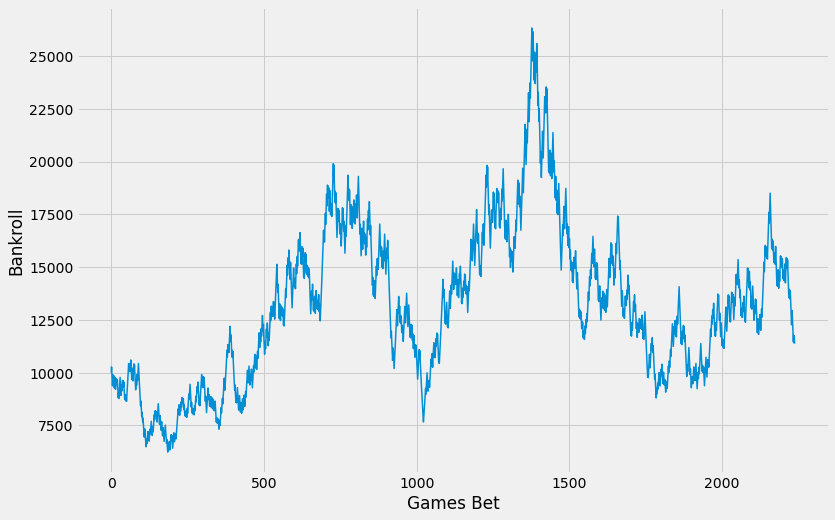

min balance: 6237.822385174462 
max balance: 26324.98186723401 
final balance: 11688.100630439509 
win percentage 53.22


index   GAME_ID MATCHUP_home  spread_home   ml_home    ml_away  \
0         0  21400073  PHI vs. CHI         10.0  5.500000   1.166667   
1         1  21400077  TOR vs. WAS         -4.0  1.588235   2.500000   
2         2  21400078  OKC vs. MEM          7.0  3.600000   1.307692   
3         3  21400079  PHX vs. SAC         -5.0  1.487805   2.750000   
4         5  21400082  LAC vs. POR         -4.5  1.526316   2.650000   
...     ...       ...          ...          ...       ...        ...   
2233   3663  41600303  CLE vs. BOS        -16.0  1.025000  14.500000   
2234   3664  41600314  SAS vs. GSW         11.0  5.500000   1.133333   
2235   3665  41600304  CLE vs. BOS        -15.5  1.035088  11.000000   
2236   3666  41600305  BOS vs. CLE         10.0  4.900000   1.172414   
2237   3667  41600401  GSW vs. CLE         -7.5  1.277778   3.400000   

      point_diff_home  cover_home  diff_preds_home  diff_preds_away  \
0                  -3           1        -5.031264         4.639786   
1                  19           1         1.986305        -2.198826   
2                  -2           1        -9.066415         8.944888   
3                  -2           0         7.657300        -7.720959   
4                   4           0         0.053551        -0.245375   
...               ...         ...              ...              ...   
2233               -3           0        12.355262       -13.825692   
2234              -14           0        -7.833709         7.223131   
2235               13           0        12.255196       -13.246201   
2236              -33           0        -6.555289         6.385360   
2237               22           1         8.471936        -8.474034   

      point_diff_avg  bet_home1  bet_home2  bet_home3  confidence_pred1  \
0          -4.835525          1          1          1          4.968736   
1           2.092565          0          0          0         -2.013695   
2          -9.005651          0          0          0         -2.066415   
3           7.689129          1          1          1          2.657300   
4           0.149463          0          0          0         -4.446449   
...              ...        ...        ...        ...               ...   
2233       13.090477          0          0          0         -3.644738   
2234       -7.528420          1          1          1          3.166291   
2235       12.750699          0          0          0         -3.244804   
2236       -6.470325          1          1          1          3.444711   
2237        8.472985          1          1          1          0.971936   

      confidence_pred2  confidence_pred3    bankroll_i    bankroll_n  \
0             5.360214          5.164475  10000.000000  10272.727273   
1            -1.801174         -1.907435  10272.727273   9964.545455   
2            -1.944888         -2.005651   9964.545455   9665.609091   
3             2.720959          2.689129   9665.609091   9375.640818   
4            -4.254625         -4.350537   9375.640818   9631.340113   
...                ...               ...           ...           ...   
2233         -2.174308         -2.909523  11458.907101  11771.422749   
2234          3.776869          3.471580  11771.422749  11418.280067   
2235         -2.253799         -2.749301  11418.280067  11729.687705   
2236          3.614640          3.529675  11729.687705  11377.797074   
2237          0.974034          0.972985  11377.797074  11688.100630   

        bet_size  bet_won  
0     300.000000        1  
1     308.181818        0  
2     298.936364        0  
3     289.968273        0  
4     281.269225        1  
...          ...      ...  
2233  343.767213        1  
2234  353.142682        0  
2235  342.548402        1  
2236  351.890631        0  
2237  341.333912        1  

[2238 rows x 21 columns]

In [143]:
lr_pipeline_diff = Pipeline([('scaler', StandardScaler()),
                    ('linreg', LinearRegression())])

lr_pipeline_diff.fit(X_train1, point_diff_train1)


diff_preds_lr = lr_pipeline_diff.predict(X_test1)

mae_diff = mean_absolute_error(point_diff_test1, diff_preds_lr)

print("mae_diff:", mae_diff)

select_bets_lr, bet_thresholds_lr = find_optimal_confidence_thresholds(df_19, diff_preds_lr, test_idx1)
simulate_bets(select_bets_lr)

mae_diff_train: 9.177305772240679 mae_diff_test: 9.83073234498658
Train Betting Overall Accuracy: 0.5372458703939009
Test Betting Overall Accuracy: 0.5117233294255569


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


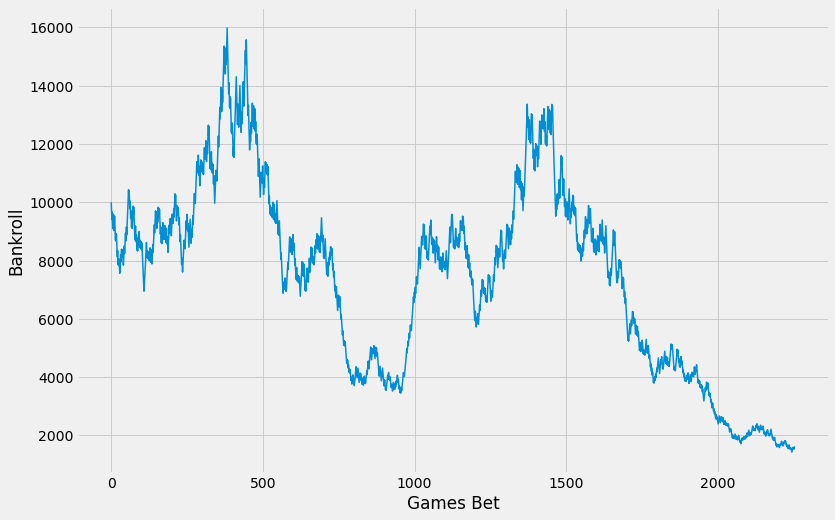

min balance: 1427.3346057354015 
max balance: 15983.12022180355 
final balance: 1665.541009597417 
win percentage 51.71


index   GAME_ID MATCHUP_home  spread_home   ml_home   ml_away  \
0         1  21700080  MEM vs. HOU         -2.0  1.800000  2.050000   
1         2  21700081  DAL vs. PHI          1.0  2.000000  1.833333   
2         3  21700082  UTA vs. LAL        -11.0  1.181818  5.160000   
3         4  21700083  POR vs. PHX        -12.0  1.133333  6.000000   
4         6  21700086  IND vs. SAS          6.5  3.110000  1.357143   
...     ...       ...          ...          ...       ...       ...   
2248   3485  41900304  MIA vs. BOS          3.5  2.380000  1.588235   
2249   3487  41900305  BOS vs. MIA         -3.5  1.591716  2.350000   
2250   3489  41900306  MIA vs. BOS          3.0  2.200000  1.714286   
2251   3492  41900403  MIA vs. LAL          9.5  4.300000  1.210526   
2252   3495  41900406  MIA vs. LAL          5.5  3.100000  1.400000   

      team_score_home  team_score_away  point_diff_home  cover_home  \
0                 103               89               14           1   
1                 110              112               -2           0   
2                  96               81               15           1   
3                 114              107                7           0   
4                  97               94                3           1   
...               ...              ...              ...         ...   
2248              112              109                3           1   
2249              121              108               13           1   
2250              125              113               12           1   
2251              115              104               11           1   
2252               93              106              -13           0   

      diff_preds_home  diff_preds_away  point_diff_avg  bet_home1  bet_home2  \
0           -0.024727         0.093454       -0.059090          0          0   
1            1.559369        -1.290059        1.424714          1          1   
2           12.732257       -12.856618       12.794438          1          1   
3           13.384727       -13.927281       13.656004          1          1   
4           -7.611072         7.532975       -7.572023          0          0   
...               ...              ...             ...        ...        ...   
2248         0.358225         0.335218        0.011504          1          1   
2249         2.022239        -1.137004        1.579622          0          0   
2250        -0.416734         1.298191       -0.857463          1          1   
2251        -7.933505         8.492840       -8.213172          1          1   
2252        -6.009517         6.594896       -6.302207          0          0   

      bet_home3  confidence_pred1  confidence_pred2  confidence_pred3  \
0             0         -2.024727         -2.093454         -2.059090   
1             1          2.559369          2.290059          2.424714   
2             1          1.732257          1.856618          1.794438   
3             1          1.384727          1.927281          1.656004   
4             0         -1.111072         -1.032975         -1.072023   
...         ...               ...               ...               ...   
2248          1          3.858225          3.164782          3.511504   
2249          0         -1.477761         -2.362996         -1.920378   
2250          1          2.583266          1.701809          2.142537   
2251          1          1.566495          1.007160          1.286828   
2252          0         -0.509517         -1.094896         -0.802207   

        bankroll_i   bankroll_n    bet_size  bet_won  
0     10000.000000  9700.000000  300.000000        0  
1      9700.000000  9409.000000  291.000000        0  
2      9409.000000  9665.609091  282.270000        1  
3      9665.609091  9375.640818  289.968273        0  
4      9375.640818  9094.371594  281.269225        0  
...            ...          ...         ...      ...  
2248   1541.844454  1583.894757   46.255334        1  
2249   1583.894757  15

In [144]:
lr_pipeline_diff = Pipeline([('scaler', StandardScaler()),
                    ('linreg', LinearRegression())])

lr_pipeline_diff.fit(X_train2, point_diff_train2)


diff_preds_lr2_train = lr_pipeline_diff.predict(X_train2)
diff_preds_lr2 = lr_pipeline_diff.predict(X_test2)

mae_diff_train = mean_absolute_error(point_diff_train2, diff_preds_lr2_train)
mae_diff_test = mean_absolute_error(point_diff_test2, diff_preds_lr2)

print("mae_diff_train:", mae_diff_train, "mae_diff_test:", mae_diff_test)

bets_train = create_betting_df(df_19, diff_preds_lr2_train, train_idx2, 3)
print("Train Betting Overall Accuracy:", bets_train['bet_won'].mean())


bets_test = create_betting_df(df_19, diff_preds_lr2, test_idx2, 3)
print("Test Betting Overall Accuracy:", bets_test['bet_won'].mean())


select_bets = bets_test.loc[abs(bets_test['confidence_pred3']) > 0.8] 
simulate_bets(select_bets)

In [145]:
lr_feature_names = X_train1.columns
lr_diff_coefs = lr_pipeline_diff.named_steps['linreg'].coef_

coef_df = pd.DataFrame({'feature':lr_feature_names,
                       'lr_diff_coef':lr_diff_coefs})
coef_df.sort_values('lr_diff_coef', ascending=False)

feature  lr_diff_coef
101       PTS_team_y  4.396928e+13
12        REB_team_x  3.367086e+13
6        FG3M_team_x  3.249865e+13
94       DREB_team_y  2.885703e+13
71    REB_PCT_team_x  2.814572e+13
..               ...           ...
18        PTS_team_x -3.312055e+13
67   OREB_PCT_team_x -4.054662e+13
70    DREB_PCT_opp_x -4.054662e+13
87       FG2M_team_y -4.199270e+13
89       FG3M_team_y -5.673588e+13

[164 rows x 2 columns]

#### Linear Regression RFE

In [ ]:
scaler = StandardScaler()
X_train1_sc = scaler.fit_transform(X_train1)
X_test1_sc = scaler.transform(X_test1)

lr = LinearRegression()

rfe_lr = RFECV(lr, cv=tscv, scoring='neg_mean_absolute_error')
rfe_lr.fit(X_train1_sc, point_diff_train1)

In [ ]:
lr_pipeline_diff_reduced = Pipeline([('scaler', StandardScaler()),
                    ('linreg', LinearRegression())])

lr_pipeline_diff_reduced.fit(X_train1.loc[:, rfe_lr.support_], point_diff_train1)


diff_preds_lr_reduced = lr_pipeline_diff_reduced.predict(X_test1.loc[:, rfe_lr.support_])

mae_diff = mean_absolute_error(point_diff_test1, diff_preds)

print("mae_diff:", mae_diff, "mae_score:", mae_score)

select_bets_lr, bet_thresholds_lr = find_optimal_confidence_thresholds(diff_preds_lr_reduced, score_preds_lr, test_idx1)
simulate_bets(select_bets_lr)

In [ ]:
lr_pipeline_diff_reduced = Pipeline([('scaler', StandardScaler()),
                    ('linreg', LinearRegression())])

lr_pipeline_diff_reduced.fit(X_train2.loc[:, rfe_lr.support_], point_diff_train2)


diff_preds_lr2_reduced = lr_pipeline_diff_reduced.predict(X_test2.loc[:, rfe_lr.support_])

mae_diff = mean_absolute_error(point_diff_test2, diff_preds_lr2_reduced)

print("mae_diff:", mae_diff)

bets = create_betting_df(final_df_ewm_19, diff_preds_lr2_reduced, score_preds_lr2, test_idx2, 2)
select_bets = bets.loc[abs(bets['confidence_pred2']) >2.1]    
simulate_bets(select_bets)

In [ ]:
lr_feature_names = X_train1.loc[:, rfe_lr.support_].columns
lr_diff_coefs = lr_pipeline_diff_reduced.named_steps['linreg'].coef_

coef_df = pd.DataFrame({'feature':lr_feature_names,
                       'lr_diff_coef':lr_diff_coefs})
coef_df.sort_values('lr_diff_coef', ascending=False)

### SGD

In [658]:
tscv = TimeSeriesSplit()

best_sgd_diff: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=0.011296898377814803, epsilon=2.0,
                              l1_ratio=1, loss='huber', max_iter=5000,
                              penalty='elasticnet'))])


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


DONE
best threshold: 0.9
best prediction strat: 2
num_games_bet: 1330
win percetange at threshold: 0.5496240601503759


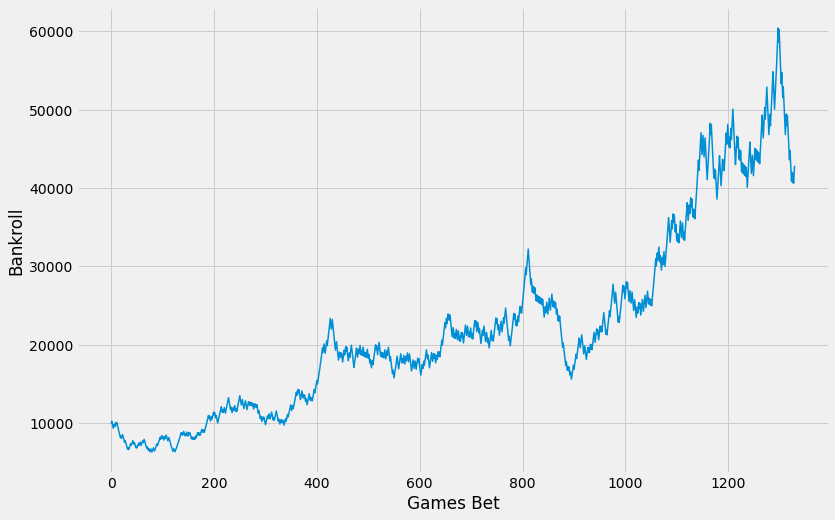

min balance: 6339.336788337162 
max balance: 60399.96205201899 
final balance: 41548.76900877616 
win percentage 54.96


index   GAME_ID MATCHUP_home  spread_home   ml_home    ml_away  \
0         0  21400073  PHI vs. CHI         10.0  5.500000   1.166667   
1         3  21400079  PHX vs. SAC         -5.0  1.487805   2.750000   
2         4  21400080  UTA vs. DAL          3.0  2.300000   1.666667   
3         5  21400082  LAC vs. POR         -4.5  1.526316   2.650000   
4         6  21400083  IND vs. WAS          3.5  2.400000   1.625000   
...     ...       ...          ...          ...       ...        ...   
1325   3665  41600304  CLE vs. BOS        -15.5  1.035088  11.000000   
1326   3666  41600305  BOS vs. CLE         10.0  4.900000   1.172414   
1327   3667  41600401  GSW vs. CLE         -7.5  1.277778   3.400000   
1328   3668  41600402  GSW vs. CLE         -9.0  1.250000   4.300000   
1329   3671  41600405  GSW vs. CLE         -9.5  1.250000   3.600000   

      point_diff_home  cover_home  diff_preds_home  diff_preds_away  \
0                  -3           1        -7.661159         7.848075   
1                  -2           0         6.249566        -7.220022   
2                 -23           0        -2.602016         1.185691   
3                   4           0         4.997839        -5.418047   
4                  -7           0        -4.947155         4.951610   
...               ...         ...              ...              ...   
1325               13           0        12.257301       -13.652887   
1326              -33           0        -8.382691         6.865835   
1327               22           1         7.142380        -8.662829   
1328               19           1         8.886871       -10.457063   
1329                9           0         8.728300       -11.181789   

      point_diff_avg  bet_home1  bet_home2  bet_home3  confidence_pred1  \
0          -7.754617          1          1          1          2.338841   
1           6.734794          1          1          1          1.249566   
2          -1.893853          1          1          1          0.397984   
3           5.207943          1          1          1          0.497839   
4          -4.949383          0          0          0         -1.447155   
...              ...        ...        ...        ...               ...   
1325       12.955094          0          0          0         -3.242699   
1326       -7.624263          1          1          1          1.617309   
1327        7.902605          0          1          1         -0.357620   
1328        9.671967          0          1          1         -0.113129   
1329        9.955044          0          1          1         -0.771700   

      confidence_pred2  confidence_pred3    bankroll_i    bankroll_n  \
0             2.151925          2.245383  10000.000000  10272.727273   
1             2.220022          1.734794  10272.727273   9964.545455   
2             1.814309          1.106147   9964.545455   9665.609091   
3             0.918047          0.707943   9665.609091   9375.640818   
4            -1.451610         -1.449383   9375.640818   9631.340113   
...                ...               ...           ...           ...   
1325         -1.847113         -2.544906  40734.033637  41844.961827   
1326          3.134165          2.375737  41844.961827  40589.612973   
1327          1.162829          0.402605  40589.612973  41696.602417   
1328          1.457063          0.671967  41696.602417  42833.782483   
1329          1.681789          0.455044  42833.782483  41548.769009   

         bet_size  bet_won  
0      300.000000        1  
1      308.181818        0  
2      298.936364        0  
3      289.968273        0  
4      281.269225        1  
...           ...      ...  
1325  1222.021009        1  
1326  1255.348855        0  
1327  1217.688389        1  
1328  1250.898073        1  
1329  1285.013474        0  

[1330 rows x 21 columns]

In [1139]:
sgd_pipe_diff = make_pipeline(StandardScaler(), SGDRegressor(loss='huber', max_iter=5000, 
                                                             penalty='elasticnet', l1_ratio=1))

search_spaces = {
    'sgdregressor__alpha':Real(1e-3, 1e+0, prior='log-uniform'),
    'sgdregressor__epsilon':Real(1, 2)
}

sgd_cv_diff = BayesSearchCV(sgd_pipe_diff, search_spaces=search_spaces, scoring='neg_mean_absolute_error', cv=tscv, n_iter=50)


sgd_cv_diff.fit(X_train1, point_diff_train1)

best_sgd_diff = sgd_cv_diff.best_estimator_
print("best_sgd_diff:", best_sgd_diff)

sgd_preds_diff = best_sgd_diff.predict(X_test1)

select_bets_sgd, bet_thresholds_sgd = find_optimal_confidence_thresholds(df_19, sgd_preds_diff,
                                                                               test_idx1)
simulate_bets(select_bets_sgd)



best_sgd_diff: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=1.023292992280754, epsilon=47.0, l1_ratio=1,
                              loss='huber', max_iter=5000,
                              penalty='elasticnet'))])


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


DONE
best threshold: 2.69
best prediction strat: 1
num_games_bet: 79
win percetange at threshold: 0.6329113924050633


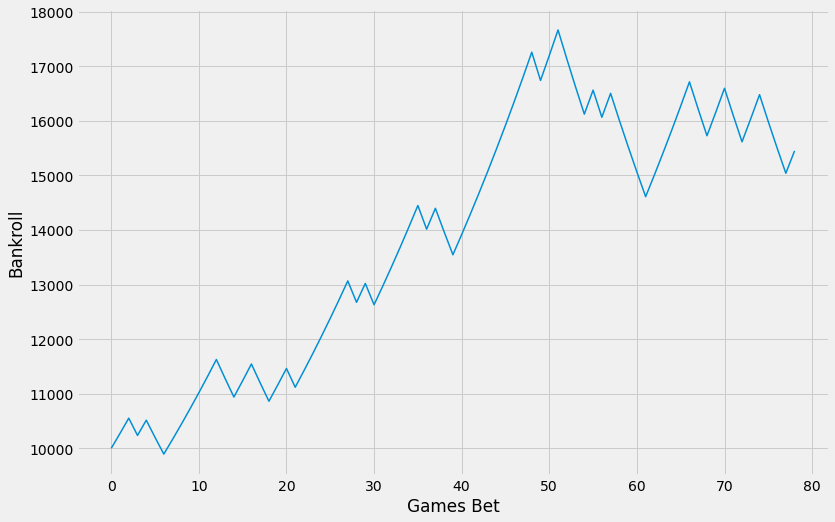

min balance: 9894.013025401953 
max balance: 17667.59103489844 
final balance: 15873.336024547822 
win percentage 63.29


index   GAME_ID MATCHUP_home  spread_home    ml_home    ml_away  \
0      47  21400127  HOU vs. PHI        -16.5   1.018198  15.000000   
1     197  21400277  PHI vs. OKC         14.0  10.000000   1.071429   
2     225  21400305  MIN vs. GSW         14.5  11.000000   1.040000   
3     372  21400452  GSW vs. MIN        -19.0   1.016667  10.000000   
4     394  21400474  GSW vs. PHI        -18.0   1.014286  18.500000   
5     422  21400502  LAC vs. PHI        -19.5   1.010000  24.250000   
6     498  21400578  TOR vs. PHI        -18.0   1.020000   6.950000   
7     581  21400661  ATL vs. MIN        -17.5   1.014286  18.500000   
8     585  21400665  GSW vs. BOS        -18.0   1.014286  20.000000   
9     636  21400718  CLE vs. PHI        -17.0   1.025000  15.000000   
10    678  21400760  NYK vs. GSW         15.5  14.500000   1.033333   
11    692  21400775  PHI vs. GSW         16.0  14.810000   1.034247   
12    738  21400821  NYK vs. CLE         17.0  15.000000   1.025000   
13    898  21400981  GSW vs. NYK        -19.0   1.011111  21.000000   
14    916  21400999  GSW vs. LAL        -18.5   1.014286  20.000000   
15    918  21401001  NYK vs. SAS         14.5  11.000000   1.037037   
16    978  21401061  NYK vs. LAC         15.0  14.500000   1.033333   
17   1005  21401088  CHI vs. NYK        -17.5   1.014286  19.000000   
18   1009  21401092  CLE vs. PHI        -17.0   1.025000  15.000000   
19   1077  21401159  LAC vs. LAL        -16.5   1.020000  18.000000   
20   1090  21401172  POR vs. MIN        -16.5   1.020000  15.650000   
21   1110  21401192  GSW vs. MIN        -19.5   1.014085  18.000000   
22   1118  21401200  SAS vs. PHX        -17.0   1.025000  15.000000   
23   1126  21401208  MIN vs. NOP         14.5  11.000000   1.050000   
24   1131  21401213  LAC vs. DEN        -18.0   1.020000  18.000000   
25   1234  21500083  GSW vs. DEN        -17.5   1.014286  18.500000   
26   1294  21500144  GSW vs. BKN        -16.5   1.025000  15.000000   
27   1364  21500214  GSW vs. LAL        -17.0   1.020000  18.000000   
28   1547  21500397  GSW vs. MIL        -19.0   1.010000  22.750000   
29   1548  21500398  OKC vs. LAL        -16.5   1.020000  18.000000   
30   1606  21500456  OKC vs. DEN        -16.5   1.020000  18.000000   
31   1638  21500488  OKC vs. PHX        -16.0   1.025000  14.750000   
32   1685  21500549  LAL vs. OKC         15.5  14.250000   1.033333   
33   1695  21500559  PHI vs. CLE         16.5  18.000000   1.020000   
34   1728  21500592  GSW vs. LAL        -18.5   1.025806  23.250000   
35   1780  21500644  PHX vs. SAS         16.5  16.000000   1.020000   
36   1789  21500653  LAL vs. SAS         16.0  13.000000   1.022222   
37   1819  21500684  CLE vs. PHX        -17.5   1.014286  21.000000   
38   1826  21500691  GSW vs. DAL        -18.0   1.021978  13.500000   
39   1842  21500707  PHI vs. GSW         17.0  18.000000   1.020000   
40   1898  21500767  SAS vs. LAL        -17.0   1.025000  15.000000   
41   1930  21500799  PHX vs. GSW         16.0  15.000000   1.025000   
42   2063  21500931  LAL vs. GSW         17.5  21.000000   1.014286   
43   2113  21500981  GSW vs. PHX        -18.5   1.014286  21.000000   
44   2153  21501021  PHI vs. OKC         15.5  16.000000   1.027778   
45   2212  21501080  GSW vs. DAL        -16.5   1.020000  14.500000   
46   2226  21501094  GSW vs. PHI        -22.0   1.008333  21.000000   
47   2250  21501118  SAS vs. NOP        -19.0   1.010000  26.000000   
48   2254  21501122  CLE vs. BKN        -17.0   1.020000  15.500000   
49   2258  21501126  OKC vs. LAC        -17.0   1.020000  15.500000   
50   2318  21501187  UTA vs. LAC        -13.5   1.076923   8.500000   
51   2358  21501227  GSW vs. MEM        -17.5   1.013641  16.000000   
52   2368  41500151  SAS vs. MEM        -17.5   1.020000  18.000000   
53   2374  41500152  SAS vs. MEM        -17.5   1.010000  26.000000   
54   2462  21600099  GSW vs. NOP        -16.5   1.020000  14.000000   
55   2478  21600116  GSW vs.

In [1191]:
sgd_pipe_diff = make_pipeline(StandardScaler(), SGDRegressor(loss='huber', max_iter=5000, 
                                                             alpha=1.023292992280754,
                                                             penalty='elasticnet',l1_ratio=1))

param_grid = {
#     'sgdregressor__alpha':np.logspace(1e-2, 2, 20),
    'sgdregressor__epsilon':np.linspace(40, 70, 31),
}

sgd_cv_diff = GridSearchCV(sgd_pipe_diff, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=tscv)


sgd_cv_diff.fit(X_train1, point_diff_train1)

best_sgd_diff = sgd_cv_diff.best_estimator_
print("best_sgd_diff:", best_sgd_diff)

sgd_preds_diff = best_sgd_diff.predict(X_test1)

select_bets_sgd, bet_thresholds_sgd = find_optimal_confidence_thresholds(df_19, sgd_preds_diff,
                                                                               test_idx1)
simulate_bets(select_bets_sgd)



In [1194]:
create_betting_df(df_19, sgd_preds_diff, test_idx1, 3)
bet_thresholds_sgd

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


index  prediction_num  confidence_thresholds  num_games_bet  \
0      268               1                   2.69             79   
1     2264               3                   2.65            105   
2      267               1                   2.68             80   
3     1233               2                   2.34            267   
4     1248               2                   2.49            204   
..     ...             ...                    ...            ...   
537   1351               2                   3.52             11   
538   1352               2                   3.53             11   
539    316               1                   3.17             13   
540    317               1                   3.18             13   
541    318               1                   3.19             13   

     win_percentage  expected_profits  
0          0.632911              1868  
1          0.600000              1764  
2          0.625000              1760  
3          0.550562              1740  
4          0.558824              1680  
..              ...               ...  
537        0.545455                60  
538        0.545455                60  
539        0.538462                52  
540        0.538462                52  
541        0.538462                52  

[542 rows x 6 columns]

In [1193]:
pd.DataFrame(sgd_cv_diff.cv_results_).sort_values('rank_test_score')

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
7        0.216193      0.106406         0.006400        0.000490   
1        0.240595      0.124292         0.006598        0.000488   
30       0.275191      0.170311         0.006401        0.000490   
22       0.264794      0.126935         0.006398        0.000487   
0        0.262591      0.146966         0.006398        0.000487   
16       0.242796      0.093024         0.006597        0.000494   
4        0.247995      0.109827         0.006199        0.000401   
24       0.283591      0.160462         0.006400        0.000800   
5        0.241598      0.117062         0.006195        0.000397   
27       0.321999      0.188408         0.006392        0.000491   
12       0.302793      0.109338         0.006998        0.000636   
29       0.260192      0.098548         0.007600        0.001743   
9        0.250995      0.141895         0.007197        0.000981   
20       0.306591      0.135649         0.006200        0.000400   
8        0.280594      0.163043         0.006998        0.000892   
19       0.256441      0.156387         0.007001        0.000633   
23       0.263992      0.134543         0.008400        0.003323   
13       0.241996      0.115963         0.007198        0.000749   
10       0.258192      0.088721         0.006600        0.000490   
11       0.313794      0.182450         0.006196        0.000402   
25       0.313194      0.171068         0.006596        0.000491   
14       0.252395      0.124865         0.006597        0.000488   
17       0.233993      0.095542         0.006800        0.000980   
28       0.265192      0.140842         0.007800        0.001833   
2        0.213796      0.103521         0.006397        0.000492   
21       0.227995      0.093045         0.006598        0.000492   
26       0.252192      0.134751         0.006600        0.000800   
15       0.208993      0.092195         0.006400        0.000490   
18       0.231195      0.094689         0.006398        0.000492   
3        0.236198      0.109961         0.006395        0.000490   
6        0.283596      0.146997         0.007995        0.003035   

   param_sgdregressor__epsilon                           params  \
7                           47  {'sgdregressor__epsilon': 47.0}   
1                           41  {'sgdregressor__epsilon': 41.0}   
30                          70  {'sgdregressor__epsilon': 70.0}   
22                          62  {'sgdregressor__epsilon': 62.0}   
0                           40  {'sgdregressor__epsilon': 40.0}   
16                          56  {'sgdregressor__epsilon': 56.0}   
4                           44  {'sgdregressor__epsilon': 44.0}   
24                          64  {'sgdregressor__epsilon': 64.0}   
5                           45  {'sgdregressor__epsilon': 45.0}   
27                          67  {'sgdregressor__epsilon': 67.0}   
12                          52  {'sgdregressor__epsilon': 52.0}   
29                          69  {'sgdregressor__epsilon': 69.0}   
9                           49  {'sgdregressor__epsilon': 49.0}   
20                          60  {'sgdregressor__epsilon': 60.0}   
8                           48  {'sgdregressor__epsilon': 48.0}   
19                          59  {'sgdregressor__epsilon': 59.0}   
23                          63  {'sgdregressor__epsilon': 63.0}   
13                          53  {'sgdregressor__epsilon': 53.0}   
10                          50  {'sgdregressor__epsilon': 50.0}   
11                          51  {'sgdregressor__epsilon': 51.0}   
25                          65  {'sgdregressor__epsilon': 65.0}   
14                          54  {'sgdregressor__epsilon': 54.0}   
17                          57  {'sgdregressor__epsilon': 57.0}   
28                          68  {'sgdregressor__epsilon': 68.0}   
2                           42  {'sgdregressor__epsilon': 42.0}   
21                          61  {'sgdregressor__epsilon': 61.0}   
26                

best_sgd_diff: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=0.0152901018913017,
                              epsilon=4.274527103079441, loss='huber',
                              max_iter=5000, penalty='l1'))])
Train Betting Overall Accuracy: 0.5317662007623888
Test Betting Overall Accuracy: 0.5137749120750293
mae_diff_train: 9.19329597375878 mae_diff_test: 9.781952375368961


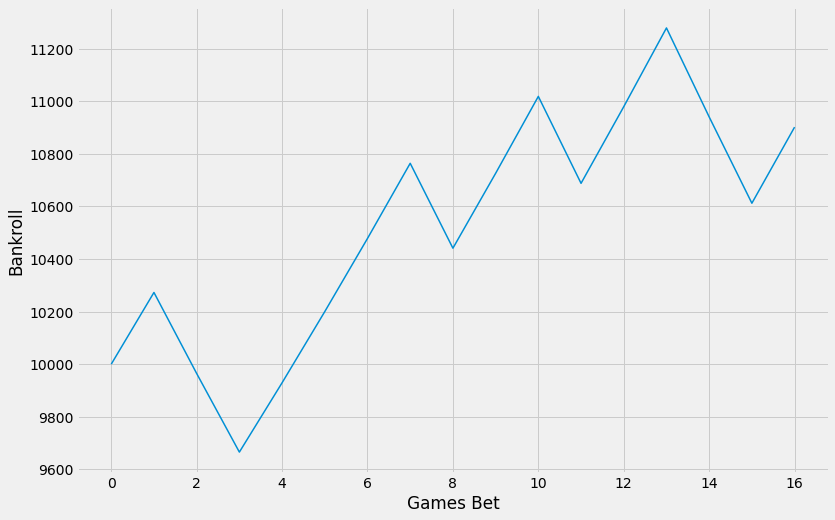

min balance: 9665.60909090909 
max balance: 11278.692647791815 
final balance: 10574.497116436412 
win percentage 58.81999999999999


index   GAME_ID MATCHUP_home  spread_home   ml_home   ml_away  \
0      10  21700091  GSW vs. DET        -14.5  1.062500  8.500000   
1      24  21700105  CHA vs. MIL         -4.0  1.588235  2.500000   
2     116  21700197  UTA vs. MIN          3.0  2.250000  1.689655   
3    1243  21800094  SAS vs. DAL         -7.0  1.333333  3.500000   
4    1535  21800386  LAC vs. MIA         -9.5  1.175439  5.000000   
5    2415  41800165  POR vs. OKC         -4.5  1.555556  2.550000   
6    2417  41800175  HOU vs. UTA         -8.5  1.270270  3.960000   
7    2479  21900095  PHX vs. PHI          0.0  1.833333  1.833333   
8    2507  21900123  DEN vs. PHI         -5.0  1.476190  2.750000   
9    2509  21900125  POR vs. BKN         -4.0  1.606061  2.450000   
10   2535  21900151  PHX vs. LAL          3.5  2.400000  1.571429   
11   2558  21900174  LAL vs. SAC        -10.5  1.153846  5.250000   
12   3198  21900844  DEN vs. MIN        -14.5  1.052002  9.500000   
13   3208  21900854  DAL vs. MIN        -14.0  1.076923  8.900000   
14   3279  21900925  POR vs. WAS         -8.0  1.285714  3.750000   
15   3292  21900938  PHX vs. POR          3.5  2.440000  1.571429   
16   3319  21900966  POR vs. PHX         -6.5  1.377358  3.000000   

    team_score_home  team_score_away  point_diff_home  cover_home  \
0               107              115               -8           0   
1               126              121                5           1   
2                98              109              -11           0   
3               113              108                5           0   
4                98              121              -23           0   
5               118              115                3           0   
6               100               93                7           0   
7               114              109                5           1   
8               100               97                3           0   
9               115              119               -4           0   
10              115              123               -8           0   
11               99               97                2           0   
12              128              116               12           0   
13              139              123               16           1   
14              125              104               21           1   
15              127              117               10           1   
16              121              105               16           1   

    diff_preds_home  diff_preds_away  point_diff_avg  bet_home1  bet_home2  \
0         11.364752       -12.321160       11.842956          0          0   
1          0.400983        -0.945840        0.673411          0          0   
2          0.302474        -0.047940        0.175207          1          1   
3          4.386846        -3.373471        3.880158          0          0   
4          6.570031        -6.705729        6.637880          0          0   
5          1.308806        -2.309369        1.809088          0          0   
6          4.428633        -6.132121        5.280377          0          0   
7         -2.260036         3.141594       -2.700815          0          0   
8          1.430117        -1.534515        1.482316          0          0   
9          0.520203        -1.879448        1.199825          0          0   
10        -0.708454         0.713871       -0.711162          1          1   
11         7.534195        -7.902062        7.718129          0          0   
12        11.539562       -11.576733       11.558148          0          0   
13        10.954387       -11.216784       11.085586          0          0   
14         4.717485        -4.730689        4.724087          0          0   
15        -0.859615         0.595623       -0.727619          1          1   
16         3.722987        -3.821062        3.772025          0          0   

    bet_home3  confidence_pred1  confidence_pred2  confidence_pred3  \
0           0         -3.135248         -2

In [231]:
sgd_pipe_diff = make_pipeline(StandardScaler(), SGDRegressor(loss='huber', max_iter=5000, 
                                                             penalty='l1'))

search_spaces = {
    'sgdregressor__alpha':Real(1e-3, 1e+0, prior='log-uniform'),
    'sgdregressor__epsilon':Real(1, 10)
}

sgd_cv_diff = BayesSearchCV(sgd_pipe_diff, search_spaces=search_spaces, scoring='neg_mean_absolute_error', cv=tscv, n_iter=50)


sgd_cv_diff.fit(X_train2, point_diff_train2)

best_sgd_diff = sgd_cv_diff.best_estimator_
print("best_sgd_diff:", best_sgd_diff)


best_sgd_diff.fit(X_train2, point_diff_train2)

diff_preds_sgd2_train = best_sgd_diff.predict(X_train2)

diff_preds_sgd2 = best_sgd_diff.predict(X_test2)

mae_diff_train = mean_absolute_error(point_diff_train2, diff_preds_sgd2_train)
mae_diff_test = mean_absolute_error(point_diff_test2, diff_preds_sgd2)

bets_train = create_betting_df(df_19, diff_preds_sgd2_train, train_idx2, 3)
print("Train Betting Overall Accuracy:", bets_train['bet_won'].mean())


bets_test = create_betting_df(df_19, diff_preds_sgd2, test_idx2, 3)
print("Test Betting Overall Accuracy:", bets_test['bet_won'].mean())


print("mae_diff_train:", mae_diff_train, "mae_diff_test:", mae_diff_test)

bets = create_betting_df(df_19, diff_preds_sgd2, test_idx2, 3)
select_bets = bets.loc[abs(bets['confidence_pred3']) > 2.65]    
simulate_bets(select_bets)


<AxesSubplot:ylabel='feature'>

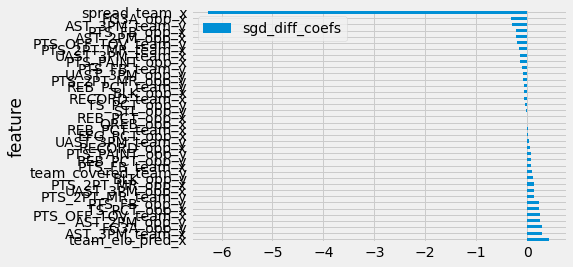

In [232]:
feature_names = X_train1.columns
sgd_diff_coefs = best_sgd_diff.named_steps['sgdregressor'].coef_

coef_df_sgd = pd.DataFrame({'feature':feature_names,
                       'sgd_diff_coefs':sgd_diff_coefs
                           })
coef_df_sgd.loc[coef_df_sgd['sgd_diff_coefs']!=0].sort_values('sgd_diff_coefs', ascending=False).plot.barh(x='feature')

#### SGD RFE

In [867]:
scaler = StandardScaler()
X_train1_sc = scaler.fit_transform(X_train1)
X_test1_sc = scaler.transform(X_test1)

best_sgd_diff= SGDRegressor(alpha=0.007847599703514606, epsilon=1.27427,
                              l1_ratio=1.0, loss='huber', max_iter=5000,
                              penalty='elasticnet')

rfe_sgd = RFECV(best_sgd_diff, cv=tscv, scoring='neg_mean_absolute_error')
rfe_sgd.fit(X_train1_sc, point_diff_train1)


RFECV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
      estimator=SGDRegressor(alpha=0.007847599703514606, epsilon=1.27427,
                             l1_ratio=1.0, loss='huber', max_iter=5000,
                             penalty='elasticnet'),
      scoring='neg_mean_absolute_error')

mae_diff_sgd_reduced: 13.483472170841289


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


DONE
best threshold: 1.25
best prediction strat: 2
num_games_bet: 454
win percetange at threshold: 0.5440528634361234


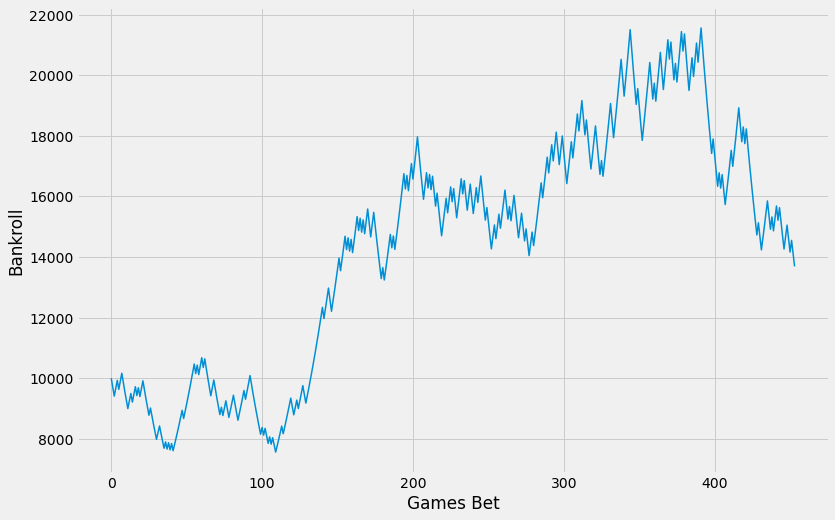

min balance: 7560.705293314098 
max balance: 21564.898338453335 
final balance: 14064.726761039305 
win percentage 54.410000000000004


index   GAME_ID MATCHUP_home  spread_home   ml_home  ml_away  \
0       11  21600096  CHI vs. ORL         -7.0  1.333333     3.40   
1       12  21600097  OKC vs. MIA         -5.5  1.425532     2.95   
2       14  21600099  GSW vs. NOP        -16.5  1.020000    14.00   
3       18  21600104  LAL vs. DAL         -4.0  1.571429     2.55   
4       20  21600106  NYK vs. BKN         -8.0  1.277778     3.80   
..     ...       ...          ...          ...       ...      ...   
449   2440  41700313  GSW vs. HOU         -7.5  1.250000     3.85   
450   2442  41700314  GSW vs. HOU         -7.5  1.232558     4.40   
451   2445  41700306  CLE vs. BOS         -7.0  1.322581     3.50   
452   2446  41700316  GSW vs. HOU        -12.5  1.094340     6.50   
453   2449  41700401  GSW vs. CLE        -13.0  1.100000     7.20   

     team_score_home  team_score_away  point_diff_home  cover_home  \
0                112               80               32           1   
1                 97               85               12           1   
2                116              106               10           0   
3                 97              109              -12           0   
4                110               96               14           1   
..               ...              ...              ...         ...   
449              126               85               41           1   
450               92               95               -3           0   
451              109               99               10           1   
452              115               86               29           1   
453              124              114               10           0   

     score_pred_home  score_pred_away  score_pred_diff  diff_preds_home  \
0         100.075529       105.306658        -5.231129         5.235371   
1         101.156827       101.580772        -0.423945         4.211420   
2         102.447470       105.595805        -3.148336        14.129172   
3         105.568476       101.949743         3.618733         1.200852   
4         104.692782       110.632741        -5.939959         6.739925   
..               ...              ...              ...              ...   
449       104.091055       107.778061        -3.687006         5.412862   
450       101.102738       108.105243        -7.002505         5.846622   
451        97.901593        99.727420        -1.825827         5.531878   
452        98.246613       106.274410        -8.027797         9.869949   
453        97.112530       104.877126        -7.764596        11.569969   

     diff_preds_away  point_diff_avg  bet_home1  bet_home2  bet_home3  \
0          -5.470670        5.353020          0          0          0   
1          -4.503992        4.357706          0          0          0   
2         -14.789008       14.459090          0          0          0   
3          -1.572029        1.386440          0          0          0   
4          -7.189000        6.964463          0          0          0   
..               ...             ...        ...        ...        ...   
449        -6.190781        5.801822          0          0          0   
450        -6.688231        6.267426          0          0          0   
451        -6.075165        5.803521          0          0          0   
452       -10.782762       10.326356          0          0          0   
453       -12.436212       12.003090          0          0          0   

     bet_home4  confidence_pred1  confidence_pred2  confidence_pred3  \
0            0        -12.231129         -1.764629         -1.529330   
1            0         -5.923945         -1.288580         -0.996008   
2            0        -19.648336         -2.370828         -1.710992   
3            0         -0.381267         -2.799148         -2.427971   
4            0        -13.939959         -1.260075         -0.811000   
..         ...               ...               ...               ...   
449          0        -11.187006         -2.087138   

In [872]:
best_sgd_diff_reduced = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=0.007847599703514606, epsilon=1.27427,
                              l1_ratio=1.0, loss='huber', max_iter=5000,
                              penalty='elasticnet'))])

best_sgd_diff_reduced.fit(X_train1.loc[:, rfe_sgd.support_], point_diff_train1)


diff_preds_sgd_reduced = best_sgd_diff_reduced.predict(X_test1.loc[:, rfe_sgd.support_])

mae_diff = mean_absolute_error(point_diff_test1, diff_preds)

print("mae_diff_sgd_reduced:", mae_diff)

select_bets_sgd, bet_thresholds_lr_sgd = find_optimal_confidence_thresholds(diff_preds_sgd_reduced, sgd_preds_score, test_idx1)
simulate_bets(select_bets_sgd)

<AxesSubplot:ylabel='feature'>

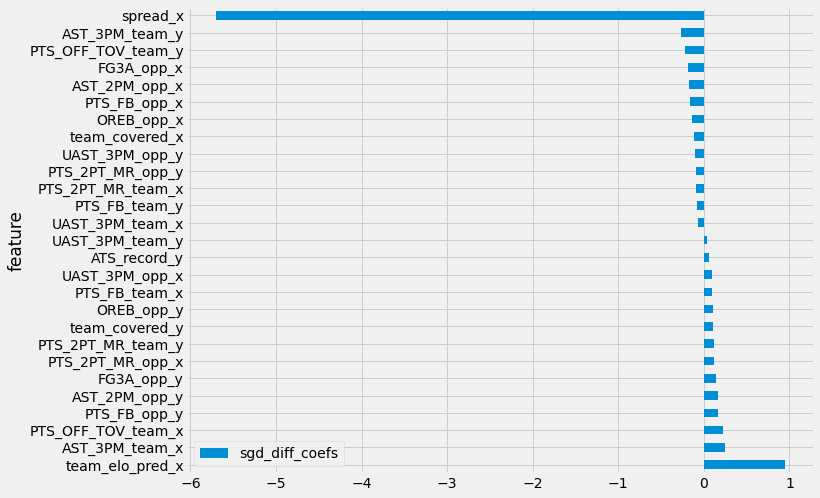

In [874]:
feature_names = X_train1.loc[:, rfe_sgd.support_].columns
sgd_diff_coefs = best_sgd_diff_reduced.named_steps['sgdregressor'].coef_

coef_df_sgd = pd.DataFrame({'feature':feature_names,
                       'sgd_diff_coefs':sgd_diff_coefs})

coef_df_sgd.loc[coef_df_sgd['sgd_diff_coefs']!=0].sort_values('sgd_diff_coefs', ascending=False).plot.barh(figsize=(10,8), x='feature')

mae_diff: 9.933691663701811


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


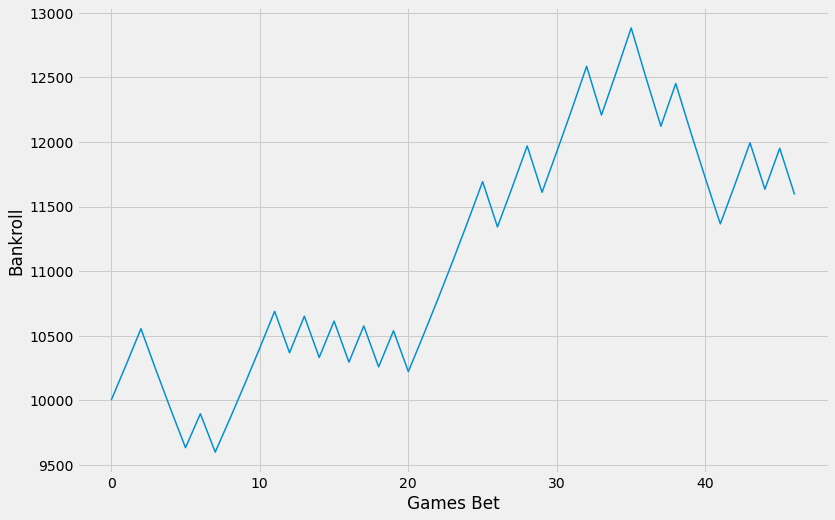

min balance: 9597.192634639892 
max balance: 12883.481930176657 
final balance: 11244.759210318141 
win percentage 57.45


index   GAME_ID MATCHUP_home  spread_home   ml_home    ml_away  \
0      14  21800094  SAS vs. DAL         -7.0  1.333333   3.500000   
1      71  21800151  PHX vs. BKN          2.5  2.200000   1.714286   
2     115  21800195  MIN vs. BKN         -4.0  1.571429   2.550000   
3     144  21800224  BKN vs. LAC          4.0  2.550000   1.526316   
4     250  21800330  NYK vs. MIL          8.0  4.000000   1.250000   
5     251  21800331  DET vs. GSW          4.5  2.600000   1.476190   
6     297  21800377  MIL vs. GSW         -2.0  1.800000   2.050000   
7     306  21800386  LAC vs. MIA         -9.5  1.175439   5.000000   
8     313  21800393  BOS vs. NOP         -2.5  1.740741   2.150000   
9     335  21800415  GSW vs. TOR         -8.0  1.238095   3.890000   
10    348  21800428  SAC vs. GSW          7.5  3.700000   1.294118   
11    446  21800526  LAL vs. LAC          7.0  3.400000   1.344828   
12    584  21800664  LAC vs. UTA         -1.0  1.869565   1.952381   
13    653  21800733  DEN vs. PHI        -10.5  1.149254   4.750000   
14    718  21800798  IND vs. LAL          2.5  2.200000   1.714286   
15    860  21800940  SAS vs. OKC         -5.0  1.526316   2.650000   
16    928  21801008  PHI vs. CLE        -15.5  1.066667   8.750000   
17    952  21801032  SAS vs. NYK        -13.5  1.083333   8.000000   
18   1149  21801229  LAC vs. UTA         -8.0  1.294118   3.700000   
19   1155  41800101  MIL vs. DET        -15.0  1.047619  11.700000   
20   1251  21900096  GSW vs. POR         11.5  6.500000   1.100000   
21   1255  21900100  CHI vs. LAL          7.0  3.700000   1.294118   
22   1278  21900123  DEN vs. PHI         -5.0  1.476190   2.750000   
23   1280  21900125  POR vs. BKN         -4.0  1.606061   2.450000   
24   1294  21900139  LAL vs. TOR        -10.5  1.161290   4.750000   
25   1306  21900151  PHX vs. LAL          3.5  2.400000   1.571429   
26   1329  21900174  LAL vs. SAC        -10.5  1.153846   5.250000   
27   1356  21900201  LAL vs. OKC        -11.5  1.117647   6.200000   
28   1547  21900406  LAC vs. PHX        -14.5  1.071429   6.560000   
29   1633  21900506  MIL vs. MIN        -18.0  1.020000  13.750000   
30   1707  21900580  OKC vs. LAL         -9.0  1.222222   4.000000   
31   1844  21900719  LAC vs. SAC        -14.5  1.066667   8.000000   
32   1852  21900727  LAC vs. MIN        -10.5  1.153846   5.000000   
33   1907  21900782  MIN vs. LAC         10.0  5.000000   1.165289   
34   1969  21900844  DEN vs. MIN        -14.5  1.052002   9.500000   
35   1979  21900854  DAL vs. MIN        -14.0  1.076923   8.900000   
36   2050  21900925  POR vs. WAS         -8.0  1.285714   3.750000   
37   2063  21900938  PHX vs. POR          3.5  2.440000   1.571429   
38   2082  21900958  DEN vs. MIL         -7.5  1.312500   3.400000   
39   2090  21900966  POR vs. PHX         -6.5  1.377358   3.000000   
40   2118  21901252  WAS vs. IND          8.5  4.150000   1.232558   
41   2140  21901274  SAS vs. UTA         -9.0  1.235294   3.900000   
42   2146  21901280  POR vs. LAC         -4.5  1.282486   2.600000   
43   2149  21901283  MIA vs. PHX          4.0  2.380000   1.571429   
44   2174  21901309  BKN vs. POR         10.5  5.300000   1.151515   
45   2241  41900223  HOU vs. LAL          4.5  2.440000   1.526316   
46   2244  41900224  HOU vs. LAL          5.5  2.750000   1.322581   

    team_score_home  team_score_away  point_diff_home  cover_home  \
0               113              108                5           0   
1                82              104              -22           0   
2               120              113                7           1   
3               119              127               -8           0   
4               136              134                2           1   
5               111              102                9           1   
6                95              105              -10           0   
7                98              121              -23           0   
8               113   

In [876]:
best_sgd_diff_reduced.fit(X_train2.loc[:, rfe_sgd.support_], point_diff_train2)


diff_preds_sgd2_reduced = best_sgd_diff_reduced.predict(X_test2.loc[:, rfe_sgd.support_])

mae_diff = mean_absolute_error(point_diff_test2, diff_preds_sgd2_reduced)

print("mae_diff:", mae_diff)

bets = create_betting_df(final_df_ewm_19, diff_preds_sgd2_reduced, score_preds_sgd2, test_idx2, 2)
select_bets = bets.loc[abs(bets['confidence_pred2']) > 1.5]    
simulate_bets(select_bets)

### Elastic Net

best_en_diff: Pipeline(steps=[('scaler', StandardScaler()),
                ('en',
                 ElasticNet(alpha=0.05374789537976706, l1_ratio=1.0,
                            max_iter=20000))])
mae_diff: 9.6533683426653


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


DONE
best threshold: 5.62
best prediction strat: 1
num_games_bet: 284
win percetange at threshold: 0.5563380281690141


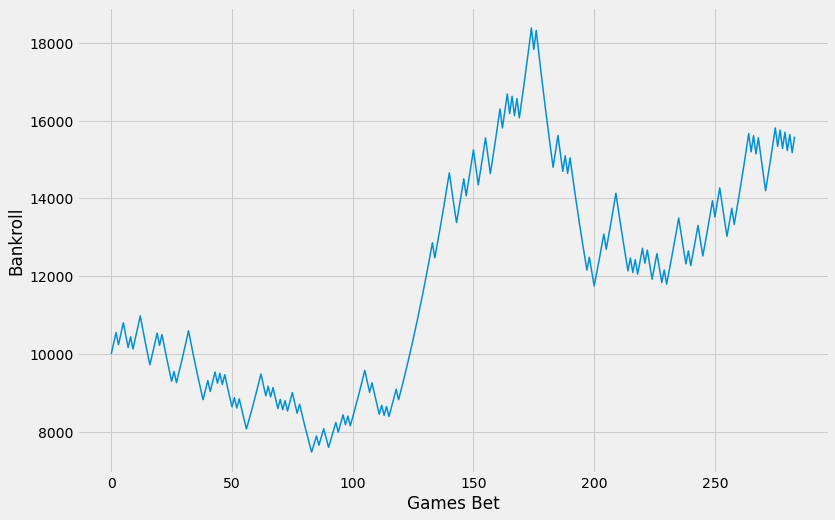

min balance: 7476.543808696233 
max balance: 18383.417075132427 
final balance: 15121.272258147006 
win percentage 55.63


index   GAME_ID MATCHUP_home  spread_home   ml_home    ml_away  \
0        2  21400078  OKC vs. MEM          7.0  3.600000   1.307692   
1       12  21400092  OKC vs. SAC          2.0  2.070000   1.740741   
2       20  21400100  NYK vs. ATL          2.0  2.100000   1.769231   
3       31  21400111  BOS vs. OKC         -7.5  1.303030   3.700000   
4       35  21400115  DEN vs. POR         -2.5  1.666667   2.200000   
..     ...       ...          ...          ...       ...        ...   
279   3661  41600302  BOS vs. CLE          5.0  2.850000   1.465116   
280   3663  41600303  CLE vs. BOS        -16.0  1.025000  14.500000   
281   3664  41600314  SAS vs. GSW         11.0  5.500000   1.133333   
282   3665  41600304  CLE vs. BOS        -15.5  1.035088  11.000000   
283   3666  41600305  BOS vs. CLE         10.0  4.900000   1.172414   

     point_diff_home  cover_home  diff_preds_home  diff_preds_away  \
0                 -2           1        -0.683708         0.681569   
1                  8           1         4.764016        -4.765292   
2                 -6           0         3.720425        -3.719285   
3                -15           0         1.845294        -1.844405   
4                -17           0        -4.480290         4.481163   
..               ...         ...              ...              ...   
279              -44           0         1.099416        -1.101618   
280               -3           0         7.360272        -7.362122   
281              -14           0        -4.468476         4.467763   
282               13           0         6.880841        -6.882443   
283              -33           0        -1.426610         1.425151   

     point_diff_avg  bet_home1  bet_home2  bet_home3  confidence_pred1  \
0         -0.682638          1          1          1          6.316292   
1          4.764654          1          1          1          6.764016   
2          3.719855          1          1          1          5.720425   
3          1.844849          0          0          0         -5.654706   
4         -4.480726          0          0          0         -6.980290   
..              ...        ...        ...        ...               ...   
279        1.100517          1          1          1          6.099416   
280        7.361197          0          0          0         -8.639728   
281       -4.468120          1          1          1          6.531524   
282        6.881642          0          0          0         -8.619159   
283       -1.425881          1          1          1          8.573390   

     confidence_pred2  confidence_pred3    bankroll_i    bankroll_n  \
0            6.318431          6.317362  10000.000000  10272.727273   
1            6.765292          6.764654  10272.727273  10552.892562   
2            5.719285          5.719855  10552.892562  10236.305785   
3           -5.655595         -5.655151  10236.305785  10515.477761   
4           -6.981163         -6.980726  10515.477761  10802.263518   
..                ...               ...           ...           ...   
279          6.101618          6.100517  15700.070894  15229.068767   
280         -8.637878         -8.638803  15229.068767  15644.407006   
281          6.532237          6.531880  15644.407006  15175.074796   
282         -8.617557         -8.618358  15175.074796  15588.940472   
283          8.574849          8.574119  15588.940472  15121.272258   

       bet_size  bet_won  
0    300.000000        1  
1    308.181818        1  
2    316.586777        0  
3    307.089174        1  
4    315.464333        1  
..          ...      ...  
279  471.002127        0  
280  456.872063        1  
281  469.332210        0  
282  455.252244        1  
283  467.668214        0  

[284 rows x 21 columns]

In [158]:
en_pipeline_diff = Pipeline([('scaler', StandardScaler()),
                        ('en', ElasticNet(max_iter=20000))])


search_spaces = {"en__alpha":Real(1e-2, 1e+2, prior='log-uniform'),
         "en__l1_ratio":Real(0.5, 1)}

en_bs_diff = BayesSearchCV(en_pipeline_diff, search_spaces=search_spaces, scoring='neg_mean_absolute_error', cv=tscv)

en_bs_diff.fit(X_train1.iloc[:, 2:], point_diff_train1)

best_en_diff = en_bs_diff.best_estimator_
print("best_en_diff:", best_en_diff)

diff_preds_en = best_en_diff.predict(X_test1.iloc[:, 2:])

mae_diff = mean_absolute_error(point_diff_test1, diff_preds_en)


print("mae_diff:", mae_diff)


select_bets_en, bet_thresholds_en = find_optimal_confidence_thresholds(df_19, diff_preds_en,
                                                                               test_idx1)
simulate_bets(select_bets_en)



In [160]:
X_train2.iloc[:, 2:]

bet_thresholds_en

index  prediction_num  confidence_thresholds  num_games_bet  \
0       561               1                   5.62            284   
1      1561               2                   5.62            284   
2      2561               3                   5.62            284   
3       562               1                   5.63            283   
4      1562               2                   5.63            283   
...     ...             ...                    ...            ...   
1169   1904               2                   9.05             39   
1170   2904               3                   9.05             39   
1171    905               1                   9.06             39   
1172   1905               2                   9.06             39   
1173   2905               3                   9.06             39   

      win_percentage  expected_profits  
0           0.556338              2192  
1           0.556338              2192  
2           0.556338              2192  
3           0.554770              2092  
4           0.554770              2092  
...              ...               ...  
1169        0.538462               156  
1170        0.538462               156  
1171        0.538462               156  
1172        0.538462               156  
1173        0.538462               156  

[1174 rows x 6 columns]

mae_diff_train: 9.212136233903006 mae_diff_test: 9.776650184441985
Train Betting Overall Accuracy: 0.5229510800508259
Test Betting Overall Accuracy: 0.5017584994138335


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

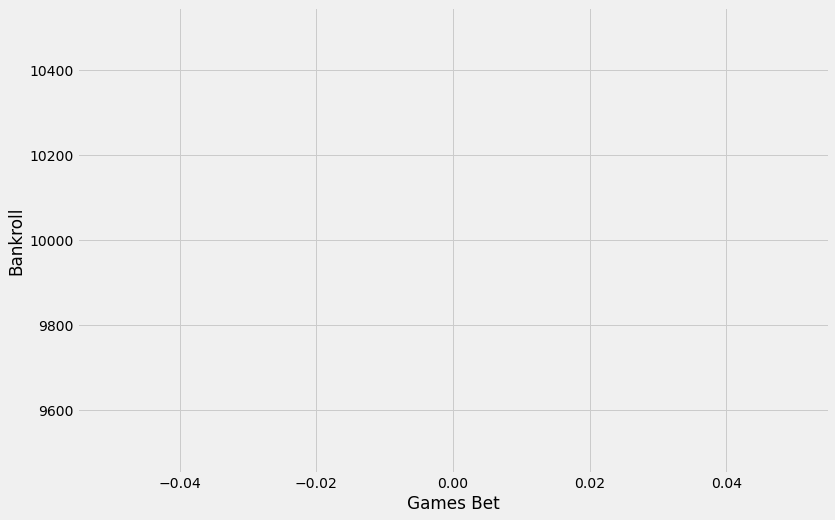

min balance: 10000.0 
max balance: 10000.0 
final balance: 10000.0 
win percentage nan


index  GAME_ID MATCHUP_home  spread_home  ml_home  ml_away  \
0    NaN      NaN          NaN          NaN      NaN      NaN   

   team_score_home  team_score_away  point_diff_home  cover_home  \
0              NaN              NaN              NaN         NaN   

   diff_preds_home  diff_preds_away  point_diff_avg  bet_home1  bet_home2  \
0              NaN              NaN             NaN        NaN        NaN   

   bet_home3  confidence_pred1  confidence_pred2  confidence_pred3  \
0        NaN               NaN               NaN               NaN   

   bankroll_i  bankroll_n  bet_size  bet_won  
0     10000.0     10000.0     300.0      NaN

In [164]:
best_en_diff= Pipeline(steps=[('scaler', StandardScaler()),
                ('en', ElasticNet(alpha=0.08532448553061071, l1_ratio=1.0,
                            max_iter=50000))])

best_en_diff.fit(X_train2, point_diff_train2)

diff_preds_en2_train = best_en_diff.predict(X_train2)
diff_preds_en2 = best_en_diff.predict(X_test2)

mae_diff_train = mean_absolute_error(point_diff_train2, diff_preds_en2_train)
mae_diff_test = mean_absolute_error(point_diff_test2, diff_preds_en2)

print("mae_diff_train:", mae_diff_train, "mae_diff_test:", mae_diff_test)

bets_train = create_betting_df(df_19, diff_preds_en2_train, train_idx2, 3)
print("Train Betting Overall Accuracy:", bets_train['bet_won'].mean())


bets_test = create_betting_df(df_19, diff_preds_en2, test_idx2, 3)
print("Test Betting Overall Accuracy:", bets_test['bet_won'].mean())

bets = create_betting_df(df_19, diff_preds_en2, test_idx2, 3)
select_bets = bets.loc[abs(bets['confidence_pred3']) > 2.81]    
simulate_bets(select_bets)


<AxesSubplot:ylabel='feature'>

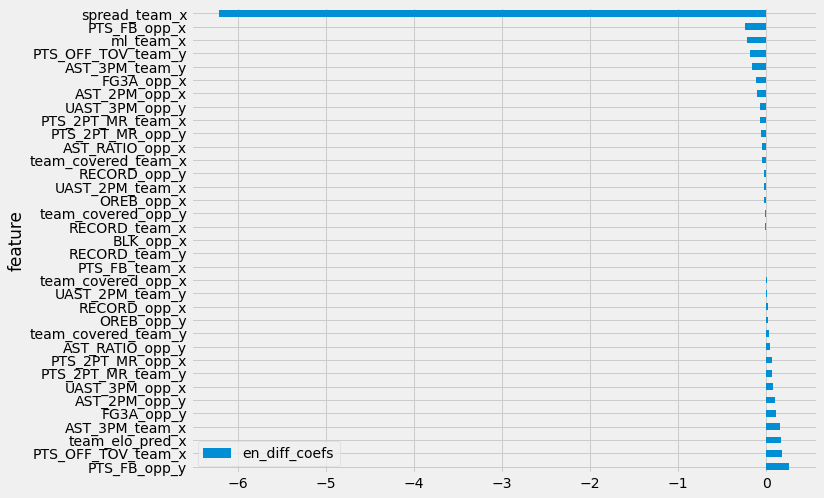

In [152]:
feature_names = X_train1.columns
en_diff_coefs = best_en_diff.named_steps['en'].coef_

coef_df_en = pd.DataFrame({'feature':feature_names,
                       'en_diff_coefs':en_diff_coefs
                          })
coef_df_en.loc[coef_df_en['en_diff_coefs']!=0].sort_values('en_diff_coefs', ascending=False).plot(kind='barh', x='feature', figsize=(10, 8))

#### Elastic Net RFE

Fitting estimator with 175 features.
Fitting estimator with 174 features.
Fitting estimator with 173 features.
Fitting estimator with 172 features.
Fitting estimator with 171 features.
Fitting estimator with 170 features.
Fitting estimator with 169 features.
Fitting estimator with 168 features.
Fitting estimator with 167 features.
Fitting estimator with 166 features.
Fitting estimator with 165 features.
Fitting estimator with 164 features.
Fitting estimator with 163 features.
Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 features.
Fitting estimator with 154 features.
Fitting estimator with 153 features.
Fitting estimator with 152 features.
Fitting estimator with 151 features.
Fitting estimator with 150 features.
Fitting estimator with 149 features.
F

Fitting estimator with 123 features.
Fitting estimator with 122 features.
Fitting estimator with 121 features.
Fitting estimator with 120 features.
Fitting estimator with 119 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitt

Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 fe

Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 175 features.
Fitting estimator with 174 features.
Fitting estimator with 173 features.
Fitting estimator with 172 features.
Fitting estimator with 171 features.
Fitting estimator with 170 features.
Fitting estimator with 169 features.
Fitting estimator with 168 features.
Fitting estimator with 167 features.
Fitting estimator with 166 features.
Fitting estimator with 165

Fitting estimator with 140 features.
Fitting estimator with 139 features.
Fitting estimator with 138 features.
Fitting estimator with 137 features.
Fitting estimator with 136 features.
Fitting estimator with 135 features.
Fitting estimator with 134 features.
Fitting estimator with 133 features.
Fitting estimator with 132 features.
Fitting estimator with 131 features.
Fitting estimator with 130 features.
Fitting estimator with 129 features.
Fitting estimator with 128 features.
Fitting estimator with 127 features.
Fitting estimator with 126 features.
Fitting estimator with 125 features.
Fitting estimator with 124 features.
Fitting estimator with 123 features.
Fitting estimator with 122 features.
Fitting estimator with 121 features.
Fitting estimator with 120 features.
Fitting estimator with 119 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
F

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


DONE
best threshold: 1.04
best prediction strat: 4
num_games_bet: 628
win percetange at threshold: 0.554140127388535


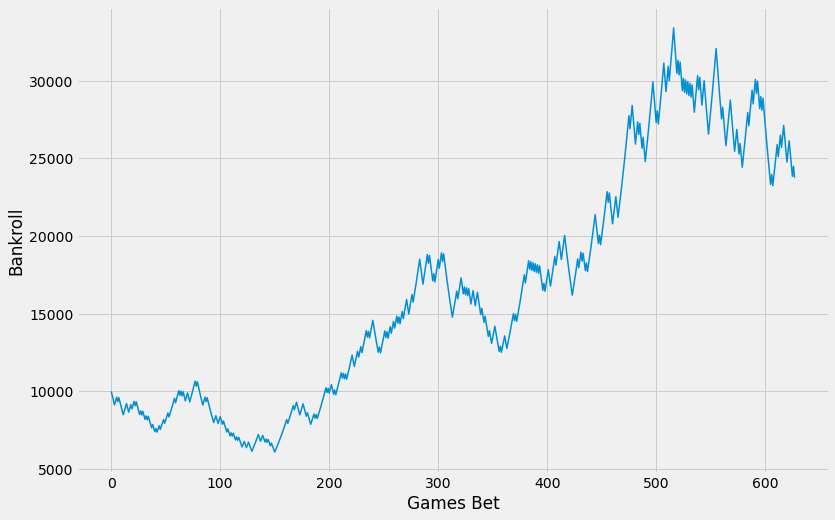

min balance: 6090.540677725496 
max balance: 33408.11552476188 
final balance: 23053.10836299894 
win percentage 55.410000000000004


index   GAME_ID MATCHUP_home  spread_home   ml_home  ml_away  \
0        5  21600085  MIL vs. SAC         -3.5  1.606061     2.45   
1       11  21600096  CHI vs. ORL         -7.0  1.333333     3.40   
2       12  21600097  OKC vs. MIA         -5.5  1.425532     2.95   
3       14  21600099  GSW vs. NOP        -16.5  1.020000    14.00   
4       18  21600104  LAL vs. DAL         -4.0  1.571429     2.55   
..     ...       ...          ...          ...       ...      ...   
623   2436  41700311  HOU vs. GSW         -2.0  1.769231     2.10   
624   2440  41700313  GSW vs. HOU         -7.5  1.250000     3.85   
625   2442  41700314  GSW vs. HOU         -7.5  1.232558     4.40   
626   2445  41700306  CLE vs. BOS         -7.0  1.322581     3.50   
627   2446  41700316  GSW vs. HOU        -12.5  1.094340     6.50   

     team_score_home  team_score_away  point_diff_home  cover_home  \
0                117               91               26           1   
1                112               80               32           1   
2                 97               85               12           1   
3                116              106               10           0   
4                 97              109              -12           0   
..               ...              ...              ...         ...   
623              106              119              -13           0   
624              126               85               41           1   
625               92               95               -3           0   
626              109               99               10           1   
627              115               86               29           1   

     score_pred_home  score_pred_away  score_pred_diff  diff_preds_home  \
0         103.282143        98.980030         4.302113         2.535256   
1         100.048329       105.258490        -5.210161         5.733422   
2         102.114891       103.031428        -0.916537         3.730726   
3         103.375142       106.448567        -3.073425        14.174731   
4         105.189385       103.340600         1.848785         1.719776   
..               ...              ...              ...              ...   
623       104.108902       102.970357         1.138546         3.165516   
624       104.571945       109.501181        -4.929236         5.998339   
625       100.973022       109.443716        -8.470694         6.395291   
626        97.769787        98.527356        -0.757569         5.709442   
627        98.019434       108.433821       -10.414387        10.762443   

     diff_preds_away  point_diff_avg  bet_home1  bet_home2  bet_home3  \
0          -2.371950        2.453603          1          0          0   
1          -5.783735        5.758579          0          0          0   
2          -3.859344        3.795035          0          0          0   
3         -15.106016       14.640374          0          0          0   
4          -1.608109        1.663942          0          0          0   
..               ...             ...        ...        ...        ...   
623        -3.076039        3.120777          0          1          1   
624        -6.021590        6.009964          0          0          0   
625        -6.456147        6.425719          0          0          0   
626        -5.703332        5.706387          0          0          0   
627       -10.993765       10.878104          0          0          0   

     bet_home4  confidence_pred1  confidence_pred2  confidence_pred3  \
0            0          0.802113         -0.964744         -1.128050   
1            0        -12.210161         -1.266578         -1.216265   
2            0         -6.416537         -1.769274         -1.640656   
3            0        -19.573425         -2.325269         -1.393984   
4            0         -2.151215         -2.280224         -2.391891   
..         ...               ...               ...               ...   
623          1         -0.861454          1.165516   

In [851]:
scaler = StandardScaler()
X_train1_sc = scaler.fit_transform(X_train1)
X_test1_sc = scaler.transform(X_test1)

best_en_diff= ElasticNet(alpha=0.050890915769200816, l1_ratio=1,
                            max_iter=50000)

rfe_en = RFECV(best_en_diff, cv=tscv, scoring='neg_mean_absolute_error', verbose=1)
rfe_en.fit(X_train1_sc, point_diff_train1)

print(rfe_en.n_features_)

best_en_diff = Pipeline(steps=[('scaler', StandardScaler()),
                ('en', ElasticNet(alpha=0.050890915769200816, l1_ratio=1,
                            max_iter=50000))])


best_en_diff.fit(X_train1.loc[:, rfe_en.support_], point_diff_train1)

diff_preds_en_reduced = best_en_diff.predict(X_test1.loc[:, rfe_en.support_])

mae_diff = mean_absolute_error(point_diff_test1, diff_preds_en_reduced)

print("mae_diff_en_reduced:", mae_diff)

select_bets_en, bet_thresholds_lr_en = find_optimal_confidence_thresholds(diff_preds_en_reduced, score_preds_en, test_idx1)
simulate_bets(select_bets_en)



<AxesSubplot:ylabel='feature'>

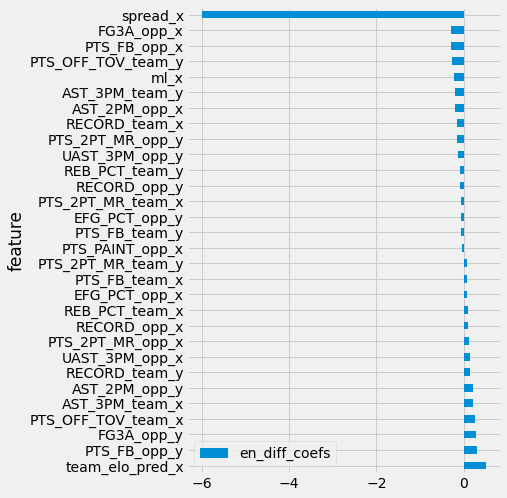

In [859]:
feature_names = X_train1.loc[:, rfe_en.support_].columns
en_diff_coefs = best_en_diff.named_steps['en'].coef_

coef_df_en = pd.DataFrame({'feature':feature_names,
                       'en_diff_coefs':en_diff_coefs})


coef_df_en.sort_values('en_diff_coefs', ascending=False).plot.barh(figsize=(5, 8), x='feature')

mae_diff: 9.95425086909769


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


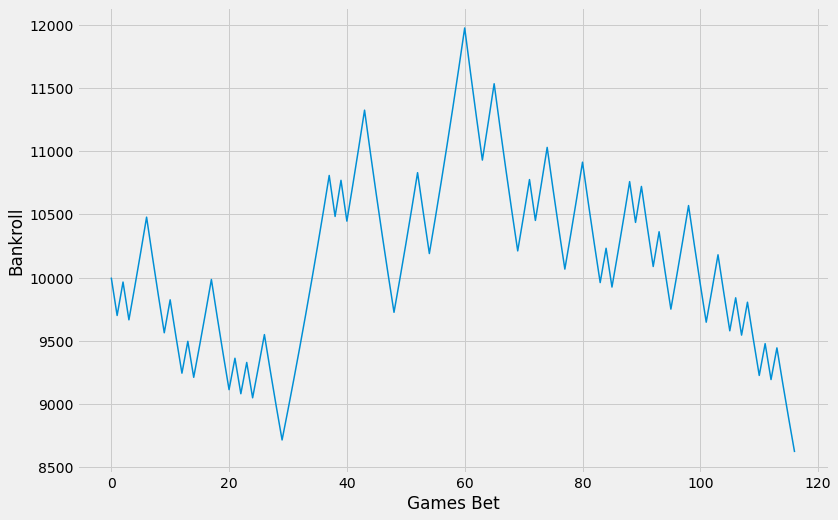

min balance: 8618.835550841412 
max balance: 11975.534273869205 
final balance: 8853.894702227995 
win percentage 51.28


index   GAME_ID MATCHUP_home  spread_home   ml_home   ml_away  \
0        0  21800068  NYK vs. GSW         11.5  7.350000  1.090909   
1       14  21800094  SAS vs. DAL         -7.0  1.333333  3.500000   
2       51  21800131  DEN vs. UTA         -4.5  1.500000  2.700000   
3       57  21800137  SAS vs. ORL         -7.5  1.270270  3.850000   
4       71  21800151  PHX vs. BKN          2.5  2.200000  1.714286   
..     ...       ...          ...          ...       ...       ...   
112   2192  41900112  TOR vs. BKN        -11.5  1.125000  1.769231   
113   2200  41900113  BKN vs. TOR         11.0  1.909091  1.153846   
114   2208  41900114  BKN vs. TOR         14.0  7.950000  1.076923   
115   2228  41900177  HOU vs. OKC         -5.5  1.408163  2.900000   
116   2233  41900221  LAL vs. HOU         -5.5  1.416667  3.000000   

     team_score_home  team_score_away  point_diff_home  cover_home  \
0                100              128              -28           0   
1                113              108                5           0   
2                103               88               15           1   
3                110              117               -7           0   
4                 82              104              -22           0   
..               ...              ...              ...         ...   
112              104               99                5           0   
113               92              117              -25           0   
114              122              150              -28           0   
115              104              102                2           0   
116               97              112              -15           0   

     score_pred_home  score_pred_away  score_pred_diff  diff_preds_home  \
0         110.905440       120.314567        -9.409126        -9.496692   
1         115.444981       111.448558         3.996423         4.431860   
2         111.934630       109.610355         2.324275         2.750031   
3         109.676898       104.465497         5.211401         5.925498   
4         108.160379       112.115742        -3.955362        -4.714411   
..               ...              ...              ...              ...   
112       120.456557       111.459608         8.996950         9.813860   
113       110.525804       118.385565        -7.859761        -9.026092   
114       108.212089       118.581137       -10.369048       -12.220316   
115       115.678410       108.473661         7.204749         7.072780   
116       116.257616       111.792550         4.465066         3.951570   

     diff_preds_away  point_diff_avg  bet_home1  bet_home2  bet_home3  \
0           9.180288       -9.338490          1          1          1   
1          -4.328910        4.380385          0          0          0   
2          -2.664943        2.707487          0          0          0   
3          -5.904442        5.914970          0          0          0   
4           4.893367       -4.803889          0          0          0   
..               ...             ...        ...        ...        ...   
112        -9.551384        9.682622          0          0          0   
113         9.270011       -9.148052          1          1          1   
114        11.889490      -12.054903          1          1          1   
115        -7.008053        7.040416          1          1          1   
116        -3.859616        3.905593          0          0          0   

     bet_home4  confidence_pred1  confidence_pred2  confidence_pred3  \
0            1          2.090874          2.003308          2.319712   
1            0         -3.003577         -2.568140         -2.671090   
2            0         -2.175725         -1.749969         -1.835057   
3            0         -2.288599         -1.574502         -1.595558   
4            0         -1.455362         -2.214411         -2.393367   
..         ...               ...               ...               ...   
112          0         -2.503050         

In [878]:
best_en_diff.fit(X_train2.loc[:, rfe_en.support_], point_diff_train2)


diff_preds_en2_reduced = best_en_diff.predict(X_test2.loc[:, rfe_en.support_])

mae_diff = mean_absolute_error(point_diff_test2, diff_preds_en2_reduced)

print("mae_diff:", mae_diff)

bets = create_betting_df(final_df_ewm_19, diff_preds_en2_reduced, score_preds_en2, test_idx2, 4)
select_bets = bets.loc[abs(bets['confidence_pred4']) > 1.54]    
simulate_bets(select_bets)

In [695]:
### Light Gradient Boost

In [1203]:
lgbr = lgb.LGBMRegressor()

search_spaces = {'min_child_weight':Integer(1,12),
              'subsample': Real(0.6, 1),
              'max_depth': Integer(3, 20),
              'reg_lambda': Integer(1, 20),
              'reg_alpha': Integer(0, 1),
                'boosting_type':Categorical(['gbdt'], transform='string'),
                'num_leaves':Integer(2, 2048),
                'feature_fraction':Real(0.01, 1)
                }
    
    
lgbr_bs_diff = BayesSearchCV(lgb.LGBMRegressor(objective='regression', subsample_freq=1), search_spaces=search_spaces,
                        cv=tscv, verbose=1, n_jobs=-1, n_iter=100)


lgbr_bs_diff.fit(X_train1, point_diff_train1)

best_lgbr_diff = lgbr_bs_diff.best_estimator_

print("best_lgbr_diff:", best_lgbr_diff)

diff_preds_lgbr = best_lgbr_diff.predict(X_test1)




Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
best_lgbr_diff: LGBMRegressor(feature_fraction=1.0, max_depth=3, min_child_weight=12,
              num_leaves=2, objective='regression', reg_alpha=0, reg_lambda=4,
              subsample=0.7990464371402357, subsample_freq=1)


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


DONE
best threshold: 2.21
best prediction strat: 2
num_games_bet: 252
win percetange at threshold: 0.5634920634920635


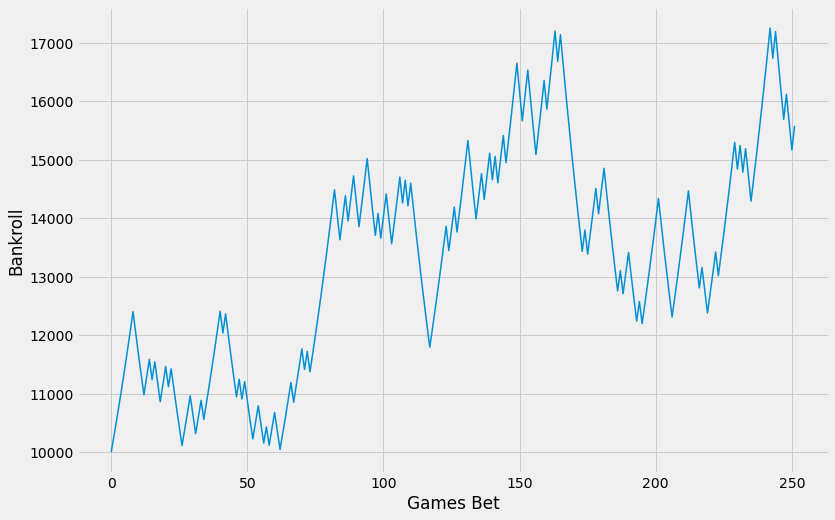

min balance: 10046.396593440064 
max balance: 17254.207340485165 
final balance: 16005.470728113201 
win percentage 56.35


index   GAME_ID MATCHUP_home  spread_home   ml_home  ml_away  \
0       11  21400091  DET vs. UTA         -4.0  1.606061     2.45   
1       46  21400126  NYK vs. UTA         -4.0  1.588235     2.45   
2       47  21400127  HOU vs. PHI        -16.5  1.018198    15.00   
3       67  21400147  CLE vs. DEN        -12.0  1.100806     7.50   
4       79  21400159  CLE vs. SAS         -1.5  1.800000     2.05   
..     ...       ...          ...          ...       ...      ...   
247   3599  41600141  GSW vs. POR        -15.5  1.036364    10.75   
248   3649  41600204  WAS vs. BOS         -5.0  1.487805     2.50   
249   3654  41600205  BOS vs. WAS         -4.0  1.512821     2.40   
250   3663  41600303  CLE vs. BOS        -16.0  1.025000    14.50   
251   3665  41600304  CLE vs. BOS        -15.5  1.035088    11.00   

     point_diff_home  cover_home  diff_preds_home  diff_preds_away  \
0                 -1           0         1.325801        -1.656874   
1                 -2           0         1.964877        -1.418942   
2                  1           0        14.681103       -13.381097   
3                 -9           0         9.494157        -9.720158   
4                 -2           0         0.044923         0.862858   
..               ...         ...              ...              ...   
247               12           0        13.381276       -12.399072   
248               19           1         3.951094        -1.811565   
249               22           1         2.920907        -1.601755   
250               -3           0        13.715521       -12.959389   
251               13           0        13.715521       -12.945318   

     point_diff_avg  bet_home1  bet_home2  bet_home3  confidence_pred1  \
0          1.491337          0          0          0         -2.674199   
1          1.691910          0          0          0         -2.035123   
2         14.031100          0          0          0         -1.818897   
3          9.607157          0          0          0         -2.505843   
4         -0.408967          0          0          0         -1.455077   
..              ...        ...        ...        ...               ...   
247       12.890174          0          0          0         -2.118724   
248        2.881330          0          0          0         -1.048906   
249        2.261331          0          0          0         -1.079093   
250       13.337455          0          0          0         -2.284479   
251       13.330419          0          0          0         -1.784479   

     confidence_pred2  confidence_pred3    bankroll_i    bankroll_n  \
0           -2.343126         -2.508663  10000.000000  10272.727273   
1           -2.581058         -2.308090  10272.727273  10552.892562   
2           -3.118903         -2.468900  10552.892562  10840.698723   
3           -2.279842         -2.392843  10840.698723  11136.354142   
4           -2.362858         -1.908967  11136.354142  11440.072892   
..                ...               ...           ...           ...   
247         -3.100928         -2.609826  15691.617311  16119.570510   
248         -3.188435         -2.118670  16119.570510  15635.983395   
249         -2.398245         -1.738669  15635.983395  15166.903893   
250         -3.040611         -2.662545  15166.903893  15580.546726   
251         -2.554682         -2.169581  15580.546726  16005.470728   

       bet_size  bet_won  
0    300.000000        1  
1    308.181818        1  
2    316.586777        1  
3    325.220962        1  
4    334.090624        1  
..          ...      ...  
247  470.748519        1  
248  483.587115        0  
249  469.079502        0  
250  455.007117        1  
251  467.416402        1  

[252 rows x 21 columns]

In [1205]:
select_bets_lgbr, bet_thresholds_lgbr = find_optimal_confidence_thresholds(df_19, diff_preds_lgbr,
                                                                               test_idx1)
simulate_bets(select_bets_lgbr)


In [1206]:
bet_thresholds_lgbr

index  prediction_num  confidence_thresholds  num_games_bet  \
0      1220               2                   2.21            252   
1      1221               2                   2.22            251   
2      2216               3                   2.17            238   
3      1222               2                   2.23            249   
4      1223               2                   2.24            249   
...     ...             ...                    ...            ...   
1463    420               1                   4.21             15   
1464    421               1                   4.22             15   
1465    422               1                   4.23             15   
1466    423               1                   4.24             15   
1467    424               1                   4.25             15   

      win_percentage  expected_profits  
0           0.563492              2320  
1           0.561753              2220  
2           0.563025              2168  
3           0.558233              2020  
4           0.558233              2020  
...              ...               ...  
1463        0.533333                44  
1464        0.533333                44  
1465        0.533333                44  
1466        0.533333                44  
1467        0.533333                44  

[1468 rows x 6 columns]

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
mae_diff_train: 9.201828506336135 mae_diff_test: 9.811594971868463
Train Betting Overall Accuracy: 0.5216010165184244
Test Betting Overall Accuracy: 0.5002930832356389


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

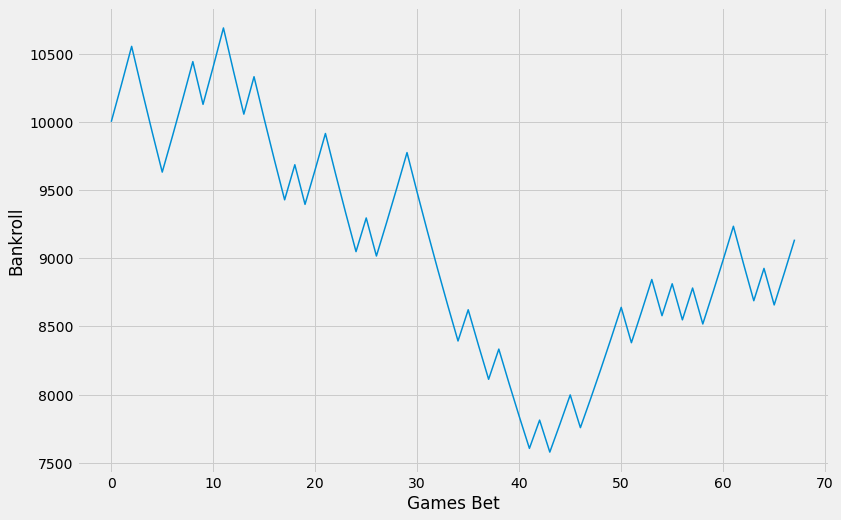

min balance: 7579.438030390444 
max balance: 10687.773595291796 
final balance: 8862.469388385292 
win percentage 50.0


index   GAME_ID MATCHUP_home  spread_home    ml_home    ml_away  \
0      10  21700091  GSW vs. DET        -14.5   1.062500   8.500000   
1      58  21700139  TOR vs. WAS         -6.5   1.370370   3.100000   
2      67  21700148  GSW vs. MIA        -14.5   1.058824   8.250000   
3     174  21700255  PHI vs. POR         -4.5   1.571429   2.400000   
4     195  21700276  GSW vs. CHI        -16.0   1.062500   9.000000   
5     201  21700282  HOU vs. NYK        -19.0   1.031250   8.500000   
6     213  21700294  HOU vs. BKN        -18.0   1.025000  15.530000   
7     269  21700350  TOR vs. PHX        -14.5   1.083333   8.000000   
8     391  21700472  ORL vs. NOP          6.5   3.100000   1.384615   
9     617  21700699  GSW vs. NYK        -16.0   1.033333  13.000000   
10    635  21700717  CHI vs. LAL         -4.5   1.606061   2.440000   
11    732  21700815  GSW vs. DAL        -14.5   1.066667   8.250000   
12    763  21700846  GSW vs. PHX        -16.5   1.043478  12.000000   
13   1050  21701132  HOU vs. PHX        -17.5   1.012500  18.000000   
14   1125  21701209  MIN vs. MEM        -17.0   1.033333  13.000000   
15   1165  41700163  NOP vs. POR         -4.0   1.625000   2.400000   
16   1593  21800444  NYK vs. PHX          1.5   1.952381   1.833333   
17   1604  21800455  CHA vs. CLE        -14.0   1.066667   8.000000   
18   1754  21800605  GSW vs. NYK        -17.0   1.016667  16.500000   
19   1808  21800659  HOU vs. BKN         -6.5   1.384615   2.950000   
20   1816  21800667  IND vs. PHI         -3.5   1.666667   2.300000   
21   1818  21800669  DEN vs. CHI        -14.5   1.071429   8.500000   
22   1836  21800687  DEN vs. CLE        -18.5   1.022222  16.200000   
23   1850  21800701  LAL vs. GSW         13.5   7.500000   1.071429   
24   1971  21800822  PHX vs. GSW         17.0  14.500000   1.028571   
25   2066  21800917  SAS vs. DET         -4.5   1.571429   2.550000   
26   2107  21800958  LAL vs. LAC         -4.0   1.571429   2.440000   
27   2149  21801000  GSW vs. PHX        -17.0   1.026316  12.250000   
28   2157  21801008  PHI vs. CLE        -15.5   1.066667   8.750000   
29   2160  21801011  DAL vs. SAS          3.5   2.300000   1.666667   
30   2181  21801032  SAS vs. NYK        -13.5   1.083333   8.000000   
31   2333  21801184  HOU vs. NYK        -18.0   1.018182  13.750000   
32   2349  21801200  HOU vs. PHX        -18.5   1.013333  17.750000   
33   2426  41800202  MIL vs. BOS         -8.5   1.273973   2.050000   
34   2445  41800237  DEN vs. POR         -8.0   1.277778   2.850000   
35   2449  41800302  MIL vs. TOR         -6.5   1.373134   3.050000   
36   2491  21900107  HOU vs. GSW        -16.0   1.033333  10.500000   
37   2561  21900177  NYK vs. CHA         -4.5   1.588235   2.500000   
38   2592  21900208  DAL vs. GSW        -14.5   1.066667   8.750000   
39   2625  21900241  DET vs. ORL         -5.0   1.500000   2.480000   
40   2667  21900297  MIL vs. NYK        -17.0   1.033333  10.750000   
41   2749  21900379  UTA vs. GSW        -14.0   1.083333   7.190000   
42   2776  21900406  LAC vs. PHX        -14.5   1.071429   6.560000   
43   2862  21900506  MIL vs. MIN        -18.0   1.020000  13.750000   
44   2928  21900572  DAL vs. LAL         -2.5   1.714286   1.746269   
45   2957  21900601  MIL vs. NYK        -17.0   1.038462  11.000000   
46   3024  21900669  CHA vs. MIL         14.5   8.750000   1.062500   
47   3053  21900698  UTA vs. HOU        -14.5   1.062500   8.000000   
48   3073  21900719  LAC vs. SAC        -14.5   1.066667   8.000000   
49   3112  21900758  TOR vs. IND         -6.0   1.400000   2.340000   
50   3117  21900763  LAC vs. MIA         -7.0   1.357143   2.440000   
51   3119  21900765  CHI vs. NOP          6.5   3.100000   1.400000   
52   3122  21900768  LAL vs. HOU         -6.5   1.344828   2.400000   
53   3164  21900810  IND vs. MIL         -2.5   1.694444   2.000000   
54   3173  21900819  NOP vs. OKC         -4.0   1.588235   2.500000   
55   3208  21900854  DAL vs.

In [1207]:
best_lgbr_diff = lgb.LGBMRegressor(colsample_bytree=0.5597090226673742,
              feature_fraction=0.6880319327164988, max_depth=26,
              min_child_weight=1, num_leaves=2, objective='regression',
              reg_alpha=4, reg_lambda=4, subsample=0.6521226559898796,
              subsample_freq=1)

best_lgbr_diff = lgb.LGBMRegressor(colsample_bytree=0.5, feature_fraction=0.8648180673777857,
              max_depth=10, min_child_weight=8, num_leaves=2,
              objective='regression', reg_alpha=10, reg_lambda=1,
              subsample_freq=1)


best_lgbr_diff = lgb.LGBMRegressor(feature_fraction=1.0, max_depth=3, min_child_weight=12,
              num_leaves=2, objective='regression', reg_alpha=0, reg_lambda=4,
              subsample=0.7990464371402357, subsample_freq=1)

best_lgbr_diff.fit(X_train2, point_diff_train2)

diff_preds_lgbr2_train = best_lgbr_diff.predict(X_train2)

diff_preds_lgbr2 = best_lgbr_diff.predict(X_test2)

mae_diff_train = mean_absolute_error(point_diff_train2, diff_preds_lgbr2_train)
mae_diff_test = mean_absolute_error(point_diff_test2, diff_preds_lgbr2)

print("mae_diff_train:", mae_diff_train, "mae_diff_test:", mae_diff_test)

bets_train = create_betting_df(df_19, diff_preds_lgbr2_train, train_idx2, 3)
print("Train Betting Overall Accuracy:", bets_train['bet_won'].mean())


bets_test = create_betting_df(df_19, diff_preds_lgbr2, test_idx2, 3)
print("Test Betting Overall Accuracy:", bets_test['bet_won'].mean())



bets = create_betting_df(df_19, diff_preds_lgbr2, test_idx2, 3)
select_bets = bets.loc[abs(bets['confidence_pred3']) > 2.17]    
simulate_bets(select_bets)




#### Predicting Spread + Actual Point Diff as Proxy for Confidence of Covering

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s finished


best svr_diff estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('svr',
                 LinearSVR(C=0.0017064754539018786,
                           loss='squared_epsilon_insensitive',
                           max_iter=10000))])


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


DONE
best threshold: 0.87
best prediction strat: 1
num_games_bet: 2086
win percetange at threshold: 0.5340364333652924


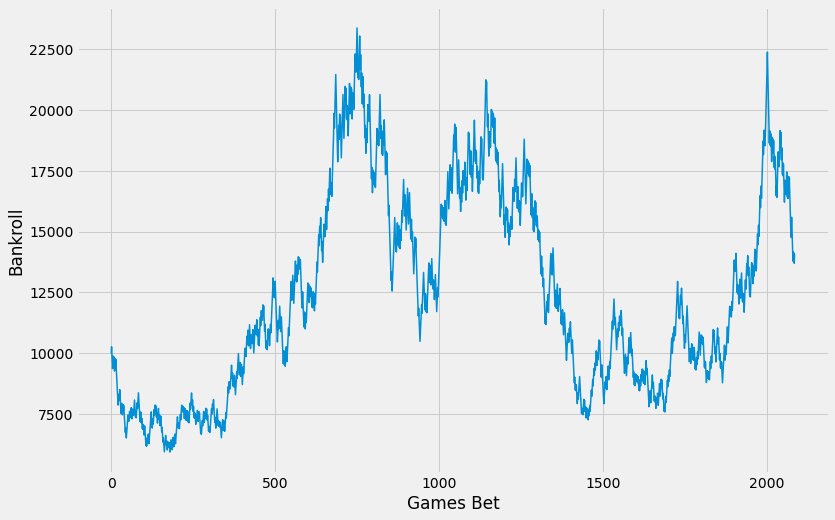

min balance: 5953.145575598936 
max balance: 23350.309213514338 
final balance: 14456.410807238366 
win percentage 53.400000000000006


index   GAME_ID MATCHUP_home  spread_home   ml_home    ml_away  \
0         0  21400073  PHI vs. CHI         10.0  5.500000   1.166667   
1         2  21400078  OKC vs. MEM          7.0  3.600000   1.307692   
2         3  21400079  PHX vs. SAC         -5.0  1.487805   2.750000   
3         4  21400080  UTA vs. DAL          3.0  2.300000   1.666667   
4         5  21400082  LAC vs. POR         -4.5  1.526316   2.650000   
...     ...       ...          ...          ...       ...        ...   
2081   3664  41600314  SAS vs. GSW         11.0  5.500000   1.133333   
2082   3665  41600304  CLE vs. BOS        -15.5  1.035088  11.000000   
2083   3666  41600305  BOS vs. CLE         10.0  4.900000   1.172414   
2084   3667  41600401  GSW vs. CLE         -7.5  1.277778   3.400000   
2085   3669  41600403  CLE vs. GSW          3.0  2.200000   1.666667   

      point_diff_home  cover_home  diff_preds_home  diff_preds_away  \
0                  -3           1        -6.961459         6.917631   
1                  -2           1        -8.212773         8.125799   
2                  -2           0         8.041881        -7.901937   
3                 -23           0        -1.483212         1.648383   
4                   4           0         2.753535        -2.793195   
...               ...         ...              ...              ...   
2081              -14           0        -7.745426         7.537952   
2082               13           0        11.959096       -13.151332   
2083              -33           0        -6.538231         6.451004   
2084               22           1         8.730600        -8.599427   
2085               -5           0        -3.916677         4.241287   

      point_diff_avg  bet_home1  bet_home2  bet_home3  confidence_pred1  \
0          -6.939545          1          1          1          3.038541   
1          -8.169286          0          0          0         -1.212773   
2           7.971909          1          1          1          3.041881   
3          -1.565797          1          1          1          1.516788   
4           2.773365          0          0          0         -1.746465   
...              ...        ...        ...        ...               ...   
2081       -7.641689          1          1          1          3.254574   
2082       12.555214          0          0          0         -3.540904   
2083       -6.494617          1          1          1          3.461769   
2084        8.665014          1          1          1          1.230600   
2085       -4.078982          0          0          0         -0.916677   

      confidence_pred2  confidence_pred3    bankroll_i    bankroll_n  \
0             3.082369          3.060455  10000.000000  10272.727273   
1            -1.125799         -1.169286  10272.727273   9964.545455   
2             2.901937          2.971909   9964.545455   9665.609091   
3             1.351617          1.434203   9665.609091   9375.640818   
4            -1.706805         -1.726635   9375.640818   9631.340113   
...                ...               ...           ...           ...   
2081          3.462048          3.358311  14172.933113  13747.745120   
2082         -2.348668         -2.944786  13747.745120  14122.683623   
2083          3.548996          3.505383  14122.683623  13699.003114   
2084          1.099427          1.165014  13699.003114  14072.612290   
2085         -1.241287         -1.078982  14072.612290  14456.410807   

        bet_size  bet_won  
0     300.000000        1  
1     308.181818        0  
2     298.936364        0  
3     289.968273        0  
4     281.269225        1  
...          ...      ...  
2081  425.187993        0  
2082  412.432354        1  
2083  423.680509        0  
2084  410.970093        1  
2085  422.178369        1  

[2086 rows x 21 columns]

In [1208]:
pipeline_svr_diff = Pipeline([('scaler', StandardScaler()),
                        ('svr', LinearSVR(max_iter=10000))])


search_spaces = {'svr__C': Real(1e-6, 1e+6, prior='log-uniform'),
                'svr__loss' : Categorical(['epsilon_insensitive', 'squared_epsilon_insensitive'])}


svr_bs_diff = BayesSearchCV(pipeline_svr_diff, search_spaces=search_spaces, 
                         n_jobs=-1, cv=tscv, verbose=1)


svr_bs_diff.fit(X_train1, point_diff_train1)

print("best svr_diff estimator:", svr_bs_diff.best_estimator_)

best_svr_diff = svr_bs_diff.best_estimator_


diff_preds_svr = best_svr_diff.predict(X_test1)

select_bets_svr, bet_thresholds_svr = find_optimal_confidence_thresholds(df_19, diff_preds_svr,
                                                                               test_idx1)
simulate_bets(select_bets_svr)



mae_diff_train: 9.184721981523559 mae_diff_test: 9.818995217721703
Train Betting Overall Accuracy: 0.5356575603557815
Test Betting Overall Accuracy: 0.5076201641266119


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

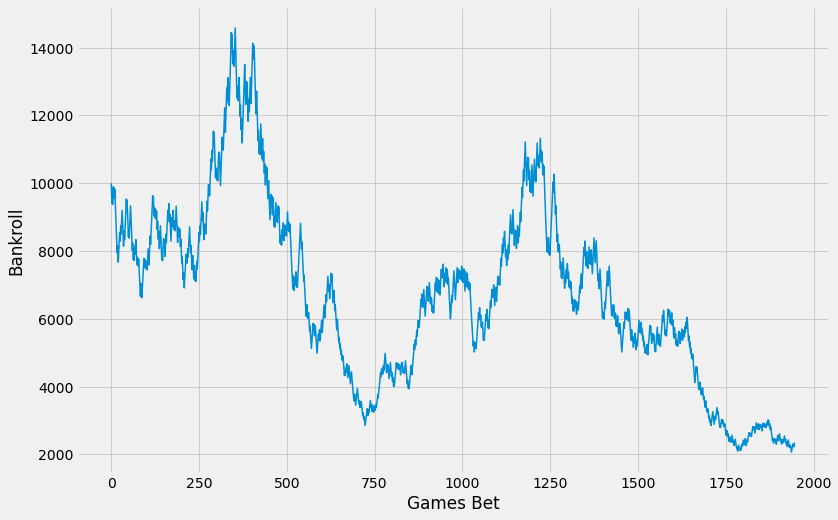

min balance: 2069.1279951700976 
max balance: 14579.507828479853 
final balance: 2414.4426374965524 
win percentage 51.82


index   GAME_ID MATCHUP_home  spread_home   ml_home   ml_away  \
0         1  21700080  MEM vs. HOU         -2.0  1.800000  2.050000   
1         2  21700081  DAL vs. PHI          1.0  2.000000  1.833333   
2         3  21700082  UTA vs. LAL        -11.0  1.181818  5.160000   
3         4  21700083  POR vs. PHX        -12.0  1.133333  6.000000   
4         7  21700087  BKN vs. DEN          5.5  2.750000  1.454545   
...     ...       ...          ...          ...       ...       ...   
1942   3485  41900304  MIA vs. BOS          3.5  2.380000  1.588235   
1943   3487  41900305  BOS vs. MIA         -3.5  1.591716  2.350000   
1944   3488  41900315  LAL vs. DEN         -5.5  1.487805  2.360000   
1945   3489  41900306  MIA vs. BOS          3.0  2.200000  1.714286   
1946   3492  41900403  MIA vs. LAL          9.5  4.300000  1.210526   

      team_score_home  team_score_away  point_diff_home  cover_home  \
0                 103               89               14           1   
1                 110              112               -2           0   
2                  96               81               15           1   
3                 114              107                7           0   
4                 111              124              -13           0   
...               ...              ...              ...         ...   
1942              112              109                3           1   
1943              121              108               13           1   
1944              117              107               10           1   
1945              125              113               12           1   
1946              115              104               11           1   

      diff_preds_home  diff_preds_away  point_diff_avg  bet_home1  bet_home2  \
0           -0.156724         0.348425       -0.252574          0          0   
1            1.415077        -1.321492        1.368285          1          1   
2           12.921284       -13.025212       12.973248          1          1   
3           12.870863       -13.185328       13.028095          1          1   
4           -6.789137         6.766752       -6.777945          0          0   
...               ...              ...             ...        ...        ...   
1942        -0.314848         0.490931       -0.402890          1          1   
1943         2.028966        -1.849381        1.939174          0          0   
1944         6.568073        -6.312034        6.440053          1          1   
1945        -0.834675         1.002016       -0.918345          1          1   
1946        -8.026953         7.913509       -7.970231          1          1   

      bet_home3  confidence_pred1  confidence_pred2  confidence_pred3  \
0             0         -2.156724         -2.348425         -2.252574   
1             1          2.415077          2.321492          2.368285   
2             1          1.921284          2.025212          1.973248   
3             1          0.870863          1.185328          1.028095   
4             0         -1.289137         -1.266752         -1.277945   
...         ...               ...               ...               ...   
1942          1          3.185152          3.009069          3.097110   
1943          0         -1.471034         -1.650619         -1.560826   
1944          1          1.068073          0.812034          0.940053   
1945          1          2.165325          1.997984          2.081655   
1946          1          1.473047          1.586491          1.529769   

        bankroll_i   bankroll_n    bet_size  bet_won  
0     10000.000000  9700.000000  300.000000        0  
1      9700.000000  9409.000000  291.000000        0  
2      9409.000000  9665.609091  282.270000        1  
3      9665.609091  9375.640818  289.968273        0  
4      9375.640818  9631.340113  281.269225        1  
...            ...          ...         ...      ...  
1942   2235.126586  2296.084583   67.053798        1  
1943   2296.084583  22

In [89]:
best_svr_diff = Pipeline(steps=[('scaler', StandardScaler()),
                ('svr',
                 LinearSVR(C=0.0017064754539018786,
                           loss='squared_epsilon_insensitive',
                           max_iter=10000))])

best_svr_diff.fit(X_train2, point_diff_train2)

diff_preds_svr2_train = best_svr_diff.predict(X_train2)
diff_preds_svr2 = best_svr_diff.predict(X_test2)

mae_diff_train = mean_absolute_error(point_diff_train2, diff_preds_svr2_train)
mae_diff_test = mean_absolute_error(point_diff_test2, diff_preds_svr2)

print("mae_diff_train:", mae_diff_train, "mae_diff_test:", mae_diff_test)

bets_train = create_betting_df(df_19, diff_preds_svr2_train, train_idx2, 3)
print("Train Betting Overall Accuracy:", bets_train['bet_won'].mean())


bets_test = create_betting_df(df_19, diff_preds_svr2, test_idx2, 3)
print("Test Betting Overall Accuracy:", bets_test['bet_won'].mean())



bets = create_betting_df(df_19, diff_preds_svr2, test_idx2, 3)
select_bets = bets.loc[abs(bets['confidence_pred3']) > .87]    
simulate_bets(select_bets)


### XGB

#### Predicting Spread + Actual Point Diff as Proxy for Confidence of Covering

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   51.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.0s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.4s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.6s finished


best_xgbr_diff: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.5000000000000001,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=20, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=20, reg_lambda=20, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


DONE
best threshold: 2.8
best prediction strat: 2
num_games_bet: 910
win percetange at threshold: 0.5395604395604395


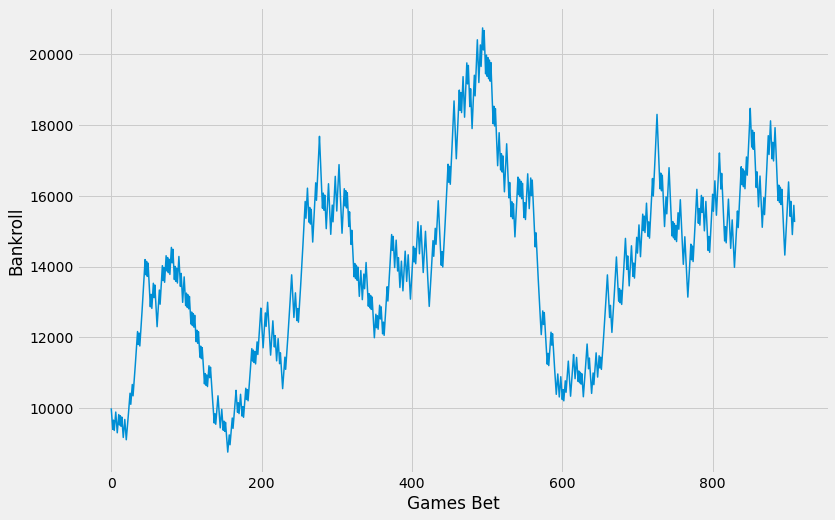

min balance: 8764.774276648963 
max balance: 20729.715594111854 
final balance: 15669.819548705062 
win percentage 53.959999999999994


index   GAME_ID MATCHUP_home  spread_home   ml_home    ml_away  \
0        4  21400080  UTA vs. DAL          3.0  2.300000   1.666667   
1        5  21400082  LAC vs. POR         -4.5  1.526316   2.650000   
2        8  21400086  CHI vs. BOS         -9.5  1.181818   4.750000   
3       16  21400096  POR vs. DEN         -9.0  1.217391   4.500000   
4       18  21400098  CLE vs. NOP         -5.5  1.392157   3.050000   
..     ...       ...          ...          ...       ...        ...   
905   3662  41600313  SAS vs. GSW          9.5  4.750000   1.181818   
906   3663  41600303  CLE vs. BOS        -16.0  1.025000  14.500000   
907   3665  41600304  CLE vs. BOS        -15.5  1.035088  11.000000   
908   3666  41600305  BOS vs. CLE         10.0  4.900000   1.172414   
909   3668  41600402  GSW vs. CLE         -9.0  1.250000   4.300000   

     point_diff_home  cover_home  diff_preds_home  diff_preds_away  \
0                -23           0         0.412676        -1.106914   
1                  4           0        13.238001       -11.232342   
2                 -5           0         5.860137        -6.172009   
3                 16           1         6.602276        -2.462680   
4                  7           1         6.007989        -9.245959   
..               ...         ...              ...              ...   
905              -12           0        -8.869665         6.154743   
906               -3           0        15.829696        -8.069627   
907               13           0        12.725425        -8.334524   
908              -33           0        -3.243821         6.888863   
909               19           1        11.720340       -12.748237   

     point_diff_avg  bet_home1  bet_home2  bet_home3  confidence_pred1  \
0          0.759795          1          1          1          3.412676   
1         12.235171          1          1          1          8.738001   
2          6.016073          0          0          0         -3.639863   
3          4.532478          0          0          0         -2.397724   
4          7.626974          1          1          1          0.507989   
..              ...        ...        ...        ...               ...   
905       -7.512204          1          1          1          0.630335   
906       11.949661          0          0          0         -0.170304   
907       10.529974          0          0          0         -2.774575   
908       -5.066341          1          1          1          6.756179   
909       12.234288          1          1          1          2.720340   

     confidence_pred2  confidence_pred3    bankroll_i    bankroll_n  \
0            4.106914          3.759795  10000.000000   9700.000000   
1            6.732342          7.735171   9700.000000   9409.000000   
2           -3.327991         -3.483927   9409.000000   9665.609091   
3           -6.537320         -4.467522   9665.609091   9375.640818   
4            3.745959          2.126974   9375.640818   9631.340113   
..                ...               ...           ...           ...   
905          3.345257          1.987796  15362.547960  14901.671521   
906         -7.930373         -4.050339  14901.671521  15308.080745   
907         -7.165476         -4.970026  15308.080745  15725.573856   
908          3.111137          4.933659  15725.573856  15253.806640   
909          3.748237          3.234288  15253.806640  15669.819549   

       bet_size  bet_won  
0    300.000000        0  
1    291.000000        0  
2    282.270000        1  
3    289.968273        0  
4    281.269225        1  
..          ...      ...  
905  460.876439        0  
906  447.050146        1  
907  459.242422        1  
908  471.767216        0  
909  457.614199        1  

[910 rows x 21 columns]

In [1209]:
search_spaces = {'min_child_weight':Integer(1,20),
              'gamma': Real(0.5, 3),
              'subsample': Real(0.6, 1),
              'colsample_bytree': Real(0.5, 1),
              'max_depth': Integer(3, 30),
              'reg_lambda': Integer(1, 20),
              'reg_alpha': Integer(0, 20)}
    
    
xgbr_bs_diff = BayesSearchCV(xgb.XGBRegressor(), search_spaces=search_spaces,
                        cv=tscv, verbose=1, n_jobs=-1)

xgbr_bs_diff.fit(X_train1, point_diff_train1)

best_xgbr_diff = xgbr_bs_diff.best_estimator_

print("best_xgbr_diff:", best_xgbr_diff)

diff_preds_xgbr = best_xgbr_diff.predict(X_test1)

select_bets_xgbr, bet_thresholds_xgbr = find_optimal_confidence_thresholds(df_19, diff_preds_xgbr,
                                                                               test_idx1)
simulate_bets(select_bets_xgbr)


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


DONE
best threshold: 2.8
best prediction strat: 2
num_games_bet: 910
win percetange at threshold: 0.5395604395604395


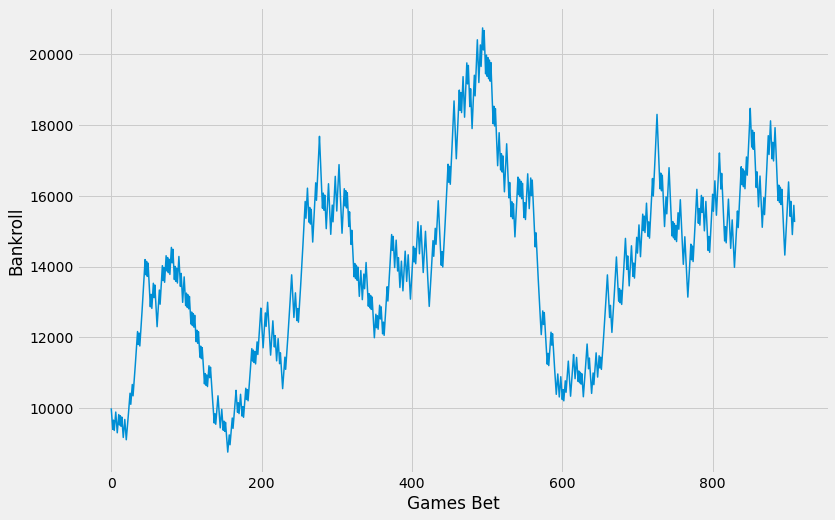

min balance: 8764.774276648963 
max balance: 20729.715594111854 
final balance: 15669.819548705062 
win percentage 53.959999999999994


index   GAME_ID MATCHUP_home  spread_home   ml_home    ml_away  \
0        4  21400080  UTA vs. DAL          3.0  2.300000   1.666667   
1        5  21400082  LAC vs. POR         -4.5  1.526316   2.650000   
2        8  21400086  CHI vs. BOS         -9.5  1.181818   4.750000   
3       16  21400096  POR vs. DEN         -9.0  1.217391   4.500000   
4       18  21400098  CLE vs. NOP         -5.5  1.392157   3.050000   
..     ...       ...          ...          ...       ...        ...   
905   3662  41600313  SAS vs. GSW          9.5  4.750000   1.181818   
906   3663  41600303  CLE vs. BOS        -16.0  1.025000  14.500000   
907   3665  41600304  CLE vs. BOS        -15.5  1.035088  11.000000   
908   3666  41600305  BOS vs. CLE         10.0  4.900000   1.172414   
909   3668  41600402  GSW vs. CLE         -9.0  1.250000   4.300000   

     point_diff_home  cover_home  diff_preds_home  diff_preds_away  \
0                -23           0         0.412676        -1.106914   
1                  4           0        13.238001       -11.232342   
2                 -5           0         5.860137        -6.172009   
3                 16           1         6.602276        -2.462680   
4                  7           1         6.007989        -9.245959   
..               ...         ...              ...              ...   
905              -12           0        -8.869665         6.154743   
906               -3           0        15.829696        -8.069627   
907               13           0        12.725425        -8.334524   
908              -33           0        -3.243821         6.888863   
909               19           1        11.720340       -12.748237   

     point_diff_avg  bet_home1  bet_home2  bet_home3  confidence_pred1  \
0          0.759795          1          1          1          3.412676   
1         12.235171          1          1          1          8.738001   
2          6.016073          0          0          0         -3.639863   
3          4.532478          0          0          0         -2.397724   
4          7.626974          1          1          1          0.507989   
..              ...        ...        ...        ...               ...   
905       -7.512204          1          1          1          0.630335   
906       11.949661          0          0          0         -0.170304   
907       10.529974          0          0          0         -2.774575   
908       -5.066341          1          1          1          6.756179   
909       12.234288          1          1          1          2.720340   

     confidence_pred2  confidence_pred3    bankroll_i    bankroll_n  \
0            4.106914          3.759795  10000.000000   9700.000000   
1            6.732342          7.735171   9700.000000   9409.000000   
2           -3.327991         -3.483927   9409.000000   9665.609091   
3           -6.537320         -4.467522   9665.609091   9375.640818   
4            3.745959          2.126974   9375.640818   9631.340113   
..                ...               ...           ...           ...   
905          3.345257          1.987796  15362.547960  14901.671521   
906         -7.930373         -4.050339  14901.671521  15308.080745   
907         -7.165476         -4.970026  15308.080745  15725.573856   
908          3.111137          4.933659  15725.573856  15253.806640   
909          3.748237          3.234288  15253.806640  15669.819549   

       bet_size  bet_won  
0    300.000000        0  
1    291.000000        0  
2    282.270000        1  
3    289.968273        0  
4    281.269225        1  
..          ...      ...  
905  460.876439        0  
906  447.050146        1  
907  459.242422        1  
908  471.767216        0  
909  457.614199        1  

[910 rows x 21 columns]

In [78]:
best_xgbr_diff = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.5000000000000001,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=20, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=20, reg_lambda=20, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

best_xgbr_diff.fit(X_train1, point_diff_train1)
diff_preds_xgbr = best_xgbr_diff.predict(X_test1)

select_bets_xgbr, bet_thresholds_xgbr = find_optimal_confidence_thresholds(df_19, diff_preds_xgbr,
                                                                               test_idx1)
simulate_bets(select_bets_xgbr)


mae_diff_train: 8.727854360802219 mae_diff_test: 10.162907568158186
Train Betting Overall Accuracy: 0.6315120711562897
Test Betting Overall Accuracy: 0.5035169988276671


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

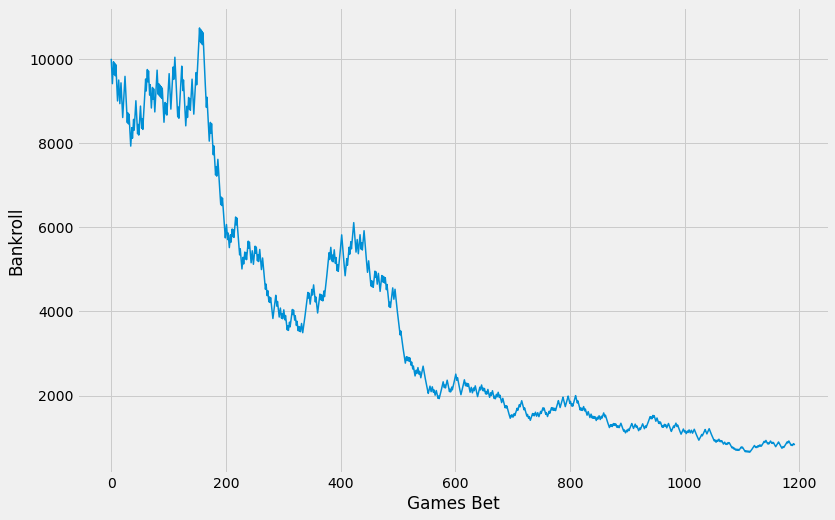

min balance: 656.0562250120652 
max balance: 10732.751495653774 
final balance: 876.7326868454613 
win percentage 49.54


index   GAME_ID MATCHUP_home  spread_home   ml_home   ml_away  \
0         0  21700077  NOP vs. CLE          2.5  2.150000  1.740741   
1         2  21700081  DAL vs. PHI          1.0  2.000000  1.833333   
2         3  21700082  UTA vs. LAL        -11.0  1.181818  5.160000   
3         6  21700086  IND vs. SAS          6.5  3.110000  1.357143   
4         9  21700089  SAC vs. WAS          7.5  3.450000  1.317460   
...     ...       ...          ...          ...       ...       ...   
1188   3484  41900313  DEN vs. LAL          6.0  2.780000  1.370370   
1189   3485  41900304  MIA vs. BOS          3.5  2.380000  1.588235   
1190   3487  41900305  BOS vs. MIA         -3.5  1.591716  2.350000   
1191   3489  41900306  MIA vs. BOS          3.0  2.200000  1.714286   
1192   3492  41900403  MIA vs. LAL          9.5  4.300000  1.210526   

      team_score_home  team_score_away  point_diff_home  cover_home  \
0                 123              101               22           1   
1                 110              112               -2           0   
2                  96               81               15           1   
3                  97               94                3           1   
4                  83              110              -27           0   
...               ...              ...              ...         ...   
1188              114              106                8           1   
1189              112              109                3           1   
1190              121              108               13           1   
1191              125              113               12           1   
1192              115              104               11           1   

      diff_preds_home  diff_preds_away  point_diff_avg  bet_home1  bet_home2  \
0           -5.286433         6.706377       -5.996405          0          0   
1            1.688473        -2.041121        1.864797          1          1   
2           16.526497       -12.045078       14.285788          1          1   
3           -0.282455         3.927421       -2.104938          1          1   
4           -2.712563         5.486457       -4.099510          1          1   
...               ...              ...             ...        ...        ...   
1188        -3.001752         1.109713       -2.055732          1          1   
1189        -0.384528        -0.579774        0.097623          1          1   
1190        -1.734957        -0.263640       -0.735658          0          0   
1191        -0.405491        -1.098192        0.346351          1          1   
1192        -6.543815         6.446358       -6.495087          1          1   

      bet_home3  confidence_pred1  confidence_pred2  confidence_pred3  \
0             0         -2.786433         -4.206377         -3.496405   
1             1          2.688473          3.041121          2.864797   
2             1          5.526497          1.045078          3.285788   
3             1          6.217545          2.572579          4.395062   
4             1          4.787437          2.013543          3.400490   
...         ...               ...               ...               ...   
1188          1          2.998248          4.890287          3.944268   
1189          1          3.115472          4.079774          3.597623   
1190          0         -5.234957         -3.236360         -4.235658   
1191          1          2.594509          4.098192          3.346351   
1192          1          2.956185          3.053642          3.004913   

        bankroll_i   bankroll_n    bet_size  bet_won  
0     10000.000000  9700.000000  300.000000        0  
1      9700.000000  9409.000000  291.000000        0  
2      9409.000000  9665.609091  282.270000        1  
3      9665.609091  9929.216612  289.968273        1  
4      9929.216612  9631.340113  297.876498        0  
...            ...          ...         ...      ...  
1188    811.619422   833.754497   24.348583        1  
1189    833.754497   8

In [88]:
best_xgbr_diff = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.5000000000000001,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=20, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=20, reg_lambda=20, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)


best_xgbr_diff.fit(X_train2, point_diff_train2)

diff_preds_xgbr2_train = best_xgbr_diff.predict(X_train2)
diff_preds_xgbr2 = best_xgbr_diff.predict(X_test2)

mae_diff_train = mean_absolute_error(point_diff_train2, diff_preds_xgbr2_train)
mae_diff_test = mean_absolute_error(point_diff_test2, diff_preds_xgbr2)

print("mae_diff_train:", mae_diff_train, "mae_diff_test:", mae_diff_test)


bets_train = create_betting_df(df_19, diff_preds_xgbr2_train, train_idx2, 3)
print("Train Betting Overall Accuracy:", bets_train['bet_won'].mean())


bets_test = create_betting_df(df_19, diff_preds_xgbr2, test_idx2, 3)
print("Test Betting Overall Accuracy:", bets_test['bet_won'].mean())


bets = create_betting_df(df_19, diff_preds_xgbr2, test_idx2, 3)
select_bets = bets.loc[abs(bets['confidence_pred3']) > 2.8]    
simulate_bets(select_bets)



In [86]:
search_spaces = {'max_depth':Integer(1,40),
              'min_samples_split': Real(0, 0.5),
              'min_samples_leaf': Real(0, 0.5),
              'max_features': Real(0.1, 1)
                }
    
    
rf_bs_diff = BayesSearchCV(RandomForestRegressor(criterion='mae'), search_spaces=search_spaces,
                        cv=tscv, verbose=1, n_jobs=-1, n_iter=50)

rf_bs_diff.fit(X_train1, point_diff_train1)

best_rf_diff = rf_bs_diff.best_estimator_

print("best_rf_diff:", best_rf_diff)

diff_preds_rf = best_rf_diff.predict(X_test1)

select_bets_rf, bet_thresholds_rf = find_optimal_confidence_thresholds(df_19, diff_preds_rf,
                                                                               test_idx1)
simulate_bets(select_bets_rf)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [ ]:


best_rf_diff.fit(X_train2, point_diff_train2)

diff_preds_rf2_train = best_rf_diff.predict(X_train2)
diff_preds_rf2 = best_rf_diff.predict(X_test2)

mae_diff_train = mean_absolute_error(point_diff_test2, diff_preds_rf2)
mae_diff_test = mean_absolute_error(point_diff_test2, diff_preds_rf2)

print("mae_diff_train:", mae_diff_train, "mae_diff_test:", mae_score)


bets_train = create_betting_df(df_19, diff_preds_rf2_train, train_idx2, 3)
print("Train Betting Overall Accuracy:", bets_train['bet_won'].mean())


bets_test = create_betting_df(df_19, diff_preds_rf2, test_idx2, 3)
print("Test Betting Overall Accuracy:", bets_test['bet_won'].mean())


bets = create_betting_df(df_19, diff_preds_rf2, test_idx2, 3)
select_bets = bets.loc[abs(bets['confidence_pred3']) > 1.16]    
simulate_bets(select_bets)



### Stacked Regressor for Spread + Actual Point Diff

[LightGBM] [Warning] feature_fraction is set=0.6880319327164988, colsample_bytree=0.5597090226673742 will be ignored. Current value: feature_fraction=0.6880319327164988
[LightGBM] [Warning] feature_fraction is set=0.6880319327164988, colsample_bytree=0.5597090226673742 will be ignored. Current value: feature_fraction=0.6880319327164988
[LightGBM] [Warning] feature_fraction is set=0.6880319327164988, colsample_bytree=0.5597090226673742 will be ignored. Current value: feature_fraction=0.6880319327164988
[LightGBM] [Warning] feature_fraction is set=0.6880319327164988, colsample_bytree=0.5597090226673742 will be ignored. Current value: feature_fraction=0.6880319327164988
[LightGBM] [Warning] feature_fraction is set=0.6880319327164988, colsample_bytree=0.5597090226673742 will be ignored. Current value: feature_fraction=0.6880319327164988
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fr

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


DONE
best threshold: 2.57
best prediction strat: 1
num_games_bet: 139
win percetange at threshold: 0.5467625899280576


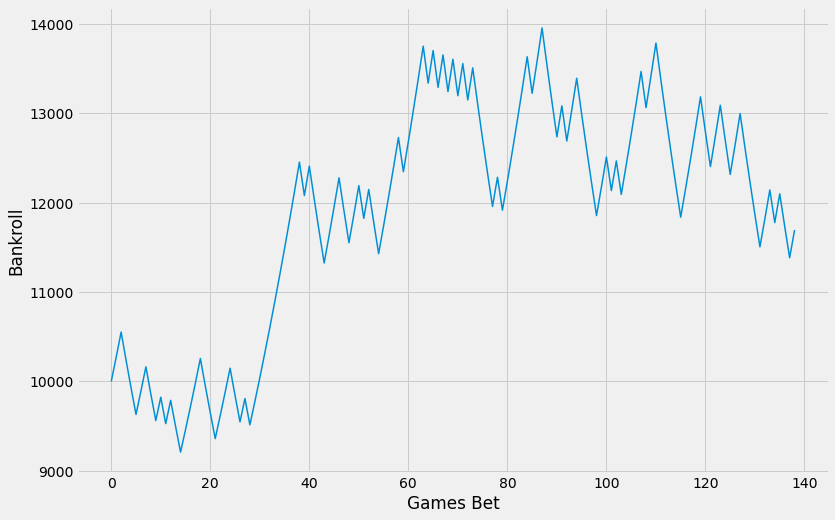

min balance: 9210.61064663862 
max balance: 13953.081540945755 
final balance: 11343.234006175604 
win percentage 54.67999999999999


index   GAME_ID MATCHUP_home  spread_home   ml_home    ml_away  \
0       14  21600099  GSW vs. NOP        -16.5  1.020000  14.000000   
1       18  21600104  LAL vs. DAL         -4.0  1.571429   2.550000   
2       19  21600105  SAC vs. NOP         -6.5  1.377358   3.250000   
3       30  21600116  GSW vs. DAL        -18.5  1.011111  16.000000   
4       60  21600146  NYK vs. DAL         -4.5  1.571429   2.550000   
..     ...       ...          ...          ...       ...        ...   
134   2421  41700222  HOU vs. UTA        -10.5  1.111111   6.500000   
135   2424  41700223  UTA vs. HOU          4.5  2.700000   1.500000   
136   2428  41700224  UTA vs. HOU          6.0  3.250000   1.363636   
137   2432  41700225  HOU vs. UTA        -12.0  1.105263   8.000000   
138   2446  41700316  GSW vs. HOU        -12.5  1.094340   6.500000   

     team_score_home  team_score_away  point_diff_home  cover_home  \
0                116              106               10           0   
1                 97              109              -12           0   
2                102               94                8           1   
3                116               95               21           1   
4                 93               77               16           1   
..               ...              ...              ...         ...   
134              108              116               -8           0   
135               92              113              -21           0   
136               87              100              -13           0   
137              112              102               10           0   
138              115               86               29           1   

     score_pred_home  score_pred_away  score_pred_diff  diff_preds_home  \
0         115.665373       103.116328        12.549045        12.510002   
1         103.015213       102.394952         0.620261         0.372338   
2         104.175348       100.462020         3.713329         3.660422   
3         110.595714        96.194194        14.401520        13.589561   
4          99.729873        97.849858         1.880015         2.157346   
..               ...              ...              ...              ...   
134       106.493511       100.051044         6.442467         9.468062   
135       103.629041       104.481146        -0.852105        -3.323558   
136       101.991785       104.912933        -2.921148        -5.310337   
137       106.434323        97.129343         9.304981        11.033306   
138       108.252063        98.507813         9.744250        11.139353   

     diff_preds_away  point_diff_avg  bet_home1  bet_home2  bet_home3  \
0         -12.202783       12.356392          0          0          0   
1          -0.288476        0.330407          0          0          0   
2          -4.268501        3.964462          0          0          0   
3         -14.765019       14.177290          0          0          0   
4          -2.468437        2.312892          0          0          0   
..               ...             ...        ...        ...        ...   
134        -9.292918        9.380490          0          0          0   
135         3.121235       -3.222397          1          1          1   
136         5.240554       -5.275445          1          1          1   
137       -10.985288       11.009297          0          0          0   
138       -10.669583       10.904468          0          0          0   

     bet_home4  confidence_pred1  confidence_pred2  confidence_pred3  \
0            0         -3.950955         -3.989998         -4.297217   
1            0         -3.379739         -3.627662         -3.711524   
2            0         -2.786671         -2.839578         -2.231499   
3            0         -4.098480         -4.910439         -3.734981   
4            0         -2.619985         -2.342654         -2.031563   
..         ...               ...               ...               ...   
134          0         -4.057

In [718]:
best_sgd_diff= Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=0.007847599703514606, epsilon=1.27427,
                              l1_ratio=1.0, loss='huber', max_iter=5000,
                              penalty='elasticnet'))])
best_sgd_score= Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=0.007847599703514606, epsilon=0.379269,
                              l1_ratio=0.05, loss='huber', max_iter=5000,
                              penalty='elasticnet'))])

best_en_diff= Pipeline(steps=[('scaler', StandardScaler()),
                ('en', ElasticNet(alpha=0.0379269019073225, max_iter=10000))])
best_en_score= Pipeline(steps=[('scaler', StandardScaler()),
                ('en', ElasticNet(alpha=0.0379269019073225, max_iter=10000))])

best_lgbr_diff = lgb.LGBMRegressor(colsample_bytree=0.5597090226673742,
              feature_fraction=0.6880319327164988, max_depth=26,
              min_child_weight=1, num_leaves=2, objective='regression',
              reg_alpha=4, reg_lambda=4, subsample=0.6521226559898796,
              subsample_freq=1)
best_lgbr_score = lgb.LGBMRegressor(colsample_bytree=0.5, feature_fraction=1.0, max_depth=3,
              min_child_weight=1, num_leaves=2, objective='regression',
              reg_alpha=0, reg_lambda=1, subsample=0.6, subsample_freq=1)


best_svr_diff = Pipeline(steps=[('scaler', StandardScaler()),
                ('svr',
                 LinearSVR(C=0.006601838929857076,
                           loss='squared_epsilon_insensitive',
                           max_iter=10000))])
best_svr_score = Pipeline(steps=[('scaler', StandardScaler()),
                ('svr',
                 LinearSVR(C=0.014321013870344837,
                           loss='squared_epsilon_insensitive',
                           max_iter=10000))])


best_xgbr_diff = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=8, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=20, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)
best_xgbr_score =  xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=3.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=6, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=7, reg_lambda=20, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)



estimators_diff = [('sgd', best_sgd_diff), ('en', best_en_diff),
              ('lgbr', best_lgbr_diff), ('svr', best_svr_diff),
              ('xgbr', best_xgbr_diff)]


estimators_score = [('sgd', best_sgd_score), ('en', best_en_score),
              ('lgbr', best_lgbr_score), ('svr', best_svr_score),
              ('xgbr', best_xgbr_score)]


stacked_reg_diff = StackingRegressor(estimators = estimators_diff, final_estimator = LinearRegression())
stacked_reg_score = StackingRegressor(estimators = estimators_score, final_estimator = LinearRegression())

stacked_reg_diff.fit(X_train1, point_diff_train1)
stacked_reg_score.fit(X_train1, team_score_train1)


preds_diff_stacked = stacked_reg_diff.predict(X_test1)
preds_score_stacked = stacked_reg_score.predict(X_test1)

mae_diff = mean_absolute_error(point_diff_test1, preds_diff_stacked)
mae_score = mean_absolute_error(team_score_test1, preds_score_stacked)

print("mae_diff:", mae_diff, "mae_score:", mae_score)


select_bets_stacked, bet_thresholds_stacked = find_optimal_confidence_thresholds(preds_diff_stacked,
                                                                               preds_score_stacked,
                                                                               test_idx1)
simulate_bets(select_bets_stacked)





mae_diff: 9.95435759572954 mae_score: 9.106632707557498


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


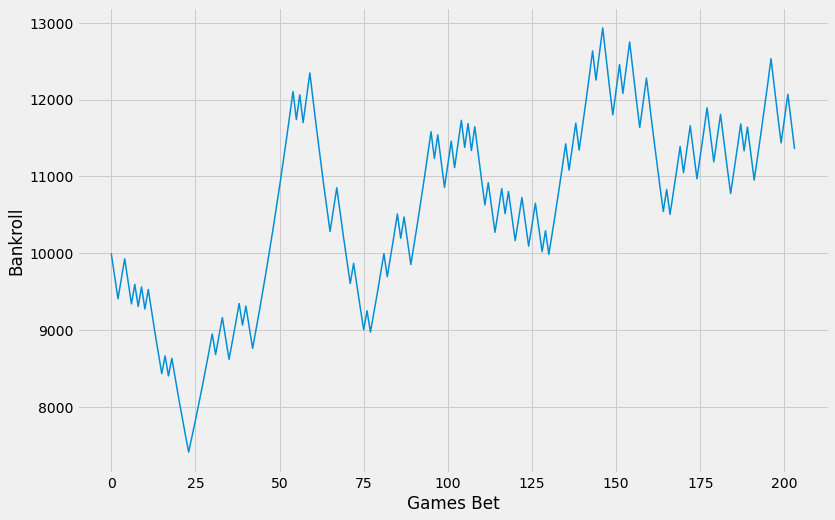

min balance: 7415.63006514196 
max balance: 12930.733935681004 
final balance: 11665.153577202565 
win percentage 54.410000000000004


index   GAME_ID MATCHUP_home  spread_home   ml_home   ml_away  \
0        0  21800068  NYK vs. GSW         11.5  7.350000  1.090909   
1        1  21800077  CLE vs. IND          7.0  3.340000  1.312500   
2       14  21800094  SAS vs. DAL         -7.0  1.333333  3.500000   
3       23  21800103  OKC vs. LAC         -3.5  1.606061  2.400000   
4       32  21800112  CLE vs. DEN          5.0  2.950000  1.425532   
..     ...       ...          ...          ...       ...       ...   
199   2209  41900124  PHI vs. BOS          7.0  3.500000  1.322581   
200   2210  41900154  DAL vs. LAC          7.0  3.370000  1.294118   
201   2212  41900104  ORL vs. MIL         13.0  7.500000  1.090909   
202   2253  41900303  MIA vs. BOS          3.5  2.500000  1.588235   
203   2256  41900304  MIA vs. BOS          3.5  2.380000  1.588235   

     team_score_home  team_score_away  point_diff_home  cover_home  \
0                100              128              -28           0   
1                107              119              -12           0   
2                113              108                5           0   
3                128              110               18           1   
4                 91              110              -19           0   
..               ...              ...              ...         ...   
199              106              110               -4           1   
200              135              133                2           1   
201              106              121              -15           0   
202              106              117              -11           0   
203              112              109                3           1   

     score_pred_home  score_pred_away  score_pred_diff  diff_preds_home  \
0         110.684873       118.902562        -8.217689        -8.749049   
1         105.087605       108.252117        -3.164512        -4.494698   
2         113.759324       110.135718         3.623605         4.567036   
3         117.714054       111.524272         6.189783         4.620460   
4         109.638267       112.003470        -2.365203        -3.521640   
..               ...              ...              ...              ...   
199       109.268474       113.524592        -4.256118        -6.222516   
200       114.150197       118.353777        -4.203580        -6.194501   
201       108.440347       118.718216       -10.277869       -11.874426   
202       105.634646       106.038252        -0.403605        -1.404892   
203       106.520027       106.891577        -0.371550        -1.530278   

     diff_preds_away  point_diff_avg  bet_home1  bet_home2  bet_home3  \
0           9.116440       -8.932745          1          1          1   
1           4.857464       -4.676081          1          1          1   
2          -4.911089        4.739063          0          0          0   
3          -4.392865        4.506663          1          1          1   
4           3.366325       -3.443982          1          1          1   
..               ...             ...        ...        ...        ...   
199         5.993376       -6.107946          1          1          1   
200         5.686170       -5.940335          1          1          1   
201        12.138962      -12.006694          1          1          1   
202         1.914466       -1.659679          1          1          1   
203         1.616869       -1.573573          1          1          1   

     bet_home4  confidence_pred1  confidence_pred2  confidence_pred3  \
0            1          3.282311          2.750951          2.383560   
1            1          3.835488          2.505302          2.142536   
2            0         -3.376395         -2.432964         -2.088911   
3            1          2.689783          1.120460          0.892865   
4            1          2.634797          1.478360          1.633675   
..         ...               ...               ...               ...   
199          1          2.743882         

In [746]:


diff_preds_stacked2 = stacked_reg_diff.predict(X_test2)
score_preds_stacked2 = stacked_reg_score.predict(X_test2)

mae_diff = mean_absolute_error(point_diff_test2, diff_preds_stacked2)
mae_score = mean_absolute_error(team_score_test2, score_preds_stacked2)

print("mae_diff:", mae_diff, "mae_score:", mae_score)

bets = create_betting_df(final_df_ewm_19, diff_preds_stacked2, score_preds_stacked2, test_idx2, 1)
select_bets = bets.loc[abs(bets['confidence_pred1']) > 2.57]    
simulate_bets(select_bets)

In [726]:
bets

GAME_ID MATCHUP_home  spread_home   ml_home   ml_away  team_score_home  \
0     21800068  NYK vs. GSW         11.5  7.350000  1.090909              100   
1     21800077  CLE vs. IND          7.0  3.340000  1.312500              107   
2     21800078  PHI vs. CHA         -7.0  1.285714  3.300000              105   
3     21800081  MIL vs. ORL         -9.0  1.204082  4.450000              113   
4     21800083  BKN vs. GSW          9.5  4.970000  1.166667              114   
...        ...          ...          ...       ...       ...              ...   
2262  41900402  LAL vs. MIA        -11.0  1.157480  4.930000              124   
2263  41900403  MIA vs. LAL          9.5  4.300000  1.210526              115   
2264  41900404  MIA vs. LAL          7.5  3.520000  1.273973               96   
2265  41900405  LAL vs. MIA         -7.5  1.289855  3.070000              108   
2266  41900406  MIA vs. LAL          5.5  3.100000  1.400000               93   

      team_score_away  point_diff_home  cover_home  score_pred_home  \
0                 128              -28           0       110.684873   
1                 119              -12           0       105.087605   
2                 103                2           0       117.215340   
3                  91               22           1       117.282024   
4                 120               -6           1       110.609983   
...               ...              ...         ...              ...   
2262              114               10           0       112.569899   
2263              104               11           1       104.373292   
2264              102               -6           1       105.189925   
2265              111               -3           0       110.494492   
2266              106              -13           0       104.124481   

      score_pred_away  score_pred_diff  diff_preds_home  diff_preds_away  \
0          118.902562        -8.217689        -8.749049         9.116440   
1          108.252117        -3.164512        -4.494698         4.857464   
2          110.007787         7.207553         7.108554        -6.884928   
3          107.344085         9.937939         9.728579        -9.883397   
4          117.683764        -7.073781        -6.980316         7.147828   
...               ...              ...              ...              ...   
2262       102.860998         9.708902        10.701845       -10.594167   
2263       111.834229        -7.460937        -8.584675         9.214850   
2264       111.026675        -5.836750        -6.116125         6.801795   
2265       103.221646         7.272846         7.281286        -5.770666   
2266       109.019763        -4.895283        -4.973356         5.107957   

      point_diff_avg  bet_home1  bet_home2  bet_home3  bet_home4  \
0          -8.932745          1          1          1          1   
1          -4.676081          1          1          1          1   
2           6.996741          1          1          0          0   
3           9.805988          1          1          1          1   
4          -7.064072          1          1          1          1   
...              ...        ...        ...        ...        ...   
2262       10.648006          0          0          0          0   
2263       -8.899762          1          1          1          1   
2264       -6.458960          1          1          1          1   
2265        6.525976          0          0          0          0   
2266       -5.040657          1          1          1          1   

      confidence_pred1  confidence_pred2  confidence_pred3  confidence_pred4  \
0             3.282311          2.750951          2.383560          2.567255   
1             3.835488          2.505302          2.142536          2.323919   
2             0.207553          0.108554         -0.115072         -0.003259   
3             0.937939          0.728579          0.883397          0.805988   
4             2.426219          2.519684          2

### Custom Loss Function LR

In [45]:
import autograd.numpy as np
from autograd import grad

In [70]:
X_train_hd1
# spread_point_diff_train_ewm_19
X_train1.iloc[:, 0].values

array([ -5.5, -10.5,   2.5, ...,  -5.5,  -2. ,  -5. ])

In [86]:
scaler = StandardScaler()
# X_train_ewm_19_scaled = scaler.fit_transform(X_train_ewm_19)
# spread_point_diff_train_ewm_19

X_train1_sc = scaler.fit_transform(X_train1)
X_train2_sc = scaler.fit_transform(X_train2)


weights = np.random.random(X_train1.shape[1])

weights.shape

eps = 1e-15

def wTx(w, x):
    return np.dot(x, w)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def custom_loss(y_true, y_pred):
    residual = (y_pred-y_true).astype(float)
    choicelist = [np.where(y_pred>=0, residual**2, 10*residual**2), 
                  np.where(y_pred+spread<0, residual**2, 10*residual**2)]
    loss = np.where(y_true+spread>=0, choicelist[0], choicelist[1])
    #    loss = torch.mean(-torch.log(torch.sigmoid((torch.sign(target) * (output - target)))))
    return loss

#     return np.mean(-np.log(sigmoid(np.sign(y_true) * (y_pred - y_true))))


def custom_loss_given_weights(w):
    y_predicted = wTx(w, X_train1_scaled)
    return custom_loss(y_train1.values, y_predicted, X_train1.iloc[:, 0].values)


gradient = grad(custom_loss_given_weights)


In [93]:
custom_loss(np.array([2]), np.array([1]), -10)

array([1.])

<AxesSubplot:title={'center':'y_pred vs loss for y=-2'}, xlabel='y_pred'>

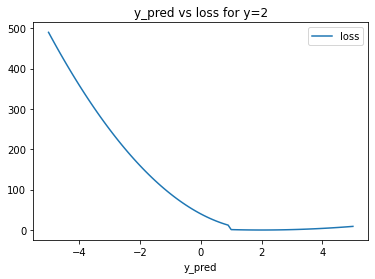

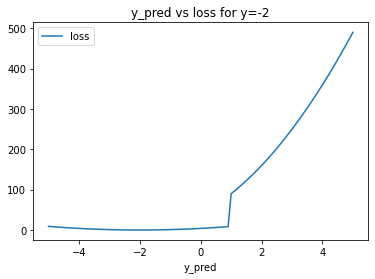

In [88]:
df = pd.DataFrame(
[(y_pred, custom_loss(2, y_pred, -1)) for y_pred in np.linspace(-5, 5, 101)],
columns=['y_pred', 'loss'])
df.astype(float).plot(x='y_pred',  title='y_pred vs loss for y=2')


df = pd.DataFrame(
[(y_pred, custom_loss(-2, y_pred, -1)) for y_pred in np.linspace(-5, 5, 101)],
columns=['y_pred', 'loss'])
df.astype(float).plot(x='y_pred',  title='y_pred vs loss for y=-2')

In [94]:
for i in range(8000):
    if i%1000 == 0:
        print("iteration {}".format(i), "Loss: {}".format(custom_loss_given_weights(weights)))
    weights -= gradient(weights)*0.005

iteration 0 Loss: [ 439.99263672  432.88509045 1710.98213084 ...  212.08825636 8146.84577831
 4019.87024691]


TypeError: Grad only applies to real scalar-output functions. Try jacobian, elementwise_grad or holomorphic_grad.

In [716]:
X_test_ewm_19_scaled = scaler.transform(X_test_ewm_19)
test_preds_custom = wTx(weights, X_test_ewm_19_scaled)
test_preds_custom

array([-2.28919523e-01, -8.65964493e-01,  1.36274241e+00, ...,
       -1.35744142e-03,  3.50963761e+00, -6.83631823e-01])

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 2.2
num_games_bet: 1294
win percetange at threshold: 0.5548686244204019


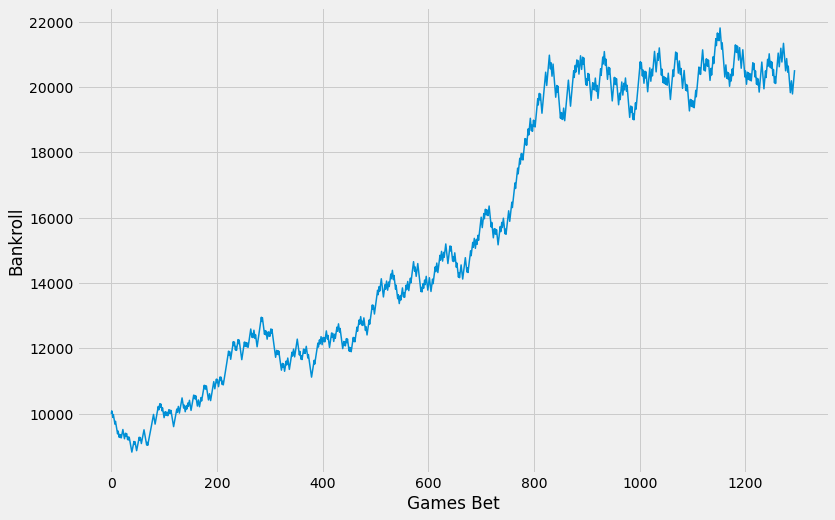

min balance: 8828.84669471551 
max balance: 21810.883064409983 
final balance: 20315.28472156701 
win percentage 55.489999999999995


index  GAME_DATE  spread  point_diff_team  confidence_preds  home_cover  \
0     11777 2016-11-05    -3.5               17          3.157805         1.0   
1     11780 2016-11-05    -4.5              -24          4.544154         0.0   
2     11781 2016-11-06    -4.0               11         -2.989369         1.0   
3     11782 2016-11-06    -7.5               -5         -2.394538         0.0   
4     11786 2016-11-07    -5.5               12         -2.799149         1.0   
...     ...        ...     ...              ...               ...         ...   
1289  16483 2020-09-23     3.5                3          4.655065         1.0   
1290  16486 2020-09-26    -5.5               10          3.713941         1.0   
1291  16487 2020-09-27     3.0               12          3.500975         1.0   
1292  16488 2020-09-30    -4.5               18          3.110749         1.0   
1293  16492 2020-10-09    -7.5               -3          3.509638         0.0   

      bet_home  bet_won    bankroll_i    bankroll_n    bet_size  
0            1        1  10000.000000  10090.909091  100.000000  
1            1        0  10090.909091   9990.000000  100.909091  
2            0        0   9990.000000   9890.100000   99.900000  
3            0        1   9890.100000   9980.010000   98.901000  
4            0        0   9980.010000   9880.209900   99.800100  
...        ...      ...           ...           ...         ...  
1289         1        1  19790.945566  19970.863253  197.909456  
1290         1        1  19970.863253  20152.416555  199.708633  
1291         1        1  20152.416555  20335.620342  201.524166  
1292         1        1  20335.620342  20520.489618  203.356203  
1293         1        0  20520.489618  20315.284722  205.204896  

[1294 rows x 11 columns]

In [717]:
select_bets_custom, best_thresholds_custom = find_optimal_confidence_thresholds(test_preds_custom, X_test_ewm_19.index)
simulate_bets(select_bets_custom)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

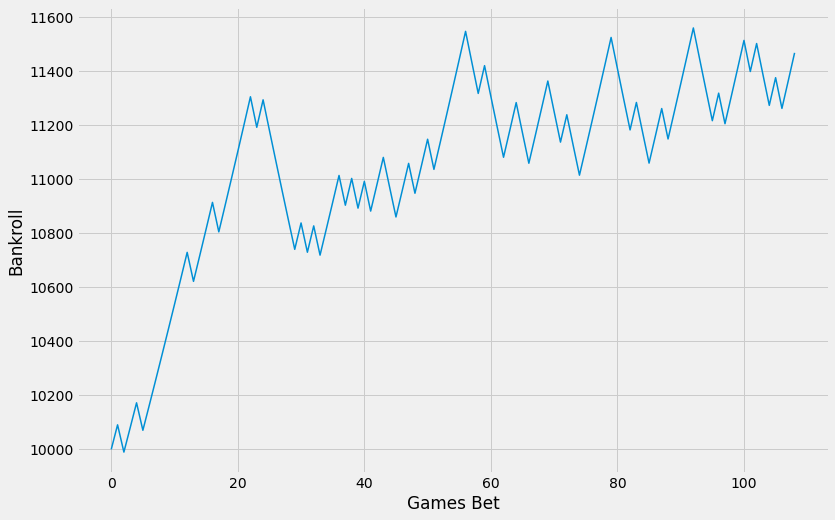

min balance: 9990.0 
max balance: 11572.245758571004 
final balance: 11572.245758571004 
win percentage 59.63


index TEAM_ABBREVIATION  point_diff_team      MATCHUP  home_spread_mode  \
0        0               MIL               30  MIL vs. CHI             -14.5   
1        1               IND               -4  IND vs. NYK              -9.5   
2        3               ATL               -5  ATL vs. CLE              -5.5   
3        6               BKN               -1  BKN vs. WAS              -7.5   
4        7               MEM              -14  MEM vs. LAL              10.0   
..     ...               ...              ...          ...               ...   
104    513               DET                4  DET vs. TOR               6.5   
105    519               POR                8  POR vs. NOP              -1.5   
106    534               LAC               27  LAC vs. CHA              -9.5   
107    540               DEN               -5  DEN vs. NOP              -6.5   
108    544               POR              -40  POR vs. DAL               2.0   

     custom_preds  home_cover  bet_home  bet_won    bankroll_i    bet_size  \
0        4.043642           1         1        1  10000.000000  100.000000   
1        3.905899           0         1        0  10090.909091  100.909091   
2       -4.245147           0         0        1   9990.000000   99.900000   
3       -9.037124           0         0        1  10080.818182  100.808182   
4        5.211821           0         1        0  10172.461983  101.724620   
..            ...         ...       ...      ...           ...         ...   
104      3.953408           1         1        1  11273.565152  112.735652   
105     -4.217931           1         0        0  11376.052108  113.760521   
106      3.445899           1         1        1  11262.291586  112.622916   
107     -4.166171           0         0        1  11364.676055  113.646761   
108     -3.341481           0         0        1  11467.991292  114.679913   

       bankroll_n  
0    10090.909091  
1     9990.000000  
2    10080.818182  
3    10172.461983  
4    10070.737364  
..            ...  
104  11376.052108  
105  11262.291586  
106  11364.676055  
107  11467.991292  
108  11572.245759  

[109 rows x 12 columns]

In [523]:
test_preds_custom = wTx(weights, scaler.transform(full_df_2020[X_train_ewm_19.columns]))


betting_df_2020 = full_df_2020[['TEAM_ABBREVIATION', 'point_diff_team', 'MATCHUP', 'home_spread_mode']]
betting_df_2020['custom_preds'] = test_preds_custom
betting_df_2020['home_cover'] = (betting_df_2020['point_diff_team'] + betting_df_2020['home_spread_mode'] > 0).astype(int)
betting_df_2020['bet_home'] = (betting_df_2020['custom_preds'] > 0).astype(int)
betting_df_2020['bet_won'] = (betting_df_2020['bet_home'] == betting_df_2020['home_cover']).astype(int)
select_bets_2020 = betting_df_2020.loc[(abs(betting_df_2020['custom_preds']) >3.3)]

simulate_bets(select_bets_2020)

### Custom Loss NN Pytorch

In [159]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import TensorDataset, Dataset, DataLoader

In [165]:
torch_scaler = StandardScaler()

X_train1_scaled = torch_scaler.fit_transform(X_train1)
X_test1_scaled = torch_scaler.transform(X_test1)

X_train2_scaled = torch_scaler.fit_transform(X_train2)
X_test2_scaled = torch_scaler.transform(X_test2)


class MatchupDataset(Dataset):
    
    def __init__(self, features, targets):
        self.targets = targets
        self.features = features
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        X = self.features[index]
        y = self.targets[index]
        
        return X, y
    
batch_size = 32

training_set1 = MatchupDataset(X_train1_scaled, point_diff_train1.values)
validation_set1 = MatchupDataset(X_test1_scaled, point_diff_test1.values)

train_loader1 = DataLoader(training_set1, batch_size = batch_size, shuffle=False)
val_loader1 = DataLoader(validation_set1, batch_size = batch_size, shuffle=False)

training_set2 = MatchupDataset(X_train2_scaled, point_diff_train2.values)
validation_set2 = MatchupDataset(X_test2_scaled, point_diff_test2.values)

train_loader2 = DataLoader(training_set2, batch_size = batch_size, shuffle=False)
val_loader2 = DataLoader(validation_set2, batch_size = batch_size, shuffle=False)



In [167]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(X_train1.shape[1], 128)
#         self.bn1 = nn.BatchNorm1d(num_features=128)
        self.fc2 = nn.Linear(128, 64)
#         self.bn2 = nn.BatchNorm1d(num_features=64)
        self.fc3 = nn.Linear(64, 32)
#         self.bn3 = nn.BatchNorm1d(num_features=32)
        self.fc4 = nn.Linear(32, 1)
        
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.dropout(torch.relu(self.fc3(x)))
        x = self.fc4(x)
        return x
        
net = Net() 
print(net)

Net(
  (fc1): Linear(in_features=164, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [170]:
data, target = next(iter(train_loader1))

data.shape, target.shape


tensor([[-0.5300, -0.7841,  0.7678,  ..., -2.0066,  5.9395,  1.9198],
        [ 0.1130,  0.7843, -2.5331,  ..., -1.4197,  2.2465,  0.7733],
        [-0.6477, -1.4970,  1.2753,  ..., -0.6629,  2.6753, -0.4764],
        ...,
        [ 1.0126,  1.2833, -0.4620,  ..., -0.2816,  3.1687,  0.7470],
        [-0.3029,  0.1427, -1.4791,  ..., -0.3367,  2.6873, -1.9751],
        [-0.3392, -0.1425, -2.1125,  ..., -1.4825,  4.0949,  1.2746]],
       dtype=torch.float64)

In [174]:
net = Net()

learning_rate = 0.00001
def my_loss(output, target):
#     residual = (output-target).float()
#     choicelist = [torch.where(output<0, residual**2, 3*residual**2), torch.where(output<0, 3*residual**2, residual**2)]
#     loss = torch.where(target<0, choicelist[0], choicelist[1])
    loss = -torch.log(torch.sigmoid((torch.sign(target) * (output - target))))
    return torch.mean(loss)

loss_function = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0)

epochs = 251

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for e in range(epochs):
    train_loss = 0
    val_loss = 0
    train_correct_preds = 0
    train_total_preds = 0
    
    val_correct_preds = 0
    val_total_preds = 0
 
    net.train()
    
    for (data, target) in  train_loader1:
        optimizer.zero_grad()
        target = target.reshape(-1, 1)
        outputs = net(data.float())
        loss = loss_function(outputs, target.float())
        loss.backward()

        optimizer.step()
        train_loss += loss.item()

#         n_correct_preds = (torch.sign(outputs)==torch.sign(target)).detach().numpy().flatten().astype(int).sum()
#         train_correct_preds += n_correct_preds
#         train_total_preds += outputs.shape[0]
    train_losses.append(train_loss/X_train1.shape[0])
#     train_accuracies.append(round(train_correct_preds / train_total_preds, 4))

    with torch.no_grad():
        net.eval()
        for batch_idx, (data, target) in enumerate(val_loader1):
            target = target.reshape(-1, 1)
            outputs = net(data.float())
            loss = loss_function(outputs, target.float())
            val_loss += loss.item()
#             n_correct_preds = (torch.sign(outputs)==torch.sign(target)).detach().numpy().flatten().astype(int).sum()
#             val_correct_preds += n_correct_preds
#             val_total_preds += outputs.shape[0]

#         val_accuracies.append(round(val_correct_preds / val_total_preds, 4))
        val_losses.append(val_loss/X_test1.shape[0])
        
    if e % 10 == 0:
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.6f}.. ".format(train_loss / X_train1.shape[0]),
             "Test Loss: {:.6f}.. ".format(val_loss / X_test1.shape[0]))


Epoch: 1/251..  Training Loss: 5.691182..  Test Loss: 6.116482.. 
Epoch: 11/251..  Training Loss: 4.766168..  Test Loss: 5.091738.. 
Epoch: 21/251..  Training Loss: 4.662213..  Test Loss: 4.968416.. 
Epoch: 31/251..  Training Loss: 4.574911..  Test Loss: 4.876618.. 
Epoch: 41/251..  Training Loss: 4.500530..  Test Loss: 4.792335.. 
Epoch: 51/251..  Training Loss: 4.438694..  Test Loss: 4.727733.. 
Epoch: 61/251..  Training Loss: 4.384740..  Test Loss: 4.686254.. 
Epoch: 71/251..  Training Loss: 4.358600..  Test Loss: 4.661898.. 
Epoch: 81/251..  Training Loss: 4.350074..  Test Loss: 4.645399.. 
Epoch: 91/251..  Training Loss: 4.331475..  Test Loss: 4.634179.. 
Epoch: 101/251..  Training Loss: 4.298507..  Test Loss: 4.624502.. 
Epoch: 111/251..  Training Loss: 4.284050..  Test Loss: 4.618278.. 
Epoch: 121/251..  Training Loss: 4.285947..  Test Loss: 4.613744.. 
Epoch: 131/251..  Training Loss: 4.277755..  Test Loss: 4.608748.. 
Epoch: 141/251..  Training Loss: 4.280777..  Test Loss: 4.6

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


DONE
best threshold: 1.43
best prediction strat: 2
num_games_bet: 1687
win percetange at threshold: 0.5506816834617665


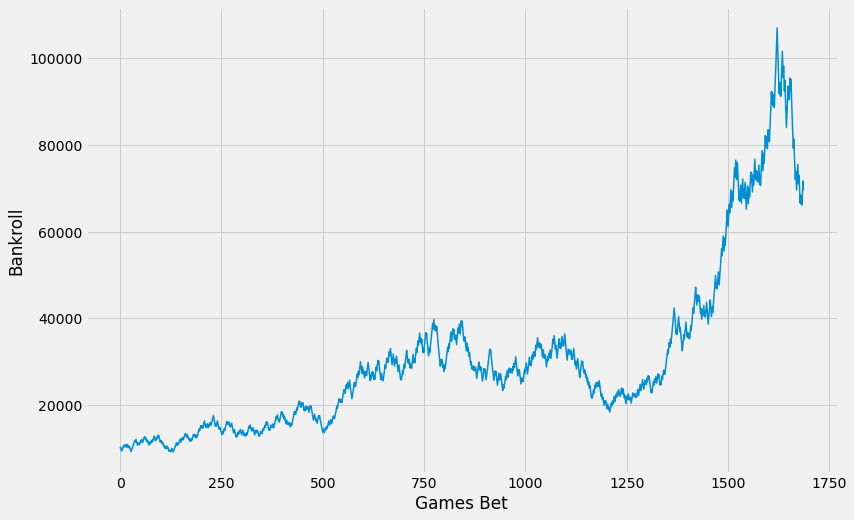

min balance: 9146.413360765744 
max balance: 107011.62198655913 
final balance: 67459.64600870559 
win percentage 55.06999999999999


index   GAME_ID MATCHUP_home  spread_home   ml_home   ml_away  \
0         1  21400077  TOR vs. WAS         -4.0  1.588235  2.500000   
1         3  21400079  PHX vs. SAC         -5.0  1.487805  2.750000   
2         4  21400080  UTA vs. DAL          3.0  2.300000  1.666667   
3         7  21400085  MIA vs. MIN         -8.0  1.277778  3.800000   
4         8  21400086  CHI vs. BOS         -9.5  1.181818  4.750000   
...     ...       ...          ...          ...       ...       ...   
1682   3667  41600401  GSW vs. CLE         -7.5  1.277778  3.400000   
1683   3668  41600402  GSW vs. CLE         -9.0  1.250000  4.300000   
1684   3669  41600403  CLE vs. GSW          3.0  2.200000  1.666667   
1685   3670  41600404  CLE vs. GSW          5.0  2.650000  1.526316   
1686   3671  41600405  GSW vs. CLE         -9.5  1.250000  3.600000   

      point_diff_home  cover_home  diff_preds_home  diff_preds_away  \
0                  19           1         6.798584        -5.694272   
1                  -2           0         8.360832        -8.895329   
2                 -23           0        -0.820187        -0.261227   
3                  10           1         5.328385        -5.221033   
4                  -5           0         4.864081        -6.353915   
...               ...         ...              ...              ...   
1682               22           1        10.896403       -10.691595   
1683               19           1        10.295932       -10.681432   
1684               -5           0        -7.826575         6.985100   
1685               21           1        -8.458477         7.808024   
1686                9           0        11.328000       -11.085841   

      point_diff_avg  bet_home1  bet_home2  bet_home3  confidence_pred1  \
0           6.246428          1          1          1          2.798584   
1           8.628081          1          1          1          3.360832   
2          -0.279480          1          1          1          2.179813   
3           5.274709          0          0          0         -2.671615   
4           5.608998          0          0          0         -4.635919   
...              ...        ...        ...        ...               ...   
1682       10.793999          1          1          1          3.396403   
1683       10.488682          1          1          1          1.295932   
1684       -7.405838          0          0          0         -4.826575   
1685       -8.133250          0          0          0         -3.458477   
1686       11.206921          1          1          1          1.828000   

      confidence_pred2  confidence_pred3    bankroll_i    bankroll_n  \
0             1.694272          2.246428  10000.000000  10272.727273   
1             3.895329          3.628081  10272.727273   9964.545455   
2             3.261227          2.720520   9964.545455   9665.609091   
3            -2.778967         -2.725291   9665.609091   9375.640818   
4            -3.146085         -3.891002   9375.640818   9631.340113   
...                ...               ...           ...           ...   
1682          3.191595          3.293999  66136.820783  67940.552259   
1683          1.681432          1.488682  67940.552259  69793.476411   
1684         -3.985100         -4.405838  69793.476411  71696.934859   
1685         -2.808024         -3.133250  71696.934859  69546.026813   
1686          1.585841          1.706921  69546.026813  67459.646009   

         bet_size  bet_won  
0      300.000000        1  
1      308.181818        0  
2      298.936364        0  
3      289.968273        0  
4      281.269225        1  
...           ...      ...  
1682  1984.104623        1  
1683  2038.216568        1  
1684  2093.804292        1  
1685  2150.908046        0  
1686  2086.380804        0  

[1687 rows x 21 columns]

In [175]:
test_outputs = np.array([])

for data, target in val_loader1:
    outputs = net(data.float())
#     print(outputs.shape)
#     print(test_outputs.shape)
    test_outputs = np.concatenate([test_outputs, outputs.detach().numpy().flatten()])

# correct_pred = (torch.sign(test_outputs)==torch.sign(target)).detach().numpy().flatten()
preds = pd.DataFrame({'preds':test_outputs, 'target':point_diff_test1})
# test_outputs.detach().numpy().flatten()

select_bets_nn, bet_thresholds_nn = find_optimal_confidence_thresholds(df_19, test_outputs,
                                                                               test_idx1)
simulate_bets(select_bets_nn)


In [181]:
bet_thresholds_nn.loc[bet_thresholds_nn['prediction_num']==3]

index  prediction_num  confidence_thresholds  num_games_bet  \
36    2146               3                   1.47           1584   
40    2147               3                   1.48           1567   
41    2189               3                   1.90           1153   
44    2145               3                   1.46           1602   
48    2149               3                   1.50           1548   
..     ...             ...                    ...            ...   
875   2567               3                   5.68             15   
876   2568               3                   5.69             15   
877   2569               3                   5.70             15   
878   2570               3                   5.71             15   
879   2571               3                   5.72             15   

     win_percentage  expected_profits  
36         0.545455              8640  
40         0.544990              8396  
41         0.554206              8388  
44         0.544320              8360  
48         0.544574              8160  
..              ...               ...  
875        0.533333                44  
876        0.533333                44  
877        0.533333                44  
878        0.533333                44  
879        0.533333                44  

[256 rows x 6 columns]

In [216]:
print(len(val_loader2) * 32)

X_test2.shape

7008


(6992, 164)

In [217]:
net = Net()

learning_rate = 0.000005
def my_loss(output, target):
#     residual = (output-target).float()
#     choicelist = [torch.where(output<0, residual**2, 3*residual**2), torch.where(output<0, 3*residual**2, residual**2)]
#     loss = torch.where(target<0, choicelist[0], choicelist[1])
    loss = -torch.log(torch.sigmoid((torch.sign(target) * (output - target))))
    return torch.mean(loss)

loss_function = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0)

epochs = 160

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for e in range(epochs):
    train_loss = 0
    val_loss = 0
    train_correct_preds = 0
    train_total_preds = 0
    
    val_correct_preds = 0
    val_total_preds = 0
 
    net.train()
    
    for (data, target) in  train_loader2:
        optimizer.zero_grad()
        target = target.reshape(-1, 1)
        outputs = net(data.float())
        loss = loss_function(outputs, target.float())
        loss.backward()

        optimizer.step()
        train_loss += loss.item()

#         n_correct_preds = (torch.sign(outputs)==torch.sign(target)).detach().numpy().flatten().astype(int).sum()
#         train_correct_preds += n_correct_preds
#         train_total_preds += outputs.shape[0]
    train_losses.append(train_loss/X_train2.shape[0])
#     train_accuracies.append(round(train_correct_preds / train_total_preds, 4))

    with torch.no_grad():
        net.eval()
        for batch_idx, (data, target) in enumerate(val_loader2):
            target = target.reshape(-1, 1)
            outputs = net(data.float())
            loss = loss_function(outputs, target.float())
            val_loss += loss.item()
#             n_correct_preds = (torch.sign(outputs)==torch.sign(target)).detach().numpy().flatten().astype(int).sum()
#             val_correct_preds += n_correct_preds
#             val_total_preds += outputs.shape[0]

#         val_accuracies.append(round(val_correct_preds / val_total_preds, 4))
        val_losses.append(val_loss/X_test2.shape[0])
        
    if e % 10 == 0:
        print("Epoch: {}/{}.. ".format(e, epochs),
              "Training Loss: {:.6f}.. ".format(train_loss / X_train2.shape[0]),
             "Test Loss: {:.6f}.. ".format(val_loss / X_test2.shape[0]))


Epoch: 0/160..  Training Loss: 5.806562..  Test Loss: 6.386216.. 
Epoch: 10/160..  Training Loss: 5.221600..  Test Loss: 5.761154.. 
Epoch: 20/160..  Training Loss: 4.836733..  Test Loss: 5.370768.. 
Epoch: 30/160..  Training Loss: 4.779824..  Test Loss: 5.300383.. 
Epoch: 40/160..  Training Loss: 4.698755..  Test Loss: 5.242830.. 
Epoch: 50/160..  Training Loss: 4.632791..  Test Loss: 5.191969.. 
Epoch: 60/160..  Training Loss: 4.594651..  Test Loss: 5.150405.. 
Epoch: 70/160..  Training Loss: 4.547083..  Test Loss: 5.117874.. 
Epoch: 80/160..  Training Loss: 4.509670..  Test Loss: 5.097426.. 
Epoch: 90/160..  Training Loss: 4.496081..  Test Loss: 5.084373.. 
Epoch: 100/160..  Training Loss: 4.461044..  Test Loss: 5.077161.. 
Epoch: 110/160..  Training Loss: 4.447700..  Test Loss: 5.073328.. 
Epoch: 120/160..  Training Loss: 4.429356..  Test Loss: 5.069898.. 
Epoch: 130/160..  Training Loss: 4.428498..  Test Loss: 5.068149.. 
Epoch: 140/160..  Training Loss: 4.414505..  Test Loss: 5.0

In [218]:
preds_train2 = net(torch.tensor(X_train2_scaled).float()).detach().numpy()
preds_test2 = net(torch.tensor(X_test2_scaled).float()).detach().numpy()

mae_diff_train: 9.165797430162671 mae_diff_test: 9.885434602811353
Train Betting Overall Accuracy: 0.5407401524777636
Test Betting Overall Accuracy: 0.5099648300117233


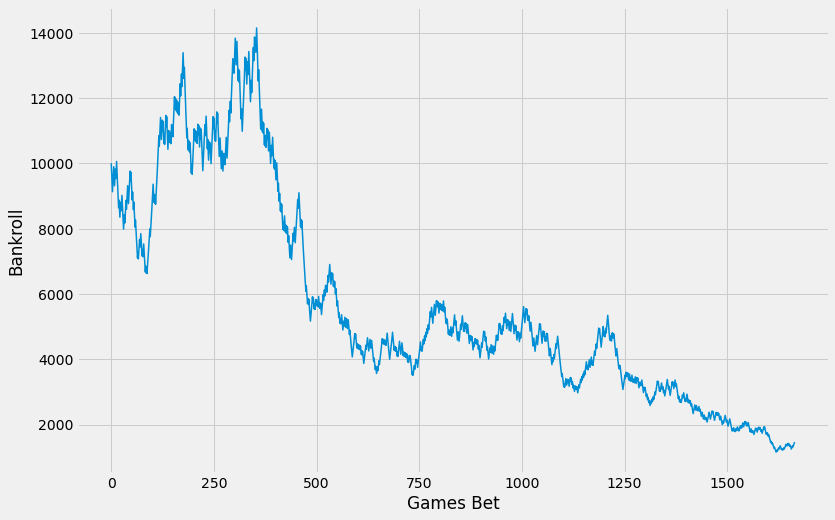

min balance: 1155.4883030792748 
max balance: 14142.122593625492 
final balance: 1502.3531346025138 
win percentage 51.11


index   GAME_ID MATCHUP_home  spread_home   ml_home   ml_away  \
0         0  21700077  NOP vs. CLE          2.5  2.150000  1.740741   
1         1  21700080  MEM vs. HOU         -2.0  1.800000  2.050000   
2         2  21700081  DAL vs. PHI          1.0  2.000000  1.833333   
3         4  21700083  POR vs. PHX        -12.0  1.133333  6.000000   
4         6  21700086  IND vs. SAS          6.5  3.110000  1.357143   
...     ...       ...          ...          ...       ...       ...   
1660   3485  41900304  MIA vs. BOS          3.5  2.380000  1.588235   
1661   3489  41900306  MIA vs. BOS          3.0  2.200000  1.714286   
1662   3491  41900402  LAL vs. MIA        -11.0  1.157480  4.930000   
1663   3492  41900403  MIA vs. LAL          9.5  4.300000  1.210526   
1664   3493  41900404  MIA vs. LAL          7.5  3.520000  1.273973   

      team_score_home  team_score_away  point_diff_home  cover_home  \
0                 123              101               22           1   
1                 103               89               14           1   
2                 110              112               -2           0   
3                 114              107                7           0   
4                  97               94                3           1   
...               ...              ...              ...         ...   
1660              112              109                3           1   
1661              125              113               12           1   
1662              124              114               10           0   
1663              115              104               11           1   
1664               96              102               -6           1   

      diff_preds_home  diff_preds_away  point_diff_avg  bet_home1  bet_home2  \
0           -6.313794         6.844114       -6.578954          0          0   
1           -1.591051         1.323781       -1.457416          0          0   
2           -0.577614        -3.686752        1.554569          1          1   
3            9.790244        -9.372024        9.581134          0          0   
4           -3.780788         2.469774       -3.125281          1          1   
...               ...              ...             ...        ...        ...   
1660        -1.046955        -0.073273       -0.486841          1          1   
1661        -1.202846         0.949766       -1.076306          1          1   
1662         7.784851        -8.259991        8.022421          0          0   
1663        -7.161108         6.006633       -6.583870          1          1   
1664        -6.400207         5.461344       -5.930775          1          1   

      bet_home3  confidence_pred1  confidence_pred2  confidence_pred3  \
0             0         -3.813794         -4.344114         -4.078954   
1             0         -3.591051         -3.323781         -3.457416   
2             1          0.422386          4.686752          2.554569   
3             0         -2.209756         -2.627976         -2.418866   
4             1          2.719212          4.030226          3.374719   
...         ...               ...               ...               ...   
1660          1          2.453045          3.573273          3.013159   
1661          1          1.797154          2.050234          1.923694   
1662          0         -3.215149         -2.740009         -2.977579   
1663          1          2.338892          3.493367          2.916130   
1664          1          1.099793          2.038656          1.569225   

        bankroll_i   bankroll_n    bet_size  bet_won  
0     10000.000000  9700.000000  300.000000        0  
1      9700.000000  9409.000000  291.000000        0  
2      9409.000000  9126.730000  282.270000        0  
3      9126.730000  9375.640818  273.801900        1  
4      9375.640818  9631.340113  281.269225        1  
...            ...          ...         ...      ...  
1660   1313.237380  1349.052944   39.397121        1  
1661   1349.052944  13

In [220]:
mae_diff_train = mean_absolute_error(point_diff_train2, preds_train2)
mae_diff_test = mean_absolute_error(point_diff_test2, preds_test2)

print("mae_diff_train:", mae_diff_train, "mae_diff_test:", mae_diff_test)


bets_train = create_betting_df(df_19, preds_train2, train_idx2, 3)
print("Train Betting Overall Accuracy:", bets_train['bet_won'].mean())


bets_test = create_betting_df(df_19, preds_test2, test_idx2, 3)
print("Test Betting Overall Accuracy:", bets_test['bet_won'].mean())


bets = create_betting_df(df_19, preds_test2, test_idx2, 3)
select_bets = bets.loc[abs(bets['confidence_pred3']) > 1.47]    
simulate_bets(select_bets)


In [224]:
df_19.loc[test_idx2]

SEASON_YEAR_x  SEASON_ID_x   TEAM_ID_x TEAM_ABBREVIATION_x  \
25627       2017-18        22017  1610612739                 CLE   
25628       2017-18        22017  1610612740                 NOP   
25629       2017-18        22017  1610612745                 HOU   
25630       2017-18        22017  1610612763                 MEM   
25631       2017-18        22017  1610612742                 DAL   
...             ...          ...         ...                 ...   
32614       2019-20        42019  1610612748                 MIA   
32615       2019-20        42019  1610612747                 LAL   
32616       2019-20        42019  1610612748                 MIA   
32617       2019-20        42019  1610612747                 LAL   
32618       2019-20        42019  1610612748                 MIA   

                TEAM_NAME_x   GAME_ID GAME_DATE_x    MATCHUP_x  HOME_GAME_x  \
25627   Cleveland Cavaliers  21700077  2017-10-28    CLE @ NOP            0   
25628  New Orleans Pelicans  21700077  2017-10-28  NOP vs. CLE            1   
25629       Houston Rockets  21700080  2017-10-28    HOU @ MEM            0   
25630     Memphis Grizzlies  21700080  2017-10-28  MEM vs. HOU            1   
25631      Dallas Mavericks  21700081  2017-10-28  DAL vs. PHI            1   
...                     ...       ...         ...          ...          ...   
32614            Miami Heat  41900404  2020-10-06  MIA vs. LAL            1   
32615    Los Angeles Lakers  41900405  2020-10-09  LAL vs. MIA            1   
32616            Miami Heat  41900405  2020-10-09    MIA @ LAL            0   
32617    Los Angeles Lakers  41900406  2020-10-11    LAL @ MIA            0   
32618            Miami Heat  41900406  2020-10-11  MIA vs. LAL            1   

       SCORE_team_x  point_diff_team_x  WL_team_x  ml_team_x  spread_team_x  \
25627           101                -22          0   1.740741           -2.5   
25628           123                 22          1   2.150000            2.5   
25629            89                -14          0   2.050000            2.0   
25630           103                 14          1   1.800000           -2.0   
25631           110                 -2          0   2.000000            1.0   
...             ...                ...        ...        ...            ...   
32614            96                 -6          0   3.520000            7.5   
32615           108                 -3          0   1.289855           -7.5   
32616           111                  3          1   3.070000            7.5   
32617           106                 13          1   1.400000           -5.5   
32618            93                -13          0   3.100000            5.5   

       team_covered_team_x  RECORD_team_x  FG2M_team_x  FG2A_team_x  \
25627             0.178018       0.558008    28.831604    52.752582   
25628             0.620009       0.441992    27.862885    53.072550   
25629             0.495026       0.827130    23.330206    37.456167   
25630             0.536031       0.780225    23.483431    47.220898   
25631             0.405499       0.192078    22.757922    52.901191   
...                    ...            ...          ...          ...   
32614             0.667870       0.587760    26.009318    46.942907   
32615             0.411075       0.751238    28.137884    48.969500   
32616             0.701085       0.528980    25.508355    46.548592   
32617             0.369965       0.676109    27.724067    48.472516   
32618             0.730978       0.576085    25.357512    46.893752   

       FG3M_team_x  FG3A_team_x  FTM_team_x  FTA_team_x  OREB_team_x  \
25627    10.590584    29.996386   18.234256   23.556323     9.175820   
25628    11.100266    31.151010   18.730287   25.365657     9.919562   
25629    13.838076    45.005557   17.539535   21.238352     8.579517   
25630     9.488144    28.326512   24.316525   30.991624     7.581134   
25631    11.508141    32.378494   17.439494   23.879040    10.389110   
...   

In [227]:
test = df_19.loc[test_idx2]
(abs(test['spread_team_x'] + test['point_diff_team_x'])).mean()

9.767019450800916

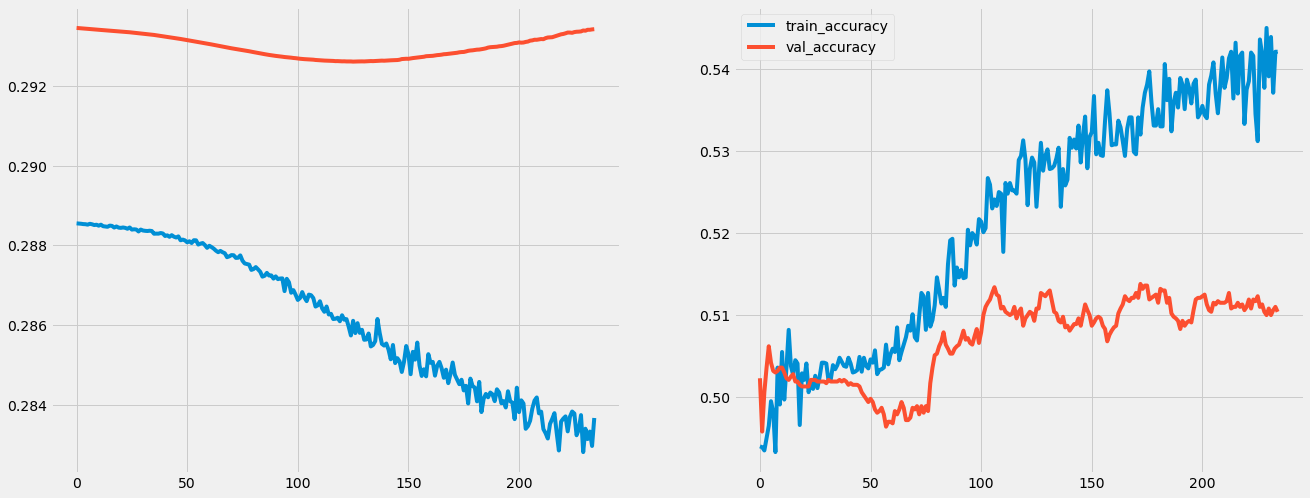

In [492]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].plot(train_losses, label='train_loss')
axs[0].plot(val_losses, label='val_loss')

axs[1].plot(train_accuracies, label='train_accuracy')
axs[1].plot(val_accuracies, label='val_accuracy')
plt.legend()
plt.show()

In [482]:
net2 =Net()

learning_rate = 0.000001
def my_loss(output, target):
    residual = (output-target).float()
    choicelist = [torch.where(output<=0, residual**2, 3*residual**2), torch.where(output<=0, 3*residual**2, residual**2)]
    loss = torch.where(target<=0, choicelist[0], choicelist[1])
#     loss = -torch.log(torch.sigmoid((torch.sign(target) * torch.clamp((output - target), -20, 20))))
    return torch.mean(loss)

loss_function = nn.MSELoss()

optimizer = optim.Adam(net2.parameters(), lr=learning_rate, weight_decay=0)

epochs = 500

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for e in range(epochs):
    train_loss = 0
    val_loss = 0
    train_correct_preds = 0
    train_total_preds = 0
    
    val_correct_preds = 0
    val_total_preds = 0
 
    net2.train()
    
    for (data, target) in  train_loader:
        optimizer.zero_grad()
        target = target.reshape(-1, 1)
        outputs = net2(data.float())
        loss = loss_function(outputs, target.float())
        loss.backward()

        optimizer.step()
        train_loss += loss.item()

        n_correct_preds = (torch.sign(outputs)==torch.sign(target)).detach().numpy().flatten().astype(int).sum()
        train_correct_preds += n_correct_preds
        train_total_preds += outputs.shape[0]
    train_losses.append(train_loss/X_train_ewm_19.shape[0])
    train_accuracies.append(round(train_correct_preds / train_total_preds, 4))

    with torch.no_grad():
        net2.eval()
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target.reshape(-1, 1)
            outputs = net2(data.float())
            loss = loss_function(outputs, target.float())
            val_loss += loss.item()
            n_correct_preds = (torch.sign(outputs)==torch.sign(target)).detach().numpy().flatten().astype(int).sum()
            val_correct_preds += n_correct_preds
            val_total_preds += outputs.shape[0]

        val_accuracies.append(round(val_correct_preds / val_total_preds, 4))
        val_losses.append(val_loss/X_test_ewm_19.shape[0])
        
    if e % 20 == 0:
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.6f}.. ".format(train_loss / X_train_ewm_19.shape[0]),
             "Test Loss: {:.6f}.. ".format(val_loss / X_test_ewm_19.shape[0]),
             "Training Accuracy {:.3f}..".format(train_accuracies[-1]), 
             "Validation Accuracy {:.3f}..".format(val_accuracies[-1]))


Epoch: 1/500..  Training Loss: 4.285663..  Test Loss: 4.377806..  Training Accuracy 0.510.. Validation Accuracy 0.503..
Epoch: 21/500..  Training Loss: 4.285192..  Test Loss: 4.377680..  Training Accuracy 0.512.. Validation Accuracy 0.501..
Epoch: 41/500..  Training Loss: 4.284325..  Test Loss: 4.377541..  Training Accuracy 0.509.. Validation Accuracy 0.503..
Epoch: 61/500..  Training Loss: 4.282853..  Test Loss: 4.377401..  Training Accuracy 0.517.. Validation Accuracy 0.502..
Epoch: 81/500..  Training Loss: 4.284114..  Test Loss: 4.377295..  Training Accuracy 0.510.. Validation Accuracy 0.501..
Epoch: 101/500..  Training Loss: 4.283797..  Test Loss: 4.377206..  Training Accuracy 0.514.. Validation Accuracy 0.501..
Epoch: 121/500..  Training Loss: 4.282302..  Test Loss: 4.377129..  Training Accuracy 0.512.. Validation Accuracy 0.500..
Epoch: 141/500..  Training Loss: 4.282051..  Test Loss: 4.377056..  Training Accuracy 0.514.. Validation Accuracy 0.501..
Epoch: 161/500..  Training Los

KeyboardInterrupt: 

In [493]:
train_outputs = np.array([])
train_outputs2 = np.array([])
train_targets = np.array([])
for data, target in train_loader:
    outputs = net(data.float())
    outputs2 = net2(data.float())
#     print(outputs.shape)
#     print(test_outputs.shape)
    train_outputs = np.concatenate([train_outputs, outputs.detach().numpy().flatten()])
    train_outputs2 = np.concatenate([train_outputs2, outputs2.detach().numpy().flatten()])

    train_targets = np.concatenate([train_targets, target.detach().numpy().flatten()])
# correct_pred = (torch.sign(test_outputs)==torch.sign(target)).detach().numpy().flatten()
train_preds = pd.DataFrame({'preds':train_outputs, 'preds2':train_outputs2, 'target':train_targets})
# test_outputs.detach().numpy().flatten()
train_preds

preds    preds2  target
0     -1.569377 -0.411728     4.5
1      2.848549 -0.101551    -1.5
2     -0.019031 -0.067838     3.5
3      2.170247 -0.185665   -19.5
4     -3.343860 -0.671299   -10.0
...         ...       ...     ...
11767  0.601759  0.044105    28.5
11768  0.989692  0.048848   -13.5
11769  1.633067  0.119707   -20.5
11770  2.350058  0.031689    12.0
11771  0.950963 -0.028231    -9.0

[11772 rows x 3 columns]

In [481]:
train_preds['preds2'].describe()

count    11772.000000
mean        -0.051085
std          0.081908
min         -0.467047
25%         -0.102110
50%         -0.046459
75%          0.006428
max          0.208395
Name: preds2, dtype: float64

In [465]:
y_pred = net(data.float())

preds_df = pd.DataFrame({"y_true":target.detach().numpy().flatten(), "y_pred":y_pred.detach().numpy().flatten()})
preds_df

y_true    y_pred
0     -1.0 -0.362796
1      2.5  0.376909
2    -11.5  0.066797
3      3.0  0.101686
4     -9.5  0.647189
5     13.0  0.814767
6      8.5  0.058365
7     23.0  0.676957
8    -14.0  0.330269
9     20.0  1.236707
10    18.0  0.169000
11     7.5  1.259727
12    21.0  0.347002
13    30.0  0.505747
14    12.0  0.476720
15    25.5  0.541051
16    27.0  0.543965
17     1.5  0.216480
18   -19.5 -2.233496
19   -10.5 -1.027346
20     1.0  1.092786
21     9.0  0.106447
22    27.0  1.016205
23    28.5 -0.454392
24   -13.5  0.548404
25   -20.5  0.498868
26    12.0  1.003339
27    -9.0 -0.123695

In [494]:
test_outputs = np.array([])
test_outputs2 = np.array([])

for data, target in val_loader:
    outputs = net(data.float())
    outputs2 = net2(data.float())
#     print(outputs.shape)
#     print(test_outputs.shape)
    test_outputs = np.concatenate([test_outputs, outputs.detach().numpy().flatten()])
    test_outputs2 = np.concatenate([test_outputs2, outputs2.detach().numpy().flatten()])

# correct_pred = (torch.sign(test_outputs)==torch.sign(target)).detach().numpy().flatten()
preds = pd.DataFrame({'preds':test_outputs, 'preds2':test_outputs2, 'target':spread_point_diff_test_ewm_19})
# test_outputs.detach().numpy().flatten()

In [495]:
preds['bet_won'] = (np.sign(preds['preds']) == np.sign(preds['target'])).astype(int)
print(preds['bet_won'].mean())
preds['pred_probs'] = 1 / (1 + np.exp(-preds['preds']/10))
preds['pred_scaled'] = preds['preds']*10
preds['bet_home'] = (preds['preds'] > 0).astype(int)

0.5010620220900595


In [496]:
preds


preds    preds2  target  bet_won  pred_probs  pred_scaled  bet_home
11772  3.245110  0.129812   -10.5        0    0.580423    32.451100         1
11773 -5.352964 -0.005315    31.5        0    0.369282   -53.529644         0
11774 -0.912930 -0.088472    -3.5        1    0.477193    -9.129300         0
11775  2.345120  0.156321    13.5        1    0.558361    23.451197         1
11776 -0.504047 -0.434542    12.0        0    0.487401    -5.040472         0
...         ...       ...     ...      ...         ...          ...       ...
16475  3.186399  0.029901    -1.0        0    0.578993    31.863995         1
16476  1.176630  0.109124    20.5        1    0.529382    11.766295         1
16477  0.970830  0.048862     1.5        1    0.524252     9.708300         1
16478  1.041771  0.114306   -10.5        0    0.526021    10.417712         1
16479 -0.220044  0.011262    -7.5        1    0.494499    -2.200444         0

[4708 rows x 7 columns]

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 2.32
num_games_bet: 1623
win percetange at threshold: 0.5465187923598275


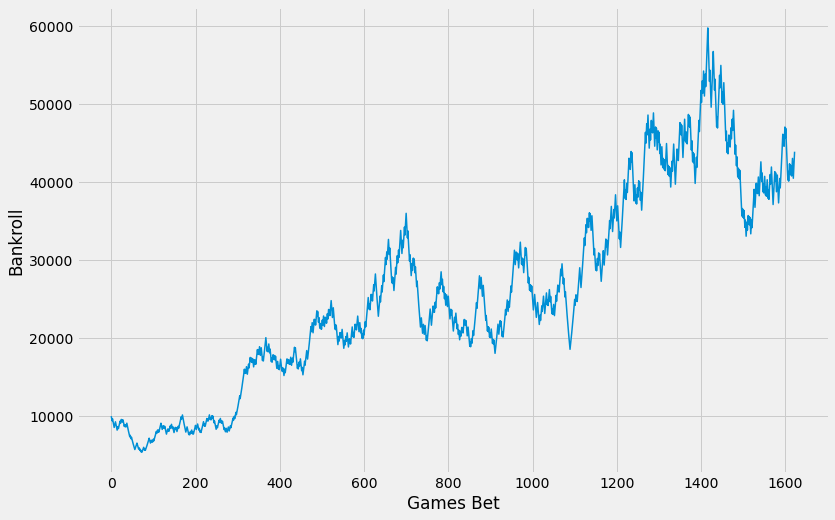

min balance: 5394.227702928191 
max balance: 59766.325969626225 
final balance: 42585.72589427221 
win percentage 54.65


index            GAME_DATE  spread  point_diff_team  confidence_preds  \
0     11772  2016-11-04 00:00:00     3.5            -14.0          3.245110   
1     11773  2016-11-04 00:00:00    11.5             20.0         -5.352964   
2     11775  2016-11-05 00:00:00    -3.5             17.0          2.345120   
3     11778  2016-11-05 00:00:00    -4.5            -24.0          2.687921   
4     11785  2016-11-07 00:00:00    -5.5             12.0         -6.921419   
...     ...                  ...     ...              ...               ...   
1618  16446  2020-09-04 00:00:00    -5.5            -15.0          3.672901   
1619  16448  2020-09-05 00:00:00    -9.0             -9.0         -4.396315   
1620  16450  2020-09-06 00:00:00    -6.0              8.0          2.686229   
1621  16464  2020-09-17 00:00:00    -3.0             -5.0         -4.081581   
1622  16475  2020-10-02 00:00:00   -11.0             10.0          3.186399   

      home_cover  bet_home  bet_won    bankroll_i    bankroll_n     bet_size  
0            0.0         1        0  10000.000000   9700.000000   300.000000  
1            1.0         0        0   9700.000000   9409.000000   291.000000  
2            1.0         1        1   9409.000000   9665.609091   282.270000  
3            0.0         1        0   9665.609091   9375.640818   289.968273  
4            1.0         0        0   9375.640818   9094.371594   281.269225  
...          ...       ...      ...           ...           ...          ...  
1618         0.0         1        0  41750.656697  40498.136996  1252.519701  
1619         0.0         0        1  40498.136996  41602.631641  1214.944110  
1620         1.0         1        1  41602.631641  42737.248868  1248.078949  
1621         0.0         0        1  42737.248868  43902.810200  1282.117466  
1622         0.0         1        0  43902.810200  42585.725894  1317.084306  

[1623 rows x 11 columns]

In [497]:
select_bets_nn, best_thresholds_nn = find_optimal_confidence_thresholds(test_outputs, test_indices)
simulate_bets(select_bets_nn)

In [459]:
(select_bets_nn['confidence_preds']>0).mean()

0.0

### Train NN on Full Data



In [397]:
df_2020 = load_current_season_team_data('2020-21')
df_2020 = clean_team_data(df_2020)
df_2020 = prep_for_aggregation(df_2020)
df_2020 = create_matchups(df_2020)
df_2020 = add_spread_data(df_2020)
df_2020 = get_team_and_opp_ewm(df_2020)
df_2020 = add_rest_days(df_2020)

df_2020 = add_percentage_features(df_2020)

df_2020 = compute_matchup_diffs(df_2020)

df_2020 = add_elo_ratings(df_2020, final_elo_2020)

features_2020 = df_2020[X_train_hd.columns]
features_2020 = features_2020.dropna()

Progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]
progress:: 603it [00:00, 830.59it/s]


In [400]:
spread_point_diff_2020 = df_2020['point_diff_team'] + df_2020['home_spread_mode']
spread_point_diff_2020

0      15.5
1     -13.5
2       5.0
3     -10.5
4      -6.5
       ... 
598    26.5
599     1.0
600    -5.0
601     3.5
602   -18.5
Length: 603, dtype: float64

In [401]:
features_ewm_19.shape, spread_point_diff_ewm_19.shape, features_2020.shape
full_data = pd.concat([features_ewm_19, features_2020])
spread_point_diff_full = pd.concat([spread_point_diff_ewm_19, spread_point_diff_2020])

full_data.shape, spread_point_diff_full.shape

((17083, 90), (17083,))

In [410]:
x = pd.concat([full_data, spread_point_diff_full], axis=1)
x.rename(columns={0:'target'}, inplace=True)
x.to_csv("../data/clean_data_ewm_19.csv", index=False)

In [498]:
nn_scaler = StandardScaler()

full_dataset = MatchupDataset(nn_scaler.fit_transform(full_data), spread_point_diff_full.values)

full_data_loader = DataLoader(full_dataset, batch_size = batch_size, shuffle=False) 

net_full = Net()

learning_rate = 0.00001
def my_loss(output, target):
#     residual = (output-target).float()
#     choicelist = [torch.where(output<0, residual**2, 3*residual**2), torch.where(output<0, 3*residual**2, residual**2)]
#     loss = torch.where(target<0, choicelist[0], choicelist[1])
    loss = -torch.log(torch.sigmoid((torch.sign(target) * (output - target))))
    return torch.mean(loss)

loss_function = nn.MSELoss()

optimizer = optim.Adam(net_full.parameters(), lr=learning_rate, weight_decay=0)

epochs = 131

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for e in tqdm(range(epochs), desc='progress'):
    train_loss = 0
    train_correct_preds = 0
    train_total_preds = 0

    net_full.train()
    
    for (data, target) in  train_loader:
        optimizer.zero_grad()
        target = target.reshape(-1, 1)
        outputs = torch.clamp(net_full(data.float()), -10, 10)
        loss = my_loss(outputs, target.float())
        loss.backward()

        optimizer.step()

progress: 100%|██████████████████████████████████████████████████████████████████████| 131/131 [01:36<00:00,  1.35it/s]


### Test Model on current Season

In [279]:
df_2020 = load_current_season_team_data('2020-21')
df_2020 = clean_team_data(df_2020)
df_2020 = prep_for_aggregation(df_2020)
df_2020 = create_matchups(df_2020)
df_2020 = add_spread_data(df_2020)
df_2020 = get_team_and_opp_ewm(df_2020)
df_2020 = add_rest_days(df_2020)

df_2020 = add_percentage_features(df_2020)

df_2020 = compute_matchup_diffs(df_2020)

Progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


In [280]:
df_2020

SEASON_YEAR  SEASON_ID     TEAM_ID TEAM_ABBREVIATION  \
0       2020-21      22020  1610612749               MIL   
1       2020-21      22020  1610612754               IND   
2       2020-21      22020  1610612755               PHI   
3       2020-21      22020  1610612737               ATL   
4       2020-21      22020  1610612750               MIN   
..          ...        ...         ...               ...   
598     2020-21      22020  1610612746               LAC   
599     2020-21      22020  1610612756               PHX   
600     2020-21      22020  1610612764               WAS   
601     2020-21      22020  1610612743               DEN   
602     2020-21      22020  1610612746               LAC   

                  TEAM_NAME   GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  \
0           Milwaukee Bucks  22000073 2021-01-01  MIL vs. CHI          1   
1            Indiana Pacers  22000080 2021-01-02  IND vs. NYK          1   
2        Philadelphia 76ers  22000082 2021-01-02  PHI vs. CHA          1   
3             Atlanta Hawks  22000083 2021-01-02  ATL vs. CLE          1   
4    Minnesota Timberwolves  22000088 2021-01-03  MIN vs. DEN          1   
..                      ...       ...        ...          ...        ...   
598             LA Clippers  22000717 2021-03-29  LAC vs. MIL          1   
599            Phoenix Suns  22000171 2021-03-30  PHX vs. ATL          1   
600      Washington Wizards  22000718 2021-03-30  WAS vs. CHA          1   
601          Denver Nuggets  22000719 2021-03-30  DEN vs. PHI          1   
602             LA Clippers  22000720 2021-03-30  LAC vs. ORL          1   

     SCORE_team  point_diff_team  WL_team  MIN_team  home_spread_mode  \
0           126               30        1       240             -14.5   
1           102               -4        0       240              -9.5   
2           127               15        1       240             -10.0   
3            91               -5        0       240              -5.5   
4           109              -15        0       240               8.5   
..          ...              ...      ...       ...               ...   
598         129               24        1       240               2.5   
599         117                7        1       240              -6.0   
600         104              -10        0       240               5.0   
601         104                9        1       240              -5.5   
602          96               -7        0       240             -11.5   

     WL_record_diff  ATS_record_diff  RECORD_team_diff  team_covered_diff  \
0          0.000000         0.000000         -0.066177          -0.044199   
1          0.400000         0.400000          0.362653           0.362653   
2          0.400000         0.200000          0.384630           0.224415   
3          0.200000         0.200000          0.244194           0.266172   
4          0.200000         0.200000          0.140436           0.140436   
..              ...              ...               ...                ...   
598        0.000484         0.119923         -0.058671           0.290187   
599        0.181818         0.181818          0.163215           0.222086   
600       -0.159091        -0.045455         -0.266612          -0.074674   
601       -0.086957        -0.086957         -0.027472          -0.061143   
602        0.340580         0.105072          0.481486           0.087948   

     FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  FG3A_team_diff  \
0          1.011550        2.233474        3.260629        3.390149   
1          8.412029        2.926742        0.491954        1.743449   
2         -0.811116       -1.193304       -1.315426       -2.319015   
3         -4.651486      -12.189495        5.570072       12.611292   
4         -2.344070        1.994774       -0.061952        5.374765   
..              ...             ...             ...             ...   
598       -1.596767       -1.511494       -1.080255       -3.813030   


In [281]:
with open('../data/elo_data/final_elo_2020.pkl', 'rb') as file:
    final_elo_2020 = pickle.load(file)

In [282]:
def add_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.copy()
    df = df.loc[df['HOME_GAME'] == 1]
    # Initialize the following columns

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = prev_season_final_elo
    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        home_team_abbr = row['MATCHUP'][:3]
        away_team_abbr = row['MATCHUP'][-3:]
        
        df.loc[idx, 'home_rating_i'] = elo_dic[home_team_abbr]
        df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['SCORE_team']
        away_score = home_score - row['point_diff_team']
        home_rating = elo_dic[home_team_abbr]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return df

df_2020 = add_elo_ratings(df_2020, final_elo_2020)


progress:: 603it [00:00, 716.17it/s]


In [283]:
df_2020.isnull().sum()

SEASON_YEAR          0
SEASON_ID            0
TEAM_ID              0
TEAM_ABBREVIATION    0
TEAM_NAME            0
                    ..
home_rating_i        0
home_rating_n        0
away_rating_i        0
away_rating_n        0
elo_MOV_pred         0
Length: 105, dtype: int64

In [284]:
features_2020 = df_2020[X_train_hd.columns]
features_2020 = features_2020.dropna()
indices_2020 = features_2020.index

In [97]:
with open('../models/best_sgd_hd.pkl', 'rb') as f:
    sgd_pipe_hd = pickle.load(f)
    
with open('../models/best_sgd_hf.pkl', 'rb') as f:
    sgd_pipe_hf = pickle.load(f)
    
# with open('../models/lgbr_ewm_19.pkl', 'rb') as f:
#     best_lgbr = pickle.load(f)
    
# with open('../models/xgb_ewm_19.pkl', 'rb') as f:
#     best_xgbr = pickle.load(f)
    
# with open('../models/rf_ewm_19.pkl', 'rb') as f:
#     best_rf = pickle.load(f)
    
# with open('../models/en_ewm_19.pkl', 'rb') as f:
#     en_pipe = pickle.load(f)
    


    

    


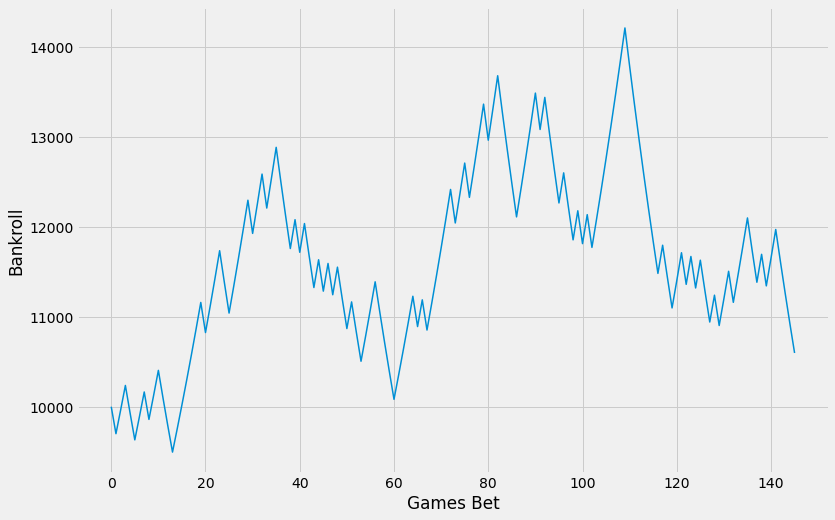

min balance: 9495.474893441879 
max balance: 14210.736110540929 
final balance: 10886.320185706538 
win percentage 54.11


index TEAM_ABBREVIATION  point_diff_team      MATCHUP  home_spread_mode  \
0        1               IND               -4  IND vs. NYK              -9.5   
1        5               DET               -2  DET vs. BOS               8.0   
2        6               BKN               -1  BKN vs. WAS              -7.5   
3        7               MEM              -14  MEM vs. LAL              10.0   
4       10               PHX               -5  PHX vs. LAC               3.5   
..     ...               ...              ...          ...               ...   
141    573               TOR               -4  TOR vs. PHX               3.5   
142    577               NOP               -5  NOP vs. DEN               2.5   
143    587               TOR               -5  TOR vs. POR               2.5   
144    593               HOU              -10  HOU vs. MEM               8.0   
145    598               LAC               24  LAC vs. MIL               2.5   

     en_preds  home_cover  bet_home  bet_won    bankroll_i    bet_size  \
0    3.723771           0         1        0  10000.000000  300.000000   
1    2.559869           1         1        1   9700.000000  291.000000   
2   -4.080041           0         0        1   9964.545455  298.936364   
3    3.573525           0         1        0  10236.305785  307.089174   
4    2.042165           0         1        0   9929.216612  297.876498   
..        ...         ...       ...      ...           ...         ...   
141  5.471833           0         1        0  11970.392977  359.111789   
142  2.881363           0         1        0  11611.281188  348.338436   
143  3.269273           0         1        0  11262.942752  337.888283   
144  3.477994           0         1        0  10925.054470  327.751634   
145  4.485047           1         1        1  10597.302836  317.919085   

       bankroll_n  
0     9700.000000  
1     9964.545455  
2    10236.305785  
3     9929.216612  
4     9631.340113  
..            ...  
141  11611.281188  
142  11262.942752  
143  10925.054470  
144  10597.302836  
145  10886.320186  

[146 rows x 12 columns]

In [224]:
sgd_preds_2020_hd = best_sgd_hd.predict(features_2020.loc[features_2020['home_spread_mode'] >= 0])
sgd_preds_2020_hf = best_sgd_hf.predict(features_2020.loc[features_2020['home_spread_mode'] < 0])

en_preds_2020_hd = best_en_hd.predict(features_2020.loc[features_2020['home_spread_mode'] >= 0])
en_preds_2020_hf = best_en_hf.predict(features_2020.loc[features_2020['home_spread_mode'] < 0])


betting_df_2020 = df_2020.loc[indices_2020, ['TEAM_ABBREVIATION', 'point_diff_team', 'MATCHUP', 'home_spread_mode']]
betting_df_2020['en_preds'] = 0
betting_df_2020.loc[betting_df_2020['home_spread_mode'] >= 0, 'en_preds'] = en_preds_2020_hd
betting_df_2020.loc[betting_df_2020['home_spread_mode'] < 0, 'en_preds'] = en_preds_2020_hf
# betting_df_2020['lgbr_preds'] = lgbr_preds_2020
# betting_df_2020['xgb_preds'] = xgb_preds_2020
# betting_df_2020['rf_preds'] = rf_preds_2020
# betting_df_2020['en_preds'] = en_preds_2020


# betting_df_2020['net_preds'] = net_preds.detach().numpy().flatten()/10
betting_df_2020['home_cover'] = (betting_df_2020['point_diff_team'] + betting_df_2020['home_spread_mode'] > 0).astype(int)
betting_df_2020['bet_home'] = (betting_df_2020['en_preds'] > 0).astype(int)
# betting_df_2020['bet_home'] = ((betting_df_2020['lgbr_preds'] > 0) & (betting_df_2020['sgd_preds'] > 0)).astype(int)
betting_df_2020['bet_won'] = (betting_df_2020['bet_home'] == betting_df_2020['home_cover']).astype(int)
select_bets_2020 = betting_df_2020.loc[((betting_df_2020['home_spread_mode'] >= 0) & (abs(betting_df_2020['en_preds']) > 2.))
                                       | ((betting_df_2020['home_spread_mode'] < 0) & (abs(betting_df_2020['en_preds']) > 2))]
#                                         (abs(betting_df_2020['lgbr_preds']) > 0.4)
#                                       & (abs(betting_df_2020['rf_preds']) > 0.34)]



simulate_bets(select_bets_2020)
# select_bets_2020['bet_won'].mean()


In [384]:
# sgd_preds_2020_hd = sgd_pipe_hd.predict(features_2020.loc[features_2020['home_spread_mode'] > 0])
# sgd_preds_2020_hf = sgd_pipe_hf.predict(features_2020.loc[features_2020['home_spread_mode'] <= 0])

# lgbr_preds_2020 = best_lgbr.predict(features_2020)

# xgb_preds_2020 = xgbr.predict(features_2020)

# rf_preds_2020 = best_rf.predict(features_2020)

# en_preds_2020 = en_pipe.predict(features_2020)

net_preds = net(torch.Tensor(torch_scaler.transform(features_2020))).detach().numpy()

# net_preds

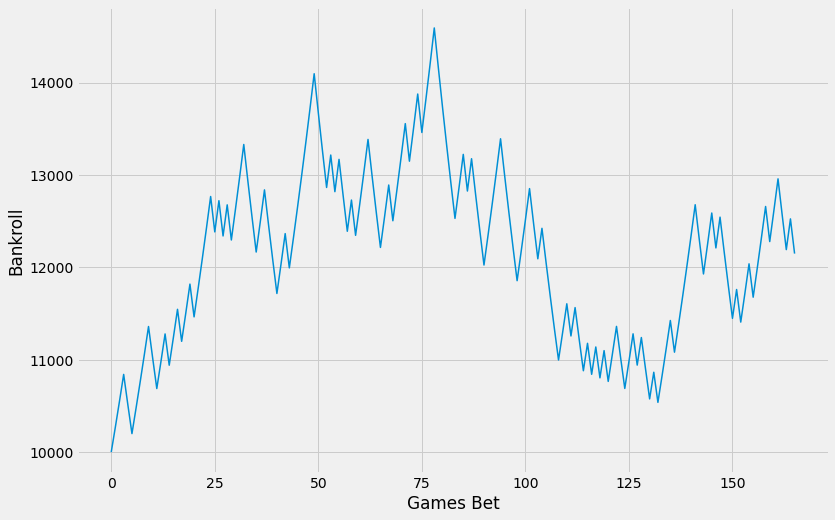

min balance: 10200.013428249435 
max balance: 14590.44129690014 
final balance: 11783.765125935191 
win percentage 54.82


index TEAM_ABBREVIATION  point_diff_team      MATCHUP  home_spread_mode  \
0        3               ATL               -5  ATL vs. CLE              -5.5   
1        4               MIN              -15  MIN vs. DEN               8.5   
2        6               BKN               -1  BKN vs. WAS              -7.5   
3        7               MEM              -14  MEM vs. LAL              10.0   
4        8               SAS              -21  SAS vs. UTA               5.5   
..     ...               ...              ...          ...               ...   
161    548               MIL               27  MIL vs. IND              -7.0   
162    552               MIA              -10  MIA vs. PHX               2.0   
163    589               BOS               -6  BOS vs. NOP              -3.0   
164    593               HOU              -10  HOU vs. MEM               8.0   
165    596               UTA               39  UTA vs. CLE             -16.5   

     spread+diff  net_preds  home_cover  bet_home  bet_won    bankroll_i  \
0          -10.5  -7.630116           0         0        1  10000.000000   
1           -6.5 -17.511482           0         0        1  10272.727273   
2           -8.5 -24.358429           0         0        1  10552.892562   
3           -4.0  10.259763           0         1        0  10840.698723   
4          -15.5   8.119968           0         1        0  10515.477761   
..           ...        ...         ...       ...      ...           ...   
161         20.0  -7.958269           1         0        0  12957.206559   
162         -8.0   7.853865           0         1        0  12568.490362   
163         -9.0  -7.221478           0         0        1  12191.435651   
164         -2.0   8.024974           0         1        0  12523.929351   
165         22.5  -7.486481           1         0        0  12148.211470   

       bet_size    bankroll_n  
0    300.000000  10272.727273  
1    308.181818  10552.892562  
2    316.586777  10840.698723  
3    325.220962  10515.477761  
4    315.464333  10200.013428  
..          ...           ...  
161  388.716197  12568.490362  
162  377.054711  12191.435651  
163  365.743070  12523.929351  
164  375.717881  12148.211470  
165  364.446344  11783.765126  

[166 rows x 13 columns]

In [385]:
betting_df_2020 = df_2020.loc[indices_2020, ['TEAM_ABBREVIATION', 'point_diff_team', 'MATCHUP', 'home_spread_mode']]
betting_df_2020['spread+diff'] = betting_df_2020['home_spread_mode'] + betting_df_2020['point_diff_team']
betting_df_2020['net_preds'] = net_preds
# betting_df_2020.loc[betting_df_2020['home_spread_mode'] > 0, 'sgd_preds'] = sgd_preds_2020_hd
# betting_df_2020.loc[betting_df_2020['home_spread_mode'] <= 0, 'sgd_preds'] = sgd_preds_2020_hf
# betting_df_2020['lgbr_preds'] = lgbr_preds_2020
# betting_df_2020['xgb_preds'] = xgb_preds_2020
# betting_df_2020['rf_preds'] = rf_preds_2020
# betting_df_2020['en_preds'] = en_preds_2020


# betting_df_2020['net_preds'] = net_preds.detach().numpy().flatten()/10
betting_df_2020['home_cover'] = (betting_df_2020['point_diff_team'] + betting_df_2020['home_spread_mode'] > 0).astype(int)
betting_df_2020['bet_home'] = (betting_df_2020['net_preds'] > 0).astype(int)
# betting_df_2020['bet_home'] = ((betting_df_2020['lgbr_preds'] > 0) & (betting_df_2020['sgd_preds'] > 0)).astype(int)
betting_df_2020['bet_won'] = (betting_df_2020['bet_home'] == betting_df_2020['home_cover']).astype(int)
select_bets_2020 = betting_df_2020.loc[abs(betting_df_2020['net_preds']) > 7]
    
                                       # ((betting_df_2020['home_spread_mode'] > 0) & (abs(betting_df_2020['sgd_preds']) > 1.69))
                                      # | ((betting_df_2020['home_spread_mode'] <= 0) & (abs(betting_df_2020['sgd_preds']) > 3.75))]
#                                         (abs(betting_df_2020['lgbr_preds']) > 0.4)
#                                       & (abs(betting_df_2020['rf_preds']) > 0.34)]



simulate_bets(select_bets_2020)
# select_bets_2020['bet_won'].mean()


In [371]:
# select_bets_2020.loc[select_bets_2020['net_preds'] > 0]
betting_df_2020.loc[betting_df_2020['net_preds']>0]

TEAM_ABBREVIATION  point_diff_team      MATCHUP  home_spread_mode  \
14                MIL               10  MIL vs. DET             -16.0   
25                NOP               -1  NOP vs. OKC              -8.0   
28                MIL               15  MIL vs. DET             -12.0   
31                MIA               -2  MIA vs. BOS              -2.5   
40                POR               18  POR vs. MIN             -10.0   
49                BOS                9  BOS vs. WAS              -3.5   
56                MIN               -3  MIN vs. SAS               3.5   
61                HOU              -18  HOU vs. LAL               3.5   
62                NYK              -25  NYK vs. DEN               5.5   
63                LAC                3  LAC vs. CHI             -12.5   
103               POR                6  POR vs. ATL              -5.0   
104               DAL              -16  DAL vs. CHI              -6.5   
116               POR              -21  POR vs. SAS               1.5   
118               UTA               16  UTA vs. NOP              -6.5   
121               LAC               19  LAC vs. SAC             -11.0   
130               GSW              -15  GSW vs. NYK              -5.0   
157               CLE               -7  CLE vs. LAL              12.0   
165               UTA               14  UTA vs. NYK             -11.0   
229               CHA               -7  CHA vs. PHI               7.0   
246               PHI               16  PHI vs. BKN              -7.5   
269               UTA               14  UTA vs. BOS              -5.5   
272               NOP               29  NOP vs. HOU              -6.5   
306               DET               11  DET vs. NOP               5.5   
307               LAC               17  LAC vs. CLE              -9.0   
309               TOR               -4  TOR vs. MIN              -7.5   
316               GSW               31  GSW vs. CLE             -11.0   
348               MIL               13  MIL vs. OKC             -11.0   
352               POR               -7  POR vs. WAS              -4.5   
359               TOR                7  TOR vs. PHI               3.0   
365               UTA               22  UTA vs. CHA             -12.5   
370               LAC               19  LAC vs. WAS             -12.0   
379               UTA               25  UTA vs. LAL              -8.5   
380               PHX               -3  PHX vs. CHA              -9.5   
383               NOP               10  NOP vs. DET             -11.5   
410               HOU              -49  HOU vs. MEM               4.0   
420               HOU              -11  HOU vs. CLE              -3.0   
435               HOU              -18  HOU vs. BKN              10.5   
479               ATL               18  ATL vs. CLE              -5.5   
487               CHA                6  CHA vs. SAC              -3.5   
497               POR                1  POR vs. NOP              -2.0   
537               CLE               11  CLE vs. TOR               7.0   
548               MIL               27  MIL vs. IND              -7.0   
559               ORL                1  ORL vs. PHX               9.5   
572               DET               -2  DET vs. BKN               6.5   

     net_preds  home_cover  bet_home  bet_won  
14    0.176570           0         1        0  
25    0.033497           0         1        0  
28    0.113456           1         1        1  
31    0.000057           0         1        0  
40    0.032014           1         1        1  
49    0.029540           1         1        1  
56    0.087571           1         1        1  
61    0.029953           0         1        0  
62    0.009299           0         1        0  
63    0.000713           0         1        0  
103   0.007039           1         1        1  
104   0.024863           0         1        0  
116   0.015959           0         1        0  
118   0.011476           1         1        1 

In [ ]:
simulate_bets(sgd_preds_2020)

## Make Predictions

ETL Pipeline

### Update Date

In [441]:
from src.data.update_data import update_all_data
from src.data.update_data import update_moneyline_data
from src.data.update_data import update_spread_data

update_all_data(season='2020-21')
update_spread_data(season='2020-21')
update_moneyline_data(season='2020-21')

updating basic team boxscores
updating basic player boxscores
updating advanced boxscores


progress:   0%|                                                                                 | 0/10 [00:00<?, ?it/s]

Updating 10 Games


progress: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.26s/it]


updating scoring boxscores


progress:   0%|                                                                                 | 0/10 [00:00<?, ?it/s]

Updating 10 Games


progress: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.50s/it]


updating tracking boxscores
Updating 10 Games


progress:   0%|                                                                                  | 0/1 [00:00<?, ?it/s]

Updating lines for 1 days


progress:   0%|                                                                                  | 0/1 [00:00<?, ?it/s]

Updating lines for 1 days


progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.00s/it]


### Get Todays Betting Data

In [442]:
from src.models.model_preparation import get_days_spreads
from datetime import datetime
todays_date = datetime.today().strftime('%Y-%m-%d')

todays_spreads = get_days_spreads(todays_date)
todays_spreads = clean_spread_data(todays_spreads)
todays_spreads


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'float'
  warn(f"Unable to sort modes: {err}")
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  warn(f"Unable to sort modes: {err}")


away_team home_team   game_date away_spread1 away_spread2  away_spread3  \
0       DAL       WAS  2021-04-03     -4.5-110     -4.5-112          -4.5   
1       CLE       MIA  2021-04-03       12-110       12-108          12.5   
2       MIN       PHI  2021-04-03       13-110       12-110          13.5   
3       NYK       DET  2021-04-03     -1.5-110     -1.5-113          -1.5   
4       IND       SAS  2021-04-03        6-110      4.5-113           5.5   
5       ORL       UTA  2021-04-03       15-110       15-110          15.0   
6       MIL       SAC  2021-04-03       -6-105     -6.5-110          -5.5   
7       OKC       POR  2021-04-03     11.5-110     11.5-105          11.5   

   away_spread4  home_spread1  home_spread2  home_spread3  home_spread4  \
0          -4.5           4.5           4.5           4.5           4.5   
1          12.0         -12.0         -12.0         -12.5         -12.0   
2          13.0         -13.0         -12.0         -13.5         -13.0   
3          -1.5           1.5           1.5           1.5           1.5   
4           6.0          -6.0          -4.5          -5.5          -6.0   
5          14.5         -15.0         -15.0         -15.0         -14.5   
6          -5.5           6.0           6.5           5.5           5.5   
7          11.5         -11.5         -11.5         -11.5         -11.5   

  away_spread_mode  home_spread_mode  
0             -4.5               4.5  
1             12.5             -12.0  
2           13-110             -13.0  
3             -1.5               1.5  
4            6-110              -6.0  
5           15-110             -15.0  
6             -5.5               5.5  
7             11.5             -11.5

In [443]:
def load_current_season_team_data(season):
    """Loads basic, advanced, and scoring boxscores from
    current season and merges them into one dataframe
    """
    basic_gls = pd.read_csv('../data/current_season_data/team_gamelogs_{}.csv'.format(season))

    adv_gls = pd.read_csv('../data/current_season_data/team_advanced_boxscores_{}.csv'.format(season))

    scoring_gls = pd.read_csv('../data/current_season_data/team_scoring_boxscores_{}.csv'.format(season))

    temp = pd.merge(basic_gls, adv_gls, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])
    full_df = pd.merge(temp, scoring_gls, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])

    full_df = full_df.drop(columns = ['VIDEO_AVAILABLE', 'TEAM_ID_y', 
                                      'TEAM_NAME_y', 'TEAM_CITY', 
                                      'MIN_y', 'TEAM_ID_y',
                                      'TEAM_NAME_y', 'TEAM_CITY_y',
                                      'MIN_y'], errors='ignore')
    
    full_df['SEASON_YEAR'] = season
    
    full_df = full_df[['SEASON_YEAR', 'SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'E_OFF_RATING',
       'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING', 'E_NET_RATING',
       'NET_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT',
       'REB_PCT', 'E_TM_TOV_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT',
       'E_USG_PCT', 'E_PACE', 'PACE', 'PACE_PER40', 'POSS', 'PIE',
       'PCT_FGA_2PT', 'PCT_FGA_3PT', 'PCT_PTS_2PT', 'PCT_PTS_2PT_MR',
       'PCT_PTS_3PT', 'PCT_PTS_FB', 'PCT_PTS_FT', 'PCT_PTS_OFF_TOV',
       'PCT_PTS_PAINT', 'PCT_AST_2PM', 'PCT_UAST_2PM', 'PCT_AST_3PM',
       'PCT_UAST_3PM', 'PCT_AST_FGM', 'PCT_UAST_FGM']]
    return full_df

df = load_current_season_team_data('2020-21')

In [444]:
def get_team_and_opp_ewm_for_model(df, min_periods=5, span=19, adjust=True):
    df = df.copy()
    df = df[['SEASON_YEAR_team', 'SEASON_ID_team', 'TEAM_ID_team',
       'TEAM_ABBREVIATION_team', 'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team',
       'MATCHUP_team', 'HOME_GAME_team', 'TEAM_SCORE_team', 'point_diff_team',
       'WL_team', 'MIN_team', 'home_spread_mode', 'RECORD_team', 'team_covered', 'FG2M_team', 'FG2A_team',
       'FG3M_team', 'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team',
       'DREB_team', 'REB_team', 'AST_team', 'STL_team', 'BLK_team', 'TOV_team',
       'PF_team', 'PTS_team', 'PLUS_MINUS_team', 'E_OFF_RATING_team',
       'OFF_RATING_team', 'E_DEF_RATING_team', 'DEF_RATING_team',
       'E_NET_RATING_team', 'NET_RATING_team', 'POSS_team', 'PIE_team',
       'PTS_2PT_MR_team', 'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team',
       'AST_2PM_team', 'UAST_2PM_team', 'AST_3PM_team', 'UAST_3PM_team',
       'SEASON_YEAR_opp', 'SEASON_ID_opp', 'TEAM_ID_opp',
       'TEAM_ABBREVIATION_opp', 'TEAM_NAME_opp', 'GAME_DATE_opp',
       'MATCHUP_opp', 'HOME_GAME_opp', 'TEAM_SCORE_opp', 'point_diff_opp',
       'WL_opp', 'MIN_opp', 'RECORD_opp', 'FG2M_opp', 'FG2A_opp', 'FG3M_opp',
       'FG3A_opp', 'FTM_opp', 'FTA_opp', 'OREB_opp', 'DREB_opp', 'REB_opp',
       'AST_opp', 'STL_opp', 'BLK_opp', 'TOV_opp', 'PF_opp', 'PTS_opp',
       'PLUS_MINUS_opp', 'E_OFF_RATING_opp', 'OFF_RATING_opp',
       'E_DEF_RATING_opp', 'DEF_RATING_opp', 'E_NET_RATING_opp',
       'NET_RATING_opp', 'POSS_opp', 'PIE_opp', 'PTS_2PT_MR_opp', 'PTS_FB_opp',
       'PTS_OFF_TOV_opp', 'PTS_PAINT_opp', 'AST_2PM_opp', 'UAST_2PM_opp',
       'AST_3PM_opp', 'UAST_3PM_opp', 'home_team', 'away_team', 'game_date',
       'away_spread_mode']]
    
    df = df.drop(columns = ['SEASON_YEAR_opp', 'SEASON_ID_opp', 
                            'TEAM_ID_opp', 'TEAM_ABBREVIATION_opp',
                            'TEAM_NAME_opp', 'GAME_DATE_opp', 
                            'MATCHUP_opp', 'WL_opp', 'HOME_GAME_opp',
                           'point_diff_opp', 'home_team', 'away_team', 'game_date',
                           'away_spread_mode'])
    team_dfs = []

    for team in df['TEAM_ABBREVIATION_team'].unique():
        team_df = df.loc[df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
        team_record = team_df['RECORD_team'].shift(1).expanding().mean()
        ATS_rec = team_df['team_covered'].shift(1).expanding().mean()
        records_df = pd.DataFrame({'WL_record':team_record, 
                                  'ATS_record':ATS_rec})

        team_df.iloc[:, 14:] = team_df.iloc[:, 14:].shift(1).ewm(span = span, min_periods=min_periods).mean()

        team_df = pd.concat([team_df, records_df], axis=1)

        team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)
        
    return new_df


In [445]:
def add_rest_days_for_model(df):
    df['rest'] = np.nan
    for season in df['SEASON_YEAR_team'].unique():
        season_df = df.loc[df['SEASON_YEAR_team'] == season]
        for team in season_df['TEAM_ABBREVIATION_team'].unique():
            team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
            idx = team_df.index
            team_df['rest'] = (team_df['GAME_DATE_team'] - team_df['GAME_DATE_team'].shift(1)) / np.timedelta64(1, 'D')
            df.loc[idx, 'rest'] = team_df['rest']
            
    return df

In [446]:
df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)
df1

SEASON_YEAR_team  SEASON_ID_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
0             2020-21           22020    1610612746                    LAC   
1             2020-21           22020    1610612746                    LAC   
2             2020-21           22020    1610612746                    LAC   
3             2020-21           22020    1610612746                    LAC   
4             2020-21           22020    1610612746                    LAC   
...               ...             ...           ...                    ...   
1421          2020-21           22020    1610612760                    OKC   
1422          2020-21           22020    1610612760                    OKC   
1423          2020-21           22020    1610612760                    OKC   
1424          2020-21           22020    1610612760                    OKC   
1425          2020-21           22020    1610612760                    OKC   

             TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
0               LA Clippers  22000002     2020-12-22    LAC @ LAL   
1               LA Clippers  22000009     2020-12-25    LAC @ DEN   
2               LA Clippers  22000031     2020-12-27  LAC vs. DAL   
3               LA Clippers  22000054     2020-12-29  LAC vs. MIN   
4               LA Clippers  22000061     2020-12-30  LAC vs. POR   
...                     ...       ...            ...          ...   
1421  Oklahoma City Thunder  22000654     2021-03-22    OKC @ MIN   
1422  Oklahoma City Thunder  22000674     2021-03-24  OKC vs. MEM   
1423  Oklahoma City Thunder  22000713     2021-03-29  OKC vs. DAL   
1424  Oklahoma City Thunder  22000727     2021-03-31  OKC vs. TOR   
1425  Oklahoma City Thunder  22000744     2021-04-02    OKC @ PHX   

      HOME_GAME_team  TEAM_SCORE_team  point_diff_team  WL_team  MIN_team  \
0                  0              116                7        1       240   
1                  0              121               13        1       240   
2                  1               73              -51        0       240   
3                  1              124               23        1       240   
4                  1              128               23        1       240   
...              ...              ...              ...      ...       ...   
1421               0              112                9        1       240   
1422               1              107               -9        0       240   
1423               1              106              -21        0       240   
1424               1              113               10        1       240   
1425               0              103              -37        0       240   

      home_spread_mode  WL_record  ATS_record  RECORD_team  team_covered  \
0                 -2.0        NaN         NaN          NaN           NaN   
1                  4.0   1.000000    1.000000          NaN           NaN   
2                 -3.0   1.000000    1.000000          NaN           NaN   
3                -11.0   0.666667    0.666667          NaN           NaN   
4                 -6.0   0.750000    0.750000          NaN           NaN   
...                ...        ...         ...          ...           ...   
1421              -5.0   0.428571    0.523810     0.462632      0.503451   
1422               7.0   0.441860    0.534884     0.516954      0.553647   
1423              11.5   0.431818    0.522727     0.464753      0.497740   
1424               NaN   0.422222    0.511111     0.417868      0.447528   
1425               NaN   0.434783    0.500000     0.476542      0.402421   

      FG2M_team  FG2A_team  FG3M_team  FG3A_team   FTM_team   FTA_team  \
0           NaN        NaN        NaN        NaN        NaN        NaN   
1           NaN        NaN        NaN        NaN        NaN        NaN   
2           NaN        NaN        NaN        NaN        NaN        NaN   
3           NaN        NaN        NaN        NaN        NaN        NaN   
4           NaN        NaN     

In [447]:
df1

SEASON_YEAR_team  SEASON_ID_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
0             2020-21           22020    1610612746                    LAC   
1             2020-21           22020    1610612746                    LAC   
2             2020-21           22020    1610612746                    LAC   
3             2020-21           22020    1610612746                    LAC   
4             2020-21           22020    1610612746                    LAC   
...               ...             ...           ...                    ...   
1421          2020-21           22020    1610612760                    OKC   
1422          2020-21           22020    1610612760                    OKC   
1423          2020-21           22020    1610612760                    OKC   
1424          2020-21           22020    1610612760                    OKC   
1425          2020-21           22020    1610612760                    OKC   

             TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
0               LA Clippers  22000002     2020-12-22    LAC @ LAL   
1               LA Clippers  22000009     2020-12-25    LAC @ DEN   
2               LA Clippers  22000031     2020-12-27  LAC vs. DAL   
3               LA Clippers  22000054     2020-12-29  LAC vs. MIN   
4               LA Clippers  22000061     2020-12-30  LAC vs. POR   
...                     ...       ...            ...          ...   
1421  Oklahoma City Thunder  22000654     2021-03-22    OKC @ MIN   
1422  Oklahoma City Thunder  22000674     2021-03-24  OKC vs. MEM   
1423  Oklahoma City Thunder  22000713     2021-03-29  OKC vs. DAL   
1424  Oklahoma City Thunder  22000727     2021-03-31  OKC vs. TOR   
1425  Oklahoma City Thunder  22000744     2021-04-02    OKC @ PHX   

      HOME_GAME_team  TEAM_SCORE_team  point_diff_team  WL_team  MIN_team  \
0                  0              116                7        1       240   
1                  0              121               13        1       240   
2                  1               73              -51        0       240   
3                  1              124               23        1       240   
4                  1              128               23        1       240   
...              ...              ...              ...      ...       ...   
1421               0              112                9        1       240   
1422               1              107               -9        0       240   
1423               1              106              -21        0       240   
1424               1              113               10        1       240   
1425               0              103              -37        0       240   

      home_spread_mode  WL_record  ATS_record  RECORD_team  team_covered  \
0                 -2.0        NaN         NaN          NaN           NaN   
1                  4.0   1.000000    1.000000          NaN           NaN   
2                 -3.0   1.000000    1.000000          NaN           NaN   
3                -11.0   0.666667    0.666667          NaN           NaN   
4                 -6.0   0.750000    0.750000          NaN           NaN   
...                ...        ...         ...          ...           ...   
1421              -5.0   0.428571    0.523810     0.462632      0.503451   
1422               7.0   0.441860    0.534884     0.516954      0.553647   
1423              11.5   0.431818    0.522727     0.464753      0.497740   
1424               NaN   0.422222    0.511111     0.417868      0.447528   
1425               NaN   0.434783    0.500000     0.476542      0.402421   

      FG2M_team  FG2A_team  FG3M_team  FG3A_team   FTM_team   FTA_team  \
0           NaN        NaN        NaN        NaN        NaN        NaN   
1           NaN        NaN        NaN        NaN        NaN        NaN   
2           NaN        NaN        NaN        NaN        NaN        NaN   
3           NaN        NaN        NaN        NaN        NaN        NaN   
4           NaN        NaN     

In [448]:
prev_season_final_elo = {}
for team in full_df_ewm_19['TEAM_ABBREVIATION'].unique():
    team_df = full_df_ewm_19.loc[full_df_ewm_19['MATCHUP'].str.contains(team)].sort_values('GAME_DATE').reset_index(drop=True)
    if team_df.loc[team_df.shape[0]-1, 'MATCHUP'][:3] == team:
        final_elo = team_df.loc[team_df.shape[0]-1, 'home_rating_n']
    else:
        final_elo = team_df.loc[team_df.shape[0]-1, 'away_rating_n']
    prev_season_final_elo[team] = final_elo
    
    
prev_season_final_elo

{'IND': 1529.4483384275268,
 'HOU': 1540.8964001636646,
 'POR': 1500.1407073118096,
 'LAL': 1684.3757506350337,
 'CLE': 1298.0343645791245,
 'SAS': 1522.744349117492,
 'MIN': 1340.3072979400008,
 'CHI': 1332.027526532048,
 'MIL': 1629.7867944120128,
 'GSW': 1360.7007973857746,
 'SAC': 1516.141852484055,
 'LAC': 1626.6462653315195,
 'MIA': 1618.0421597762124,
 'BOS': 1703.07997468606,
 'NYK': 1326.2237584707232,
 'ATL': 1337.167197222995,
 'NOP': 1499.3615728404923,
 'DAL': 1544.6886733768054,
 'UTA': 1549.7536707979227,
 'DET': 1342.6198199001185,
 'ORL': 1490.8373868097253,
 'BKN': 1467.7010014887078,
 'PHX': 1536.6695679529985,
 'MEM': 1553.2535462864591,
 'DEN': 1584.84073526912,
 'WAS': 1380.5107315006996,
 'CHA': 1394.9240309027477,
 'PHI': 1552.491927190443,
 'TOR': 1676.213996740524,
 'OKC': 1560.4746669932429}

In [449]:
with open("../data/final_elo_2020.pkl", 'wb') as file:
    pickle.dump(prev_season_final_elo, file)
    

In [450]:
# Add ELO ratings
with open("../data/final_elo_2020.pkl", "rb") as file:
    final_elo_2020 = pickle.load(file)


def get_current_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.copy()
    df = df.loc[df['HOME_GAME_team'] == 1]
    # Initialize the following columns
    df = df.sort_values('GAME_DATE_team')

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = prev_season_final_elo
    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        home_team_abbr = row['MATCHUP_team'][:3]
        away_team_abbr = row['MATCHUP_team'][-3:]
        
        df.loc[idx, 'home_rating_i'] = elo_dic[home_team_abbr]
        df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['TEAM_SCORE_team']
        away_score = home_score - row['point_diff_team']
        home_rating = elo_dic[home_team_abbr]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

        elo_dic[home_team_abbr] = df.loc[idx, 'home_rating_n']
        elo_dic[away_team_abbr] = df.loc[idx, 'away_rating_n']

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return elo_dic

elo_ratings_dic = get_current_elo_ratings(df1, final_elo_2020)


progress:: 713it [00:01, 594.18it/s]


In [451]:
sorted(list(elo_ratings_dic.items()), key=lambda x: x[1], reverse=True)

[('UTA', 1695.1116127688701),
 ('DEN', 1643.9932061267505),
 ('PHX', 1643.2505280213047),
 ('PHI', 1641.91906223637),
 ('MIL', 1636.6251277234726),
 ('LAC', 1617.9483674908743),
 ('BKN', 1609.0970800387167),
 ('DAL', 1600.6323347879759),
 ('LAL', 1594.685823621672),
 ('ATL', 1549.0858878760444),
 ('CHA', 1529.246188892717),
 ('MEM', 1529.1740586616115),
 ('MIA', 1522.2233032905194),
 ('POR', 1509.5329643682226),
 ('BOS', 1508.5640846888216),
 ('IND', 1506.1032699853033),
 ('TOR', 1484.370998943311),
 ('NOP', 1460.0619221119289),
 ('NYK', 1459.8277688751557),
 ('SAC', 1454.8135939558026),
 ('SAS', 1445.5081664753009),
 ('GSW', 1443.6002087162024),
 ('CHI', 1422.7871491263463),
 ('OKC', 1406.9973753498114),
 ('DET', 1402.306882583506),
 ('ORL', 1388.455298586604),
 ('WAS', 1371.5658080238677),
 ('CLE', 1342.7394090393968),
 ('MIN', 1326.6109047226719),
 ('HOU', 1290.7402598053923)]

In [452]:
def create_matchup_rows_for_model(df, away_team, home_team, spread, current_elo_dic):
    df = df.copy(deep=True)
    df.rename(columns={'SEASON_YEAR_team':'SEASON_YEAR',
                      'SEASON_ID_team':'SEASON_ID',
                      'TEAM_ID_team':'TEAM_ID',
                      'TEAM_ABBREVIATION_team':'TEAM_ABBREVIATION',
                      'GAME_DATE_team':'GAME_DATE',
                      'MATCHUP_team':'MATCHUP',
                      'HOME_GAME_team':'HOME_GAME',
                       'TEAM_SCORE_team':'SCORE_team'}, inplace=True)
    
    df.sort_values(['GAME_DATE'], inplace=True)
    
    home_stats = df.loc[df['TEAM_ABBREVIATION'] == home_team].reset_index(drop=True)
    home_stats.at[home_stats.shape[0]-1, 'rest'] = (datetime.today() - home_stats.at[home_stats.shape[0]-1, 'GAME_DATE']) // np.timedelta64(1, 'D')
    away_stats = df.loc[df['TEAM_ABBREVIATION'] == away_team].reset_index(drop=True)
    away_stats.at[away_stats.shape[0]-1, 'rest'] = (datetime.today() - away_stats.at[away_stats.shape[0]-1, 'GAME_DATE']) // np.timedelta64(1, 'D')

    diffs = home_stats.iloc[-1, 14:] - away_stats.iloc[-1, 14:]
    diffs = diffs.values.reshape(1, -1)
    
    new_cols = [col+"_diff" for col in home_stats.columns[14:]]
    
    diffs = pd.DataFrame(diffs, columns=new_cols)
        
    diffs['home_rating_i'] = current_elo_dic[home_team]
    diffs['away_rating_i'] = current_elo_dic[away_team]
    diffs['home_elo_pred'] = 1.0/(1 + 10 ** (( diffs['away_rating_i'] - diffs['home_rating_i']) / (400.0)))

    diffs['elo_MOV_pred'] = round((diffs['home_rating_i']+100 - diffs['away_rating_i'])/28, 2)
    diffs['home_spread_mode'] = spread 
    
    diffs = diffs[X_train_ewm_19.columns]
    
    return diffs

create_matchup_rows_for_model(df1, 'OKC', 'MIN', -3, current_elo_dic=elo_ratings_dic)

home_spread_mode WL_record_diff ATS_record_diff RECORD_team_diff  \
0                -3      -0.179463      -0.0744681        -0.130346   

  team_covered_diff FG2M_team_diff FG2A_team_diff FG3M_team_diff  \
0         0.0100565       0.771314        1.38298   -0.000764037   

  FG3A_team_diff FTM_team_diff FTA_team_diff OREB_team_diff DREB_team_diff  \
0        3.60108       1.18658      0.615254        -0.3409       -3.48034   

  REB_team_diff AST_team_diff STL_team_diff BLK_team_diff TOV_team_diff  \
0      -3.82125       3.28415       2.38366      0.670353      -2.05369   

  PF_team_diff PTS_team_diff PLUS_MINUS_team_diff E_OFF_RATING_team_diff  \
0      3.52316       2.72691            -0.580535              -0.945318   

  OFF_RATING_team_diff E_DEF_RATING_team_diff DEF_RATING_team_diff  \
0              1.11265              -0.177191               1.1315   

  E_NET_RATING_team_diff NET_RATING_team_diff POSS_team_diff PIE_team_diff  \
0              -0.786312           -0.0324955        1.48803   -0.00496232   

  PTS_2PT_MR_team_diff PTS_FB_team_diff PTS_OFF_TOV_team_diff  \
0             -1.20019          3.19163               4.46767   

  PTS_PAINT_team_diff AST_2PM_team_diff UAST_2PM_team_diff AST_3PM_team_diff  \
0             2.72338           2.67205           -1.99951          0.718132   

  UAST_3PM_team_diff TEAM_SCORE_opp_diff RECORD_opp_diff FG2M_opp_diff  \
0          -0.695025             3.30745        0.130346     -0.135756   

  FG2A_opp_diff FG3M_opp_diff FG3A_opp_diff FTM_opp_diff FTA_opp_diff  \
0       1.99365      0.416147       -3.4697      2.33052      2.30673   

  OREB_opp_diff DREB_opp_diff REB_opp_diff AST_opp_diff STL_opp_diff  \
0   -0.00117765       2.07533      2.07415      2.90665     -2.29005   

  BLK_opp_diff TOV_opp_diff PF_opp_diff PTS_opp_diff PLUS_MINUS_opp_diff  \
0     0.671452      3.54816    0.931445      3.30745            0.580535   

  E_OFF_RATING_opp_diff OFF_RATING_opp_diff E_DEF_RATING_opp_diff  \
0             -0.177191              1.1315             -0.945318   

  DEF_RATING_opp_diff E_NET_RATING_opp_diff NET_RATING_opp_diff POSS_opp_diff  \
0             1.11265              0.786312           0.0324955       1.81846   

  PIE_opp_diff PTS_2PT_MR_opp_diff PTS_FB_opp_diff PTS_OFF_TOV_opp_diff  \
0   0.00496232             1.39736         3.59304             -4.42725   

  PTS_PAINT_opp_diff AST_2PM_opp_diff UAST_2PM_opp_diff AST_3PM_opp_diff  \
0           -1.72532          2.22005          -2.37193         0.657797   

  UAST_3PM_opp_diff OREB_PCT_team_diff OREB_PCT_opp_diff DREB_PCT_team_diff  \
0         -0.346865         -0.0158015          0.017094          -0.017094   

  DREB_PCT_opp_diff REB_PCT_team_diff REB_PCT_opp_diff TS_PCT_team_diff  \
0         0.0158015        -0.0326693        0.0326693       -0.0169042   

  TS_PCT_opp_diff EFG_PCT_team_diff EFG_PCT_opp_diff AST_RATIO_team_diff  \
0       0.0238796        -0.0201873        0.0145145             2.89928   

  AST_RATIO_opp_diff TOV_PCT_team_diff TOV_PCT_opp_diff rest_diff  \
0            2.42549          -2.17765          2.81216         0   

   home_elo_pred  home_rating_i  away_rating_i  elo_MOV_pred  
0       0.386336    1326.610905    1406.997375           0.7

### Make Predictions

In [453]:
todays_spreads = get_days_spreads(todays_date)
todays_spreads = clean_spread_data(todays_spreads)
todays_spreads

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'float'
  warn(f"Unable to sort modes: {err}")
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  warn(f"Unable to sort modes: {err}")


away_team home_team   game_date away_spread1 away_spread2  away_spread3  \
0       DAL       WAS  2021-04-03     -4.5-110     -4.5-112          -4.5   
1       CLE       MIA  2021-04-03       12-110       12-108          12.5   
2       MIN       PHI  2021-04-03       13-110       12-110          13.5   
3       NYK       DET  2021-04-03     -1.5-110     -1.5-113          -1.5   
4       IND       SAS  2021-04-03        6-110      4.5-113           5.5   
5       ORL       UTA  2021-04-03       15-110       15-110          15.0   
6       MIL       SAC  2021-04-03       -6-105     -6.5-110          -5.5   
7       OKC       POR  2021-04-03     11.5-110     11.5-105          11.5   

   away_spread4  home_spread1  home_spread2  home_spread3  home_spread4  \
0          -4.5           4.5           4.5           4.5           4.5   
1          12.0         -12.0         -12.0         -12.5         -12.0   
2          13.0         -13.0         -12.0         -13.5         -13.0   
3          -1.5           1.5           1.5           1.5           1.5   
4           6.0          -6.0          -4.5          -5.5          -6.0   
5          14.5         -15.0         -15.0         -15.0         -14.5   
6          -5.5           6.0           6.5           5.5           5.5   
7          11.5         -11.5         -11.5         -11.5         -11.5   

  away_spread_mode  home_spread_mode  
0             -4.5               4.5  
1             12.5             -12.0  
2           13-110             -13.0  
3             -1.5               1.5  
4            6-110              -6.0  
5           15-110             -15.0  
6             -5.5               5.5  
7             11.5             -11.5

In [39]:
# Load Models

with open('../models/sgd_ewm_19.pkl', 'rb') as f:
    sgd_pipe = pickle.load(f)
    
with open('../models/lgbr_ewm_19.pkl', 'rb') as f:
    best_lgbr = pickle.load(f)
    
with open('../models/xgb_ewm_19.pkl', 'rb') as f:
    best_xgbr = pickle.load(f)
    
with open('../models/rf_ewm_19.pkl', 'rb') as f:
    best_rf = pickle.load(f)
    
with open('../models/en_ewm_19.pkl', 'rb') as f:
    en_pipe = pickle.load(f)
    
with open("../models/lasso_ewm_19.pkl", 'rb') as f:
    lasso_pipe = pickle.load(f)

In [327]:

df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

create_matchup_rows_for_model(df1, 'OKC', 'MIN', -3, current_elo_dic=elo_ratings_dic)


home_spread_mode WL_record_diff ATS_record_diff RECORD_team_diff  \
0                -3      -0.183092      -0.0763285        -0.144892   

  team_covered_diff FG2M_team_diff FG2A_team_diff FG3M_team_diff  \
0          0.011143        1.19352        2.20987   -0.000726966   

  FG3A_team_diff FTM_team_diff FTA_team_diff OREB_team_diff DREB_team_diff  \
0         3.2203       1.87994       1.69273       0.741648       -2.30137   

  REB_team_diff AST_team_diff STL_team_diff BLK_team_diff TOV_team_diff  \
0      -1.55972       2.97972       1.86619      0.521539      -1.49935   

  PF_team_diff PTS_team_diff PLUS_MINUS_team_diff E_OFF_RATING_team_diff  \
0      4.14165        4.2648             0.363874               0.192724   

  OFF_RATING_team_diff E_DEF_RATING_team_diff DEF_RATING_team_diff  \
0              2.11145               0.115911              1.12315   

  E_NET_RATING_team_diff NET_RATING_team_diff POSS_team_diff PIE_team_diff  \
0              0.0677887             0.984322        1.99059   -0.00237432   

  PTS_2PT_MR_team_diff PTS_FB_team_diff PTS_OFF_TOV_team_diff  \
0             -1.44673          3.10111               3.84759   

  PTS_PAINT_team_diff AST_2PM_team_diff UAST_2PM_team_diff AST_3PM_team_diff  \
0             3.58807           2.97124           -1.88749         0.0143575   

  UAST_3PM_team_diff TEAM_SCORE_opp_diff RECORD_opp_diff FG2M_opp_diff  \
0          -0.100572             3.90093        0.144892       -1.1599   

  FG2A_opp_diff FG3M_opp_diff FG3A_opp_diff FTM_opp_diff FTA_opp_diff  \
0      0.536119       1.02301      -1.28157      3.15171      2.90113   

  OREB_opp_diff DREB_opp_diff REB_opp_diff AST_opp_diff STL_opp_diff  \
0   -0.00155193       1.63512      1.63357      3.34388     -1.87421   

  BLK_opp_diff TOV_opp_diff PF_opp_diff PTS_opp_diff PLUS_MINUS_opp_diff  \
0     0.858817      2.82509     1.82035      3.90093           -0.363874   

  E_OFF_RATING_opp_diff OFF_RATING_opp_diff E_DEF_RATING_opp_diff  \
0              0.115911             1.12315              0.192724   

  DEF_RATING_opp_diff E_NET_RATING_opp_diff NET_RATING_opp_diff POSS_opp_diff  \
0             2.11145            -0.0677887           -0.984322       2.35787   

  PIE_opp_diff PTS_2PT_MR_opp_diff PTS_FB_opp_diff PTS_OFF_TOV_opp_diff  \
0   0.00237432            0.095416         3.99595              -3.6913   

  PTS_PAINT_opp_diff AST_2PM_opp_diff UAST_2PM_opp_diff AST_3PM_opp_diff  \
0           -2.36804          2.24413          -3.42199           1.1797   

  UAST_3PM_opp_diff OREB_PCT_team_diff OREB_PCT_opp_diff DREB_PCT_team_diff  \
0         -0.161641         0.00481673         0.0116754         -0.0116754   

  DREB_PCT_opp_diff REB_PCT_team_diff REB_PCT_opp_diff TS_PCT_team_diff  \
0       -0.00481673         -0.017652         0.017652       -0.0128075   

  TS_PCT_opp_diff EFG_PCT_team_diff EFG_PCT_opp_diff AST_RATIO_team_diff  \
0       0.0213821         -0.017978       0.00875831              2.4739   

  AST_RATIO_opp_diff TOV_PCT_team_diff TOV_PCT_opp_diff rest_diff  \
0            2.70151          -1.85381           2.1216         0   

   home_elo_pred  home_rating_i  away_rating_i  elo_MOV_pred  
0       0.383526    1329.036655    1411.484854          0.63

In [514]:
matchup_row = create_matchup_rows_for_model(df1, 'DAL', 'WAS', 20, current_elo_dic=elo_ratings_dic)
print(matchup_row.shape)
net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

(1, 90)


tensor([[-2.6207]], grad_fn=<AddmmBackward>)

In [403]:
net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

tensor([[0.0996]], grad_fn=<AddmmBackward>)

In [500]:


df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

elo_ratings_dic = get_current_elo_ratings(df1, final_elo_2020)



away_teams = []
home_teams = []
spreads = []
game_dates = []
# sgd_preds = []
# lgb_preds = []
# xgb_preds = []
# rf_preds = []
# en_preds = []
# lasso_preds = []
# svm_preds = []
# custom_loss_lr_preds = []
net_preds = []

for row in todays_spreads.itertuples(index=False):
    away_team = row.away_team
    home_team = row.home_team
    spread = row.home_spread_mode
    game_date = row.game_date
    matchup_row = create_matchup_rows_for_model(df1, away_team, home_team, spread, elo_ratings_dic)
    matchup_row = matchup_row.astype(float)
#     sgd_pred = sgd_pipe.predict(matchup_row)
#     lgb_pred = best_lgbr.predict(matchup_row)
#     xgb_pred = best_xgbr.predict(matchup_row)
#     rf_pred = best_rf.predict(matchup_row)
#     en_pred = en_pipe.predict(matchup_row)
#     lasso_pred = lasso_pipe.predict(matchup_row)
#     svm_pred = linear_svm.predict(matchup_row)
#     custom_loss_lr_pred = wTx(weights, scaler.transform(matchup_row))
    net_pred = net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

    
    
    away_teams.append(away_team)
    home_teams.append(home_team)
    spreads.append(spread)
    game_dates.append(game_date)
#     lgb_preds.append(lgb_pred[0])
#     sgd_preds.append(sgd_pred[0])
#     xgb_preds.append(xgb_pred[0])
#     lasso_preds.append(lasso_pred[0])
#     rf_preds.append(rf_pred[0])
#     en_preds.append(en_pred[0])
#     svm_preds.append(svm_pred[0])
#     custom_loss_lr_preds.append(custom_loss_lr_pred[0])
    net_preds.append(net_pred.detach().numpy()[0])
       
preds_df = pd.DataFrame({'away_team':away_teams,
                        'home_team':home_teams,
                        'spread':spreads,
                        'game_date':game_dates,
#                          'sgd_pred':sgd_preds,
#                         'lgb_pred':lgb_preds,
#                          'xgb_pred':xgb_preds,
#                          'rf_pred':rf_preds,
#                          'en_pred':en_preds,
#                          'lasso_pred':lasso_preds,
                        'net_pred':net_preds})
#                         'svm_pred':svm_preds,
#                         'custom_loss_lr_pred':custom_loss_lr_preds})

preds_df

progress:: 713it [00:00, 768.00it/s]


away_team home_team  spread   game_date        net_pred
0       DAL       WAS     4.5  2021-04-03    [-2.0314543]
1       CLE       MIA   -12.0  2021-04-03    [-0.7431023]
2       MIN       PHI   -13.0  2021-04-03     [-2.774469]
3       NYK       DET     1.5  2021-04-03    [0.21155608]
4       IND       SAS    -6.0  2021-04-03    [-1.0953536]
5       ORL       UTA   -15.0  2021-04-03  [-0.026118085]
6       MIL       SAC     5.5  2021-04-03    [0.10418765]
7       OKC       POR   -11.5  2021-04-03     [-2.474314]

In [ ]:


df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

elo_ratings_dic = get_current_elo_ratings(df1, final_elo_2020)



away_teams = []
home_teams = []
spreads = []
game_dates = []
sgd_preds = []
lgb_preds = []
xgb_preds = []
rf_preds = []
en_preds = []
lasso_preds = []
# svm_preds = []
# custom_loss_lr_preds = []
net_preds = []

for row in todays_spreads.itertuples(index=False):
    away_team = row.away_team
    home_team = row.home_team
    spread = row.home_spread_mode
    game_date = row.game_date
    matchup_row = create_matchup_rows_for_model(df1, away_team, home_team, spread, elo_ratings_dic)
    matchup_row = matchup_row.astype(float)

    if spread >= 0:
        
        sgd_pred = sgd_hd.predict(matchup_row)
        en_pred = en_pipe_hd.predict(matchup_row)

        lgb_pred = best_lgbr_hd.predict(matchup_row)
        xgb_pred = best_xgbr_hd.predict(matchup_row)
        rf_pred = best_rf_hd.predict(matchup_row)
        lasso_pred = lasso_pipe.predict(matchup_row)
#     svm_pred = linear_svm.predict(matchup_row)
#     custom_loss_lr_pred = wTx(weights, scaler.transform(matchup_row))
    net_pred = net(nn_scaler.transform(matchup_row))

    
    
    away_teams.append(away_team)
    home_teams.append(home_team)
    spreads.append(spread)
    game_dates.append(game_date)
    lgb_preds.append(lgb_pred[0])
    sgd_preds.append(sgd_pred[0])
    xgb_preds.append(xgb_pred[0])
    lasso_preds.append(lasso_pred[0])
    rf_preds.append(rf_pred[0])
    en_preds.append(en_pred[0])
#     svm_preds.append(svm_pred[0])
#     custom_loss_lr_preds.append(custom_loss_lr_pred[0])
    net_preds.append(net_pred.detach().numpy()[0])
       
preds_df = pd.DataFrame({'away_team':away_teams,
                        'home_team':home_teams,
                        'spread':spreads,
                        'game_date':game_dates,
                         'sgd_pred':sgd_preds,
                        'lgb_pred':lgb_preds,
                         'xgb_pred':xgb_preds,
                         'rf_pred':rf_preds,
                         'en_pred':en_preds,
                         'lasso_pred':lasso_preds,
                        'net_pred':net_preds})
#                         'svm_pred':svm_preds,
#                         'custom_loss_lr_pred':custom_loss_lr_preds})

preds_df